

    


<h1 style ="color : #780eeb; text-align: center;"><b>Projet 2 : Prédiction des émissions de CO2 des véhicules</b></h1>
<div style="width : 100%;color : #780eeb; text-align : right">Sabine Lohier</div>
<hr style="color : #780eeb" >

# Introduction
Entré en vigueur en 2017, le *certificat qualité de l’air* (également appelé *vignette Crit’Air*) est un dispositif créé par le *Ministère français de la Transition Ecologique et Solidaire* instaurant une classification des véhicules en fonction de leurs émissions de polluants atmosphériques.

Pour chaque véhicule, la détermination de la catégorie des vignettes crit’Air est basée sur :
* le type de véhicule (particulier, utilitaire ...)
* le type de carburant
* la norme Euro fixant les limites maximales des polluants rejetés par les véhicules.

Les polluants pris en compte par la norme Euro sont les *Oxydes d'azote (NOx)*, *Monoxyde de carbone (CO)*, *Hydrocarbures imbrûlés (HC)*, *les Particules (PM)*.

Le dioxyde de carbone n'étant pas considéré comme un gaz polluant direct, les émissions de CO2 ne sont pas prises en compte par cette norme. Néanmoins un projet d'arrêté gouvernemental vise à pondérer les crit’Air par le taux d’émission de CO2 des véhicules (source [ici](https://www.largus.fr/actualite-automobile/vignette-critair-un-projet-pour-integrer-aussi-les-emissions-de-co2-10655390.html) ).

<hr style="color : #780eeb" >

Notre étude a pour objectif de bâtir une modélisation prédictive des émissions de CO2 des véhicules basée sur leurs caractéristiques techniques et environnementales.

Nous disposons pour ce faire d'un jeu de données provenant de l'ADEME. Ces données ont été collectées depuis 2001, leur dernière mise à jour date d'octobre 2015. Elles contiennent la liste des références des véhicules commercialisés en France ainsi que leurs caractéristiques techniques, administratives, leurs émissions en polluants et gaz à effet de serre (CO, CO2, NOx ..) et leur norme EURO.

Nos données étant labellisées, le modèle que nous allons mettre en place est un modèle d'apprentissage supervisé suivant une tâche de régression.

L'évaluation de notre solution et de sa capacité de généralisation sera effectuée principalement par le biais des métriques suivantes : la MAE, le coefficient de détermination (R2) et la RMSE.

<hr style="color : #780eeb" >

In [1]:
# Importation des packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

import seaborn as sns
import re
import json

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    OneHotEncoder, OrdinalEncoder, PolynomialFeatures
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.metrics import (
    mean_absolute_error, root_mean_squared_error, r2_score
)

from sklearn.linear_model import LinearRegression

In [2]:
pd.options.display.max_columns = None #  pour afficher toutes les colonnes de la base
pd.options.display.max_rows = None  # pour afficher toutes les lignes de la base
pd.set_option('display.max_colwidth', None) # on ne définit pas de largeur max des colonnes afin d'éviter de tronquer leur contenu à l'affichage

# 1. Analyse de la base de données

## 1.0 Importation des données

In [3]:
# Importation des données de l'ADEME
df = pd.read_csv("../DATA/vehicules.csv", encoding="latin1", sep=";", decimal=',') # les nombres décimaux sont séparées par des virgules dans le csv.

# Affichage des dimensions des données
print(f"Le dataFrame comprend {df.shape[0]} lignes et {df.shape[1]} colonnes.")

# Affichage des 5 premières lignes du df
df.head()

Le dataFrame comprend 55044 lignes et 30 colonnes.


,lib_mrq,lib_mod_doss,lib_mod,dscom,cnit,tvv,cod_cbr,hybride,puiss_admin_98,puiss_max,typ_boite_nb_rapp,conso_urb,conso_exurb,conso_mixte,co2,co_typ_1,hc,nox,hcnox,ptcl,masse_ordma_min,masse_ordma_max,champ_v9,date_maj,Carrosserie,gamme,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29
0,ALFA-ROMEO,159,159,159 1750 Tbi (200ch),M10ALFVP000G340,939AXN1B52C,ES,non,12,147.0,M 6,11.3,5.8,7.8,182.0,0.647,0.052,0.032,NaN,0.002,1505,1505,715/2007*692/2008EURO5,mars-14,BERLINE,MOY-SUPER,NaN,NaN,NaN,NaN
1,ALFA-ROMEO,159,159,159 1750 Tbi (200ch),M10ALFVP000H341,939BXN1B53C,ES,non,12,147.0,M 6,11.5,6.0,8.0,186.0,0.647,0.052,0.032,NaN,0.002,1555,1555,715/2007*692/2008EURO5,mars-14,BERLINE,MOY-SUPER,NaN,NaN,NaN,NaN
2,ALFA-ROMEO,159,159,159 2.0 JTDm (136ch),M10ALFVP000E302,939AXR1B64,GO,non,7,100.0,M 6,6.6,4.2,5.1,134.0,0.066,NaN,0.149,0.175,0.001,1565,1565,715/2007*692/2008EURO5,mars-14,BERLINE,MOY-SUPER,NaN,NaN,NaN,NaN
3,ALFA-ROMEO,159,159,159 2.0 JTDm (136ch),M10ALFVP000F303,939AXR1B64B,GO,non,7,100.0,M 6,6.6,4.2,5.1,134.0,0.066,NaN,0.149,0.175,0.001,1565,1565,715/2007*692/2008EURO5,mars-14,BERLINE,MOY-SUPER,NaN,NaN,NaN,NaN
4,ALFA-ROMEO,159,159,159 2.0 JTDm (170ch),M10ALFVP000G304,939AXS1B66,GO,non,9,125.0,M 6,6.9,4.3,5.3,139.0,0.060,NaN,0.164,0.193,0.001,1565,1565,715/2007*692/2008EURO5,mars-14,BERLINE,MOY-SUPER,NaN,NaN,NaN,NaN


**Note :** Chaque observation correspond à une référence unique de véhicule.

In [4]:
# Aperçu des variables, utilisation de la méthode info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55044 entries, 0 to 55043
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   lib_mrq            55044 non-null  object 
 1   lib_mod_doss       55044 non-null  object 
 2   lib_mod            55044 non-null  object 
 3   dscom              55044 non-null  object 
 4   cnit               55044 non-null  object 
 5   tvv                55044 non-null  object 
 6   cod_cbr            55044 non-null  object 
 7   hybride            55044 non-null  object 
 8   puiss_admin_98     55044 non-null  int64  
 9   puiss_max          55044 non-null  float64
 10  typ_boite_nb_rapp  55044 non-null  object 
 11  conso_urb          55001 non-null  float64
 12  conso_exurb        55001 non-null  float64
 13  conso_mixte        55010 non-null  float64
 14  co2                55010 non-null  float64
 15  co_typ_1           54886 non-null  float64
 16  hc                 977

Nous pouvons remarquer que les 4 dernières colonnes du dataframe sont vides, nous pouvons les supprimer.

In [5]:
# Suppression des 4 dernières colonnes (26 à 29 inclues)
df = df.iloc[:, :26]

# Affichage des dimensions des données
print(f"Le dataFrame comprend {df.shape[0]} lignes et {df.shape[1]} colonnes après suppression des 4 dernières colonnes.")

Le dataFrame comprend 55044 lignes et 26 colonnes après suppression des 4 dernières colonnes.


## 1.1 Description générale

In [6]:
# Affichage des variables qualitatives :
print(f"Le dataFrame comprend : \n{df.select_dtypes(exclude = 'object').columns.size} variables qualitatives  : \n{df.select_dtypes(include='object').columns.tolist()}")

# Affichage des variables quantitatives :
print(f"{df.select_dtypes(include='object').columns.size} variables quantitatives : \n{df.select_dtypes(exclude='object').columns.tolist()}")

Le dataFrame comprend : 
13 variables qualitatives  : 
['lib_mrq', 'lib_mod_doss', 'lib_mod', 'dscom', 'cnit', 'tvv', 'cod_cbr', 'hybride', 'typ_boite_nb_rapp', 'champ_v9', 'date_maj', 'Carrosserie', 'gamme']
13 variables quantitatives : 
['puiss_admin_98', 'puiss_max', 'conso_urb', 'conso_exurb', 'conso_mixte', 'co2', 'co_typ_1', 'hc', 'nox', 'hcnox', 'ptcl', 'masse_ordma_min', 'masse_ordma_max']


**Remarque :** Toutes ces variables sont bien conformes avec celles décrites par le dictionnaire des variables fourni avec le jeu de données. La seule différence mineure recensée concerne la dénomination de la variable désignant la marque du véhicule '`lib_mrq_utac`' dans le dictionnaire vs '`lib_mrq`' dans la base de données.

## 1.2 Suppression des observations pour lesquelles la target est manquante

Nous pouvons remarquer que notre target - la variable '`co2`'- présente 34 valeurs manquantes :

In [7]:
df["co2"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 55044 entries, 0 to 55043
Series name: co2
Non-Null Count  Dtype  
--------------  -----  
55010 non-null  float64
dtypes: float64(1)
memory usage: 430.2 KB


In [8]:
# Regardons plus en détail à quoi correspondent ces observations
df[df["co2"].isna()].head()

,lib_mrq,lib_mod_doss,lib_mod,dscom,cnit,tvv,cod_cbr,hybride,puiss_admin_98,puiss_max,typ_boite_nb_rapp,conso_urb,conso_exurb,conso_mixte,co2,co_typ_1,hc,nox,hcnox,ptcl,masse_ordma_min,masse_ordma_max,champ_v9,date_maj,Carrosserie,gamme
1074,BMW,SERIE I,I3,i3,M10BM2VP000U002,BMWi-11Z210A040000,EL,non,3,75.0,V 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1270,1270,NaN,mars-14,BERLINE,INFERIEURE
1354,CITROEN,C-ZERO,C-ZERO,C-ZERO,M10CTRVP005U582,1NZKYZ,EL,non,1,35.0,V 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1140,1140,NaN,mars-14,BERLINE,ECONOMIQUE
2068,FORD,FOCUS ELECTRIC,FOCUS,FOCUS ELECTRIC,M10FCTVP000J332,DYB-BEVKDDA1K5XYEQE,EL,non,1,45.0,A 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1700,1700,NaN,mars-14,BERLINE,MOY-INFER
7328,MERCEDES,CLASSE SLS,SLS AMG ED,SLS AMG Electric Drive,M10AMGVP0001323,197edF390Z1ZZAAA200,EL,non,15,220.0,A 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2185,2185,NaN,mars-14,CABRIOLET,LUXE
7329,MERCEDES,CLASSE SLS,SLS AMG ED,SLS AMG Electric Drive,M10AMGVP0002324,197edF390Z1ZZAAB200,EL,non,15,220.0,A 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2185,2185,NaN,mars-14,CABRIOLET,LUXE


In [9]:
# Regardons le type de carburant utilisé pour ces véhicules
df.loc[df["co2"].isna(),"cod_cbr"].unique()

array(['EL'], dtype=object)

In [10]:
print(f" Notre base de données contient {(df['cod_cbr'] == 'EL').sum()} véhicules 100% électriques.")

 Notre base de données contient 34 véhicules 100% électriques.


Notre base dispose de 34 véhicules 100% électriques pour lesquelles les mesures de consommation en carburant et les mesures de polluants sont nécessairement nulles. Ceci étant une constante pour tous les véhicules électriques ; ces observations ne sont d'aucune utilité pour l'apprentissage de notre modèle, nous pouvons donc les supprimer.

In [11]:
# Suppression des observations concernant les véhicules 100% électriques :
print(f"Le dataFrame comprend {df.shape[0]} lignes et {df.shape[1]} colonnes avant suppression des véhicules 100% électriques.")
df.dropna(subset=['co2'], inplace = True)
print(f"Le dataFrame comprend {df.shape[0]} lignes et {df.shape[1]} colonnes après suppression des véhicules 100% électriques.")

Le dataFrame comprend 55044 lignes et 26 colonnes avant suppression des véhicules 100% électriques.
Le dataFrame comprend 55010 lignes et 26 colonnes après suppression des véhicules 100% électriques.


## 1.3 Traitement des doublons

### 1.3.1 Doublons purs

In [12]:
print(f"Il y a {df.duplicated().sum()} doublons purs dans la base.")

Il y a 7 doublons purs dans la base.


Nous supprimons ces doublons purs.

In [13]:
# Suppression des doublons purs
print(f"Le dataFrame comprend {df.shape[0]} lignes et {df.shape[1]} colonnes avant suppression des doublons purs.")
df = df.drop_duplicates(keep = "first")
print(f"Le dataFrame comprend {df.shape[0]} lignes et {df.shape[1]} colonnes après suppression des doublons purs.")


Le dataFrame comprend 55010 lignes et 26 colonnes avant suppression des doublons purs.
Le dataFrame comprend 55003 lignes et 26 colonnes après suppression des doublons purs.


### 1.3.2 Doublons impurs

Chaque observation correspond à une référence de véhicule unique associée à un Code National d'Identification du Type (CNIT) unique.

Examinons la base pour vérifier si elle présente des doublons impurs basés des codes cnit identiques :


In [14]:
print(f"La base présente {df.duplicated(subset=['cnit']).sum()} doublons impurs présentant le même code CNIT.")

La base présente 55 doublons impurs présentant le même code CNIT.


In [15]:
# On récupère les doublons impurs
impur_dup  = df.duplicated(subset=['cnit'], keep = False)

# Affichage des 5 premiers doublons impurs :
df[impur_dup].head(n=10)

,lib_mrq,lib_mod_doss,lib_mod,dscom,cnit,tvv,cod_cbr,hybride,puiss_admin_98,puiss_max,typ_boite_nb_rapp,conso_urb,conso_exurb,conso_mixte,co2,co_typ_1,hc,nox,hcnox,ptcl,masse_ordma_min,masse_ordma_max,champ_v9,date_maj,Carrosserie,gamme
83,ALFA-ROMEO,GIULIETTA,GIULIETTA,GIULIETTA 1.4 T-jet (120ch) S/S,M10ALFVP000K441,940FXT1A18E,ES/GP,non,7,88.0,M 6,8.3,5.3,6.4,148.0,0.360,0.036,0.013,NaN,NaN,1392,1392,715/2007*195/2013EURO6,mars-14,BERLINE,MOY-INFER
84,ALFA-ROMEO,GIULIETTA,GIULIETTA,GIULIETTA 1.4 T-jet (120ch) S/S,M10ALFVP000K441,940FXT1A18E,GP/ES,non,7,88.0,M 6,10.9,6.8,8.3,134.0,0.382,0.046,0.018,NaN,NaN,1392,1392,715/2007*195/2013EURO6,mars-14,BERLINE,MOY-INFER
85,ALFA-ROMEO,GIULIETTA,GIULIETTA,GIULIETTA 1.4 T-jet (120ch) S/S,M10ALFVP000L442,940FXT1A18F,ES/GP,non,7,88.0,M 6,8.3,5.3,6.4,148.0,0.360,0.036,0.013,NaN,NaN,1392,1392,715/2007*195/2013EURO6,mars-14,BERLINE,MOY-INFER
86,ALFA-ROMEO,GIULIETTA,GIULIETTA,GIULIETTA 1.4 T-jet (120ch) S/S,M10ALFVP000L442,940FXT1A18F,GP/ES,non,7,88.0,M 6,10.9,6.8,8.3,134.0,0.382,0.046,0.018,NaN,NaN,1392,1392,715/2007*195/2013EURO6,mars-14,BERLINE,MOY-INFER
145,ALFA-ROMEO,MITO,MITO,MITO 1.4 GPL Turbo (120ch) S/S,M10ALFVP000P445,955AXG1A06E,ES/GP,non,6,88.0,M 5,8.2,5.1,6.2,145.0,0.574,0.038,0.018,NaN,NaN,1220,1220,715/2007*195/2013EURO6,mars-14,BERLINE,INFERIEURE
146,ALFA-ROMEO,MITO,MITO,MITO 1.4 GPL Turbo (120ch) S/S,M10ALFVP000P445,955AXG1A06E,GP/ES,non,6,88.0,M 5,10.6,6.6,8.1,131.0,NaN,NaN,NaN,NaN,NaN,1220,1220,715/2007*195/2013EURO6,mars-14,BERLINE,INFERIEURE
147,ALFA-ROMEO,MITO,MITO,MITO 1.4 GPL Turbo (120ch) S/S,M10ALFVP000P446,955AXG1A06F,ES/GP,non,6,88.0,M 5,8.2,5.1,6.2,145.0,0.574,0.038,0.018,NaN,NaN,1220,1220,715/2007*195/2013EURO6,mars-14,BERLINE,INFERIEURE
148,ALFA-ROMEO,MITO,MITO,MITO 1.4 GPL Turbo (120ch) S/S,M10ALFVP000P446,955AXG1A06F,GP/ES,non,6,88.0,M 5,10.6,6.6,8.1,131.0,NaN,NaN,NaN,NaN,NaN,1220,1220,715/2007*195/2013EURO6,mars-14,BERLINE,INFERIEURE
1436,DACIA,DUSTER,DUSTER,DUSTER 1.6 16V (105ch) GPL 4x2,M10DACVP0008731,HSD855,ES/GP,non,6,77.0,M 5,9.7,6.0,7.2,165.0,0.373,0.043,0.039,NaN,NaN,1280,1375,715/2007*195/2013EURO5,mars-14,TS TERRAINS/CHEMINS,INFERIEURE
1437,DACIA,DUSTER,DUSTER,DUSTER 1.6 16V (105ch) GPL 4x2,M10DACVP0008731,HSD855,GP/ES,non,6,74.0,M 5,11.8,7.7,9.0,145.0,0.644,0.063,0.022,NaN,NaN,1280,1375,715/2007*195/2013EURO5,mars-14,TS TERRAINS/CHEMINS,INFERIEURE


In [16]:
# Affichage du carburant des doublons
df.loc[impur_dup,"cod_cbr"].value_counts()

cod_cbr
ES/GN    32
GN/ES    32
ES/GP    23
GP/ES    23
Name: count, dtype: int64

L'examen de ces observations montre qu'effectivement un même code cnit a été attribué à 55 paires de véhicules de même désignation commerciale. Néanmoins il apparaît que ces références de véhicules peuvent être alimentées par 2 sources de carburants mentionnées dans la colonne '`cod_cbr`' sous la forme "carburant_1/carburant_2". En conséquence, 2 séries de mesures des consommations en carburant et émission de polluants ont été effectuées pour une même référence de véhicule. Les mesures reportées ont été effectuées pour le premier des 2 carburants mentionnés dans la colonne '`cod_cbr`'.

Ceci est confirmé par le fait que notre base ne présente pas de doublons impurs basés sur le couple de variables('`cnit`','`cod_cbr`'):

In [17]:
print(f"La base présente {df.duplicated(subset=['cnit','cod_cbr']).sum()} doublons impurs basés sur le couple de variables('cnit','cod_cbr')")

La base présente 0 doublons impurs basés sur le couple de variables('cnit','cod_cbr')


Dans la suite de notre étude nous pourrons simplifier le '`cod_cbr`' des observations ayant le même code CNIT en ne gardant que le premier des 2 carburants spécifiés (*ie* en remplaçant "carburant_1/carburant_2" par "carburant_1").

## 1.4 Séparation des données d'entraînement et des données de test

 Nous séparons la base en données d'entraînement et de test, en réservant 25% des données pour le test.

In [18]:
# Définition d'une SEED pour la reproductibilité des résultats
SEED = 42

# Création du jeu de train/validation et de test
df_train_val, df_test = train_test_split(df, test_size=0.25, random_state=SEED)

# Effectuons une copie du set de train pour la suite de notre analyse exploratoire
df_train_c = df_train_val.copy()

## 1.5 Analyse des variables qualitatives

### 1.5.1 Variables d'identification et de données administratives

Examinons tout d'abord les variables qualitatives d'identification et de données administratives.

In [19]:
# Définition de la liste regroupant les variables d'identification et de données administratives
var_id = ["lib_mrq", "lib_mod_doss", "lib_mod", "dscom", "cnit", "tvv"]

# Affichage du nombre de modalités pour chacune des variables ci-dessus :
for v in var_id :
    print(f"La variable '{v}' présente {df_train_c[v].nunique()} modalités.")

La variable 'lib_mrq' présente 44 modalités.
La variable 'lib_mod_doss' présente 452 modalités.
La variable 'lib_mod' présente 421 modalités.
La variable 'dscom' présente 3090 modalités.
La variable 'cnit' présente 41221 modalités.
La variable 'tvv' présente 29454 modalités.


In [20]:
# Affichage des modalités les plus représentées de la variable 'lib_mrq' :
df_train_c["lib_mrq"].value_counts(normalize = True).head()

lib_mrq
MERCEDES      0.657932
VOLKSWAGEN    0.249539
FIAT          0.009284
BMW           0.008242
OPEL          0.007200
Name: proportion, dtype: float64

In [21]:
# Aperçu de la spécification du code cnit :
df_train_c["cnit"].head()

29505    M10MCDVP6093177
49548    M10VWGVPE03M724
5293     M10MCDVPGW7J532
49588    M10VWGVPC45H945
52372    M10VWGVPC461540
Name: cnit, dtype: object

* La variable `'lib_marq'` représente la marque du véhicule. Plus de 90 % de nos véhicules sont issus des marques Mercedes (65.8 %) et Volkswagen (25.0%). Les 10 % restants sont répartis sur 42 marques.
* Les variables `'lib_mod_doss'`,  `'lib_mod_doss'`, `'dscom'` représentent la désignation du modèle et la désignation commerciale.
* La variable `'tvv'` correspond au *Type-Variante-Version (ou type Mines)* servant à identifier un véhicule. C'est un code alphanumérique défini par le constructeur. Le type regroupe les véhicules similaires du point de vue du moteur et du châssis. La Variante est la déclinaison du véhicule en différents modèles selon différents fonctionnements moteurs ou différents genres de carrosserie. La Version fait référence aux finitions pour chaque modèle.
**Remarque :** le code `'tvv'` est propre à chaque constructeur et sa définition est non standardisée, il ne nous sera donc pas possible de dégager des features supplémentaires de cette variable.

* Le code `'cnit'` dont nous avons déjà parlé précédemment correspond au Code National d’Identification du Type du véhicule. Il est composé d’une chaîne de 12 ou 15 caractères en fonction de la date d'immatriculation. Selon les sources que nous avons trouvées:
* * Le 4ème chiffre représente le type d'énergie et de transmission
* * Le 5ème chiffre représente la tranche de puissance du véhicule
* * le 7ème définit un code carrosserie (0 à 7)

**Remarque :**
* Comme nous le verrons dans la suite de cette analyse chacun des éléments techniques définis par les chiffres du code `'cnit'` sont déjà définis dans notre base.



### 1.5.2 Variables définissant les caractéristiques techniques

#### 1.5.2.1 Le Carburant

Le variable '`cod_cbr`' désigne le type de carburant utilisé.

In [22]:
# Affichage des modalités de la variable 'cod_cbr' :
df_train_c["cod_cbr"].value_counts()

cod_cbr
GO       37056
ES        3804
EH         217
GH          57
GN/ES       27
ES/GN       22
ES/GP       19
GP/ES       17
GN          17
FE           9
EE           6
GL           1
Name: count, dtype: int64

Les différentes modalités de la variable '`cod_cbr`' sont les suivantes :
* ES : Essence
* EH : Essence-électricité (hybride non rechargeable)
* EE : Essence électricité (hybride rechargeable)
* GO : Gazole ou diesel
* GH : Gazole-électricité (hybride non rechargeable)
* GL : Gazole-électricité (hybride rechargeable)
* GP : Gaz de pétrole liquéfié GPL (mélange spécial de butane et de propane, à l’exception des butane et propane commerciaux) utilisé en tant que carburant exclusif
* GN : Gaz Naturel
* FE : Superéthanol

**Remarque**
La variable '`cod_cbr`' contient 3 aspects fonctionnels des véhicules :
* Le carburant fossile utilisé,
* Leur nature hybride ou non,
* Pour les véhicules hybrides :  le fait qu'ils soient ou non rechargeables.
Néanmoins nous pouvons remarquer que ce dernier aspect n'est représenté que par 7 véhicules au total (6 EE + 1 GL), celui-ci étant sous représenté, il ne pourra pas être appris par notre modèle au cours de l'apprentissage, nous n'en tiendrons donc pas compte par la suite.

Comme nous l'avons remarqué précédemment (cf section 1.3.2) les modalités composées de la variable '`cod_cbr`' (ex GN/ES) peuvent être remplacées par le premier carburant.

In [23]:
# Remplaçons le 'cod_cbr' des observations utilisant 2 types de carburants fossiles par le premier des deux carburants
print(f"Avant correction, il y a {(df_train_c['cod_cbr'].str.startswith('ES')).sum()} véhicules Essence.")
df_train_c["cod_cbr"] = df_train_c["cod_cbr"].apply(lambda x : str(x).split("/")[0])
print(f"Après correction, il y a {(df_train_c['cod_cbr'] == 'ES').sum()} véhicules Essence.")

Avant correction, il y a 3845 véhicules Essence.
Après correction, il y a 3845 véhicules Essence.


In [24]:
# Création de la fonction convert_carburant qui convertit :
# "ES", EH, EE --> "ESSENCE"
# "GO", "GH", "GL" --> "GAZOIL"
# Les autres carburants --> "AUTRE"
def convert_carburant(x) :
    carburant = "ESSENCE"
    if x.startswith("G") and x not in ["GP", "GN"] :
        carburant = "GAZOIL"
    elif x in["GN", "FE", "GP"] :
        carburant = "AUTRE"
    return carburant

# Nous créons une variable "Carburant" afin de stocker le résultat de cette conversion
df_train_c["Carburant"] = df_train_c["cod_cbr"].apply(lambda x : convert_carburant(x)).to_list()

# Affichons la distribution des modalités de la nouvelle variable 'Carburant':
pd.DataFrame({"Count":df_train_c["Carburant"].value_counts(),"%":df_train_c["Carburant"].value_counts(normalize=True)*100})

,Count,%
Carburant,,
GAZOIL,37114,89.968971
ESSENCE,4068,9.861340
AUTRE,70,0.169689


90.0% des véhicules des données d'entraînement fonctionnent au gazoil en régime moteur, contre 9.9 % pour essence. Les autres énergies (Gaz de pétrole liquéfié, gaz naturel et superéthanol) ne sont représentés que par 70 observations.

#### 1.5.2.2 L'hybridité

La variable '`hybride`' est une variable booléenne permettant d’identifier les véhicules hybrides.

In [25]:
# Affichons la distribution des modalités de la variable 'hybride':
pd.DataFrame({"Count":df_train_c["hybride"].value_counts(),"%":df_train_c["hybride"].value_counts(normalize=True)*100})

,Count,%
hybride,,
non,40971,99.318821
oui,281,0.681179


Vérifions la cohérence entre les variables '`hybride`' et '`cod_cbr`':

In [26]:

# Les véhicules hybrides sont spécifiés dans 'cod_cbr' par les modalités :
# 'EH', 'EE', 'GL', 'GH'
print(f"La variable 'cod_cbr' indique qu'il y a {(df_train_c['cod_cbr'].isin(['EH', 'EE', 'GL', 'GH'])).sum()} véhicules hybrides.")


La variable 'cod_cbr' indique qu'il y a 281 véhicules hybrides.


Les variables '`hybride`' et '`cod_cbr`' de notre base sont cohérentes.

Plus de 99% de nos observations sont constituées de véhicules non hybrides. Nos données contiennent seulement 281 observations concernant des véhicules hybrides.

#### 1.5.2.3 Type de boîte de vitesses et nombre de rapports

In [27]:
# Affichage des modalités de 'typ_boite_nb_rapp' :
print(f"La variable 'typ_boite_nb_rapp' comprend {df_train_c['typ_boite_nb_rapp'].nunique()} modalités : ")
df_train_c["typ_boite_nb_rapp"].unique()


La variable 'typ_boite_nb_rapp' comprend 15 modalités : 


array(['A 5', 'M 6', 'A 7', 'A 8', 'A 6', 'M 5', 'V 0', 'A 4', 'D 5',
       'A 9', 'D 7', 'M 7', 'D 6', 'V .', 'S 6'], dtype=object)

La variable '`typ_boite_nb_rapp`' comprend 15 modalités composées :
* d'une lettre désignant le type de boîte de vitesses ('A' pour Automatique, 'M' pour Manuelle, 'D' pour Double embrayage, 'V' pour Variomatique et 'S' pour Séquentielle)
* suivi par le nombre de rapports.

Nous disposons d'une modalité 'V .' pour laquelle le nombre de rapport n'est pas défini, comme nous somme dans le cas d'un variateur de vitesse variomatique nous pouvons considérer que le nombre de rapports associé est de 0.

Nous pouvons scinder cette variable en 2 variables '`Type_Boite_Vitesse`' et '`Nb_rapports`'.

In [28]:
# Création des 2 variables 'Type_Boite_Vitesse' et 'Nb_rapports'
df_train_c[["Type_Boite_Vitesse", "Nb_rapports"]] =  df_train_c["typ_boite_nb_rapp"].str.split(expand = True)

# Correction des observations pour lesquelles Nb_rapports = "." en 0
df_train_c.loc[df_train_c['Nb_rapports'] == ".", 'Nb_rapports'] = 0
df_train_c['Nb_rapports'] = df_train_c['Nb_rapports'].astype(float)

# Affichage des infos concernant les 3 variables "typ_boite_nb_rapp","Type_Boite_Vitesse", "Nb_rapports"
print(df_train_c[["typ_boite_nb_rapp","Type_Boite_Vitesse", "Nb_rapports"]].info())

# Et affichage de 5 lignes random en guise de vérification
df_train_c[["typ_boite_nb_rapp","Type_Boite_Vitesse", "Nb_rapports"]].sample(n=5)

<class 'pandas.core.frame.DataFrame'>
Index: 41252 entries, 29505 to 15804
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   typ_boite_nb_rapp   41252 non-null  object 
 1   Type_Boite_Vitesse  41252 non-null  object 
 2   Nb_rapports         41252 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.3+ MB
None


,typ_boite_nb_rapp,Type_Boite_Vitesse,Nb_rapports
17112,A 5,A,5.0
15974,M 6,M,6.0
24818,M 6,M,6.0
425,M 6,M,6.0
10374,A 7,A,7.0


In [29]:
# Affichons la distribution des modalités de la variable 'Type_Boite_Vitesse':
pd.DataFrame({"Count":df_train_c["Type_Boite_Vitesse"].value_counts(),"%":df_train_c["Type_Boite_Vitesse"].value_counts(normalize=True)*100})

,Count,%
Type_Boite_Vitesse,,
M,24616,59.672258
A,16325,39.573839
V,226,0.547852
D,84,0.203626
S,1,0.002424


59.7% de véhicules sont munis d'une boîte manuelle, contre 39.6% de boîte automatique. Les 3 autres types de boîte de vitesses représentent moins de 1% des observations de notre base (soit 311) observations. Celles-ci pourront être regroupées en une modalité unique 'AUTRE'.

Représentons la distribution des véhicules selon le nombre de rapports en fonction du type de boîte de vitesses. Seules les boîtes de vitesses automatiques et manuelles sont représentées.

In [30]:

# Création de la base df_plot contenant la distribution des véhicules selon leur type de boîte de vitesses et le nombre de rapports
df_plot = (df_train_c.value_counts(subset=["Type_Boite_Vitesse","Nb_rapports"], normalize=True)*100).reset_index()
df_plot["proportion"] = df_plot["proportion"].apply(lambda x : round(x,1))

# Pour plus de clarté, nous ne retenons que les Type_Boite_Vitesse Manuelle et automatique.
df_plot = df_plot[df_plot["Type_Boite_Vitesse"].isin(["M", "A"])]

#Affichage de df_plot
df_plot

,Type_Boite_Vitesse,Nb_rapports,proportion
0,M,6.0,57.8
1,A,5.0,24.8
2,A,7.0,12.2
3,M,5.0,1.8
4,A,6.0,1.5
5,A,8.0,1.0
8,A,9.0,0.1
11,A,4.0,0.0
12,M,7.0,0.0


/tmp/ipykernel_3067/138526239.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


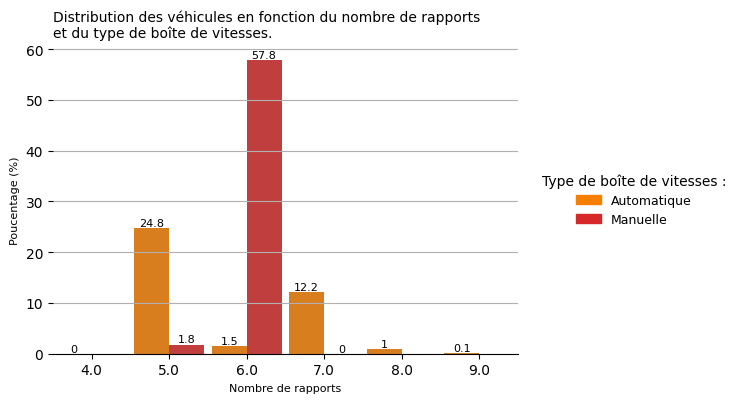

In [31]:
# Définition de la palette et de la légende
palette = ['#f77f00', '#d62828']
legend_ = [Patch(color='#f77f00', label="Automatique"),
           Patch(color='#d62828', label="Manuelle") ]

# 0. Création de la figure matplotlib
fig, ax1 = plt.subplots(figsize = (6,4))

# 1. Création du barplot vertical représentant la distribution des véhicules selon leur type de boîte de vitesse et le nombre de rapports
sns.barplot(ax = ax1, y="proportion", x="Nb_rapports", hue = "Type_Boite_Vitesse", data= df_plot , palette = palette,  width=0.9, alpha = 1)
ax1.bar_label(ax1.containers[0], fontsize=8)
ax1.bar_label(ax1.containers[1], fontsize=8)

# 2. Définition des axis et labels
ax1.set_xlabel("Nombre de rapports", fontsize=8)
ax1.set_ylabel("Poucentage (%)", fontsize=8)

# 3. Ajout des lignes horizontales
ax1.grid(visible=True, which="major", axis='y')
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)

# 4. Gestion de la légende et du titre principal
ax1.legend(  handles = legend_, loc='center left', bbox_to_anchor= (1.04, 0.5), ncol=1,
           borderaxespad=0, frameon=False, title = "Type de boîte de vitesses :", fontsize=9)
ax1.set_title("Distribution des véhicules en fonction du nombre de rapports \net du type de boîte de vitesses.",
               loc= 'left', fontsize=10)

fig.show()

* L'essentiel des véhicules de la base sont munis d'une boite manuelle à 6 vitesses.
* Pour les véhicules équipés d'une boite automatique, le nombre de vitesses varie entre 5 et 9. Parmi ceux-ci 24.8 % disposent de 5 vitesses et 12.2% de 7 vitesses.


#### 1.5.2.4 Carrosserie et gamme

In [32]:
# Affichons les différentes modalités de la variable 'gamme' :
df_train_c["gamme"].value_counts()

gamme
MOY-INFER         25121
MOY-SUPER         11371
LUXE               2660
SUPERIEURE         1098
INFERIEURE          791
ECONOMIQUE          175
MOY-INFERIEURE       36
Name: count, dtype: int64

La variable '`gamme`' est caractérisée par 6 catégories allant de la gamme 'économique' à la gamme 'luxe'.
La gamme 'moyenne inférieure' est désignée par 2 modalités distinctes. Affectons la même catégorie "MOY_INFER" aux observations concernées:

In [33]:
print(f"Avant correction de la gamme MOY-INFERIEURE il y a {(df_train_c['gamme'].str.startswith('MOY-INF')).sum()} observations isues de cette gamme.")
# Correction de la catégorie MOY-INFERIEURE en MOY-INFER
df_train_c.loc[df_train_c["gamme"] == "MOY-INFERIEURE","gamme"] = "MOY-INFER"
print(f"Après correction de la gamme MOY-INFERIEURE il y a {(df_train_c['gamme'] == ('MOY-INFER')).sum()} observations isues de cette gamme.")
print(f"Après correction La variable 'gamme' possède {df_train_c['gamme'].nunique()} modalités.")


Avant correction de la gamme MOY-INFERIEURE il y a 25157 observations isues de cette gamme.
Après correction de la gamme MOY-INFERIEURE il y a 25157 observations isues de cette gamme.
Après correction La variable 'gamme' possède 6 modalités.


L'ordre des modalités de cette variable est important et représentatif de la montée en gamme des véhicules.

In [34]:
# Créons un dictionnaire stockant l'ordre des catégories de la variable 'gamme'
dict_order_gamme = { "ECONOMIQUE" : 0, "INFERIEURE" : 1,  "MOY-INFER": 2,  "MOY-SUPER" : 3  , "SUPERIEURE" : 4,  "LUXE" : 5}

# Affichage du dictionnaire dict_order_gamme
dict_order_gamme

{'ECONOMIQUE': 0,
 'INFERIEURE': 1,
 'MOY-INFER': 2,
 'MOY-SUPER': 3,
 'SUPERIEURE': 4,
 'LUXE': 5}

In [35]:
# Affichons les différentes modalités de la variable 'Carrosserie' :
print(f"La variable 'Carrosserie' possède {df_train_c['Carrosserie'].nunique()} modalités.")
df_train_c["Carrosserie"].value_counts()

La variable 'Carrosserie' possède 11 modalités.


Carrosserie
MINIBUS                34658
BERLINE                 3286
BREAK                    881
TS TERRAINS/CHEMINS      819
COUPE                    649
CABRIOLET                395
MONOSPACE COMPACT        244
COMBISPACE               174
MINISPACE                 99
MONOSPACE                 43
COMBISPCACE                4
Name: count, dtype: int64

La variable '`Carrosserie`' présente 10 catégories qui intuitivement sont en relation avec la masse du véhicule et son aérodynamisme.

Le type de carrosserie 'Combispace' est repris par deux désignations différentes. Affectons la même catégorie "Combispace" aux observations concernées:

In [36]:
print(f"Avant correction de la catégorie 'COMBISPCACE' il y a {(df_train_c['Carrosserie'].str.startswith('COMBIS')).sum()} observations isues de cette gamme.")
# Correction de la catégorie MOY-INFERIEURE en MOY-INFER
df_train_c.loc[df_train_c["Carrosserie"] == "COMBISPCACE","Carrosserie"] = "COMBISPACE"
print(f"Après correction de la catégorie 'COMBISPCACE' il y a {(df_train_c['Carrosserie'] == ('COMBISPACE')).sum()} observations isues de cette gamme.")
print(f"Après correction La variable 'Carrosserie' possède {df_train_c['Carrosserie'].nunique()} modalités.")

Avant correction de la catégorie 'COMBISPCACE' il y a 178 observations isues de cette gamme.
Après correction de la catégorie 'COMBISPCACE' il y a 178 observations isues de cette gamme.
Après correction La variable 'Carrosserie' possède 10 modalités.


Les catégories de la variable '`Carrosserie`' peuvent être ordonnées selon leur masse médiane.

In [37]:
# Création de la base df0 qui associe à chaque catégorie de la variable Carrosserie, la masse médiane des véhicules, triées par order croissant de masse :
df0 = df_train_c.groupby(by="Carrosserie").agg({
    'masse_ordma_min' : 'median'}).sort_values(by="masse_ordma_min", ascending= True).reset_index()

# Affichage de df0
print(df0)

# Création d'un dictionnaire préservant l'ordre des catégories de la variable 'Carrosserie'
dict_order_carrosserie = dict(zip(df0["Carrosserie"], df0.index))

# Affichage du dictionnaire dict_order_carrosserie
dict_order_carrosserie

           Carrosserie  masse_ordma_min
0            MINISPACE           1356.0
1    MONOSPACE COMPACT           1475.0
2           COMBISPACE           1505.0
3              BERLINE           1570.0
4                COUPE           1655.0
5            CABRIOLET           1705.0
6                BREAK           1735.0
7            MONOSPACE           1822.0
8  TS TERRAINS/CHEMINS           1911.0
9              MINIBUS           2140.5


{'MINISPACE': 0,
 'MONOSPACE COMPACT': 1,
 'COMBISPACE': 2,
 'BERLINE': 3,
 'COUPE': 4,
 'CABRIOLET': 5,
 'BREAK': 6,
 'MONOSPACE': 7,
 'TS TERRAINS/CHEMINS': 8,
 'MINIBUS': 9}

Pour plus de lisibilité représentons la distribution des catégories des variables ‘`gamme`’ et ‘`Carrosserie`’ sous forme de barplots.

/tmp/ipykernel_3067/1502009573.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right', fontsize=9)
/tmp/ipykernel_3067/1502009573.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right', fontsize=9)
/tmp/ipykernel_3067/1502009573.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


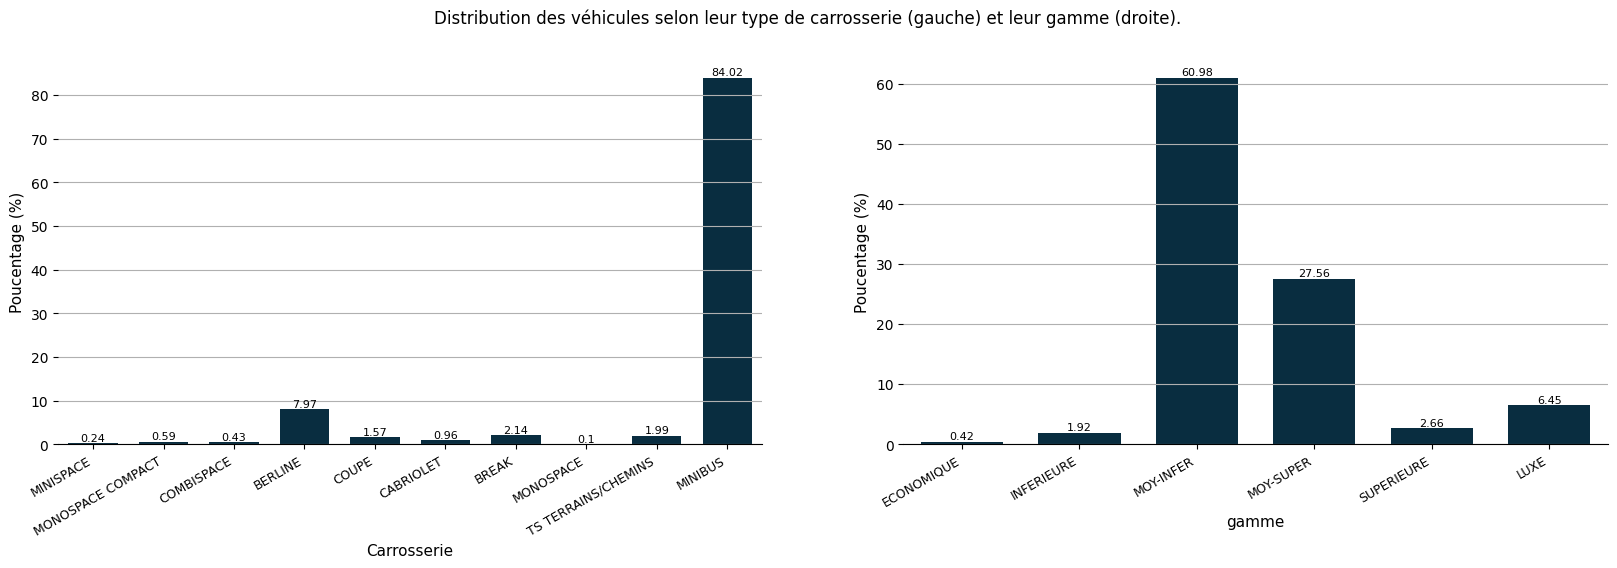

In [38]:
# Création des 2 barplots représentant la distribution des catégories des variables ‘`gamme`’ et ‘`Carrosserie`’

# Création de la figure matplotlib contenant 2 axes
fig = plt.figure(constrained_layout=False, figsize = (20,5))
[ax1, ax2] = fig.subplots(ncols = 2)

ax = ax1
_dict = dict_order_carrosserie
# Itération sur les 2 variables "Carrosserie", "gamme"
for i, var in enumerate(["Carrosserie", "gamme"]) :

    # 1. Création du barplot
    sns.barplot(ax = ax, y="proportion", x=var, data= (round(df_train_c.value_counts(subset=[var],  normalize=True)*100,2)).reset_index(),
                color = '#003049', legend=False, width=0.7, alpha = 1, order= _dict)

    # 2. Définition des axis et labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right', fontsize=9)
    ax.set_xlabel(var, fontsize=11)
    ax.set_ylabel("Poucentage (%)", fontsize=11)
    ax.bar_label(ax.containers[0], fontsize=8)

    # 3. Ajout des lignes horizontales
    ax.grid(visible=True, which="major", axis='y')
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax = ax2
    _dict = dict_order_gamme
fig.suptitle("Distribution des véhicules selon leur type de carrosserie (gauche) et leur gamme (droite).")
fig.show()


Ces résultats indiquent que certaines des catégories des variables '`Carroserie`' et '`gamme`' sont sous-représentées.

L’essentiel des véhicules sont des minibus (84%) et des berlines (8%).

Les gammes ‘Moyenne Inférieure’ et ‘Moyenne Supérieure’ constituent 89 % de nos données.


### 1.5.3 Norme EURO

In [39]:
#Affichage des modalités de 'champ_v9' :
print(f"La variable 'champ_v9' comprend {df_train_c['champ_v9'].nunique()} modalités qui sont les suivantes : \n {df_train_c['champ_v9'].value_counts()}")

La variable 'champ_v9' comprend 32 modalités qui sont les suivantes : 
 champ_v9
"715/2007*692/2008EURO5    17986
"715/2007*195/2013EURO5    11175
"715/2007*566/2011EURO5     3633
"2005/55*2008/74EURO5       1401
"2005/55*2008/74EEV         1381
"715/2007*195/2013EURO6     1248
"715/2007*630/2012EURO5      982
715/2007*630/2012EURO5       617
715/2007*692/2008EURO5       574
715/2007*195/2013EURO5       542
"595/2009*64/2012EURO6       442
"715/2007*630/2012EURO6      258
715/2007*566/2011EURO5       245
"715/2007*459/2012EURO5      242
715/2007*195/2013EURO6       202
715/2007*630/2012EURO6        93
"715/2007*143/2013EURO6       77
715/2007*459/2012EURO5        59
"715/2007*143/2013EURO5       26
"715/2007*566/2011EURO6       14
"715/2007*459/2012EURO6        8
715/2007*143/2013EURO5         5
715/2007*630/2012EURO          5
715/2007*1                     3
715/2007*459/2012EURO6         3
715/2007*195/2013EUR           2
715/20                         2
715/2007*195/20             

La colonne '`champs_v9`' fait référence au champ V9 du certificat d'immatriculation contenant la norme EURO définie précédemment


Nous pouvons remarquer que les différentes catégories sont des données textuelles composées des numéros des règlements de la commission européenne suivis de la norme EURO. Nous pouvons également remarquer que certains des champs V9 ont été tronqués ou sont erronés et par conséquent ne possèdent pas l'information de la norme EURO associée aux véhicules correspondants.


Afin d'avoir un aperçu de l'attribution de chaque norme, nous créons une variable ‘`norme_euro`’ en ne récupérant que le chiffre succédant à la chaîne de caractères 'EURO' lorsqu'elle existe :

In [40]:
# Création d'une variable 'norme_euro' à partir de la variable champ_v9:
df_train_c["norme_euro"] = df_train_c["champ_v9"].apply(lambda x : str(x).split("EURO")[1] if  re.search(r"EURO", str(x))     else np.nan)
df_train_c.loc[df_train_c["norme_euro"] =="","norme_euro"]=np.nan

# Affichons la distribution des modalités de 'norme_euro'
pd.DataFrame({"Count":df_train_c["norme_euro"].value_counts(),"%":df_train_c["norme_euro"].value_counts(normalize=True)*100})

,Count,%
norme_euro,,
5,37487,94.112774
6,2345,5.887226


Parmi les observations comprenant cette information, la norme EURO5 a été attribuée à 94% des véhicules contre 6% pour la norme EURO6.

### 1.5.4 Valeurs manquantes

Examinons le nombre de valeurs manquantes pour chaque variable qualitative.

In [41]:
counter  = 0 # Initialisation d'un compteur des colonnes ayant des valeurs manquantes

# Nous itérons sur toutes les variables qualitatives :
for v in df_train_c.select_dtypes(include='object').columns :
    # Si une colonne présente des valeurs manquantes:
    #  - on affiche son nom et le nombre de valeurs manquantes
    #  - on incrémente le compteur

    if (df_train_c[v].isna().sum() > 0) :
        print(f"{v} : {df_train_c[v].isna().sum()} manquantes.")
        counter += 1

print(f"{counter} variables qualitatives présentent des valeurs manquantes.")

champ_v9 : 20 manquantes.
date_maj : 38873 manquantes.
norme_euro : 1420 manquantes.
3 variables qualitatives présentent des valeurs manquantes.


Seulement 2 variables qualitatives présentes initialement en base sur 13 présentent des valeurs manquantes :
* La variable ‘`date_maj`’ que nous avons éludée jusqu'à présent représente la mise à jour des observations par l'ADEME. Cette variable ne nous est d'aucune utilité dans notre modélisation prédictive et pourra être supprimée par la suite.
* La variable relative au champ ‘`norme_euro`’ que nous avons créée présente 1420 valeurs manquantes. 

## 1.6 Analyse des variables quantitatives

### 1.6.1 Variables définissant les caractéristiques techniques

#### 1.6.1.1 La puissance

Nous disposons de 2 variables quantitatives relatives à la puissance :
* la puissance administrative (en chevaux fiscaux) nommée '`puiss_admin_98`'
* la puissance maximale (en kW)  nommée '`puiss_max`'

In [42]:
df_train_c[["puiss_admin_98","puiss_max"]].describe()


,puiss_admin_98,puiss_max
count,41252.000000,41252.000000
mean,10.543271,118.877599
std,5.079976,45.087574
min,2.000000,28.000000
25%,9.000000,100.000000
50%,10.000000,120.000000
75%,10.000000,120.000000
max,81.000000,585.000000


##### La puissance administrative

La puissance administrative est obtenue par calcul à partir de la puissance maximale et des émissions de dioxyde de carbone.
La formule utilisée de 1998 est la suivante :

Puiss_admin_98 $= \frac{CO_{2}}{45}+\frac{P_{max}}{40}^\frac{1}{6}$

où : CO2 est la valeur normalisée d'émission de dioxyde de carbone (en g/km),

Pmax désigne la puissance maximale du moteur (en kW).

La puissance administrative est arrondie à l'entier le plus proche
(source [ici](https://www.ornikar.com/permis/autour-voiture/immatriculation/carte-grise/puissance-administrative) ).

Vérifions si nos données sont conformes à cette définition :

In [43]:
# Calculons directement la puissance administrative selon la formule ci-dessus
df_train_c["puiss_admin_form"] = round((df_train_c["puiss_max"]/40)**1.6 + (df_train_c["co2"]/45),0).astype(int)

# Affichons les résultats pour 5 observations random
print(df_train_c[["puiss_admin_form","puiss_admin_98"]].sample(n=5, random_state=SEED))

# Et comparons-la à celle fournie dans nos données d'entraînement :
(df_train_c["puiss_admin_form"] - df_train_c["puiss_admin_98"]).describe()


       puiss_admin_form  puiss_admin_98
4780                 16              16
26249                11              11
13564                11              11
51186                10              10
53317                10              10


count    41252.000000
mean         0.000558
std          0.026509
min         -2.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
dtype: float64

La puissance administrative fournie dans nos données est bien calculée selon la formule ci-dessus. Puisque cette variable découle directement de notre target, nous pouvons d'ores et déjà l'éliminer de la liste des régresseurs à utiliser pour entraîner le modèle prédictif.

##### La puissance maximale

Illustrons la distribution de la puissance maximale en la représentant sous la forme d'un density plot ainsi que d'un boxplot pour mettre en avant les éventuelles valeurs aberrantes.

/tmp/ipykernel_3067/2974431011.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


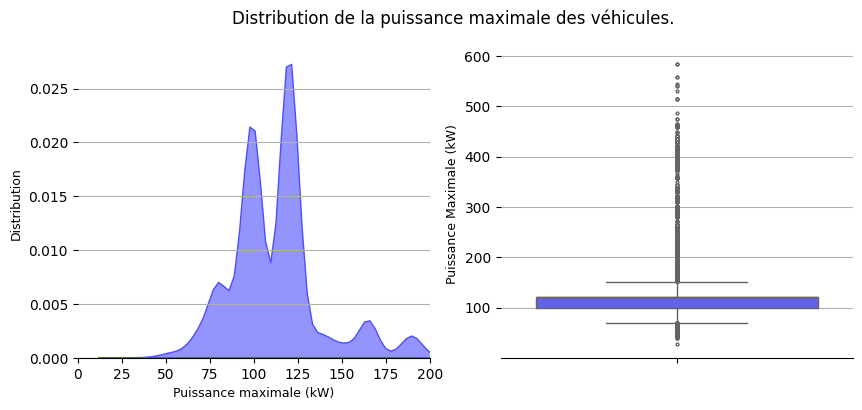

In [44]:
# Création de la figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# 1. Création du density plot de la puissance maximale
sns.kdeplot(ax=axes[0], data = df_train_c, x="puiss_max",  color='#4d4dff', alpha=0.6, fill=True,  legend=False)

#2. Définition des axis
axes[0].tick_params(axis='both', which='major', labelsize=10)
axes[0].set_xlim([0, 200])
axes[0].set_xlabel('Puissance maximale (kW)', fontsize=9)
axes[0].set_ylabel('Distribution', fontsize=9)

#3. Ajout des lignes horizontales pour faciliter la lecture
axes[0].grid(visible=True, which='major', axis='y')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['bottom'].set_visible(True)
axes[0].spines['left'].set_visible(False)

#4. Création du boxplot
sns.boxplot(ax=axes[1], data=df_train_c, y="puiss_max", color='#4d4dff', flierprops={"marker": ".", "markersize" : "4"})


#5. Gestion des axis et labels
axes[1].set_xlabel('')
axes[1].set_ylabel('Puissance Maximale (kW)', fontsize=9)

#6. Ajout des lignes horizontales
axes[1].grid(visible=True, which='major', axis='y')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['bottom'].set_visible(True)
axes[1].spines['left'].set_visible(False)

#7. Définition du titre principal
fig.suptitle(f'Distribution de la puissance maximale des véhicules.')

fig.show()

In [45]:
df_train_c["puiss_max"].describe()

count    41252.000000
mean       118.877599
std         45.087574
min         28.000000
25%        100.000000
50%        120.000000
75%        120.000000
max        585.000000
Name: puiss_max, dtype: float64

Ces graphiques indiquent que la distribution de la puissance maximale de notre jeu de données n'est pas symétrique avec :
* un double pic aux alentours de 90 et 120 KW suivi par une queue lourde.
* La médiane et le 3ème quartile sont identiques (120 KW)
* Selon la méthode des IQR, cette grandeur présente un certain nombre de valeurs extrêmes atteignant une maximum de 585 kW, tandis que certaines observations sont caractérisées par une puissance < 30kW


Regardons quels types de véhicules sont concernés par une puissance maximale supérieure à 500 kW :

In [46]:
print(f"{(df_train_c['puiss_max'] > 500).sum()} véhicules ont une puissance maximale > 500 kW.")

# Affichage des véhicules ayant puissance maximale dépassant 500 kW :
df_train_c.sort_values(by = "puiss_max", ascending = False).head(n=11)

11 véhicules ont une puissance maximale > 500 kW.


,lib_mrq,lib_mod_doss,lib_mod,dscom,cnit,tvv,cod_cbr,hybride,puiss_admin_98,puiss_max,typ_boite_nb_rapp,conso_urb,conso_exurb,conso_mixte,co2,co_typ_1,hc,nox,hcnox,ptcl,masse_ordma_min,masse_ordma_max,champ_v9,date_maj,Carrosserie,gamme,Carburant,Type_Boite_Vitesse,Nb_rapports,norme_euro,puiss_admin_form
1483,FERRARI,LAFERRARI,LAFERRARI,LaFerrari,M10FERVP000P145,F150ABE,EH,oui,80,585.000000,D 7,20.500000,10.2,14.000000,330.0,0.576,0.044,0.026,NaN,0.002,1565,1565,715/2007*459/2012EURO5,mars-14,COUPE,LUXE,ESSENCE,D,7.0,5,80
1484,FERRARI,LAFERRARI,LAFERRARI,LaFerrari,M10FERVP000R146,F150ADE,EH,oui,80,585.000000,D 7,20.500000,10.2,14.000000,330.0,0.576,0.044,0.026,NaN,0.002,1565,1565,715/2007*459/2012EURO5,mars-14,COUPE,LUXE,ESSENCE,D,7.0,5,80
197,ASTON MARTIN,ONE-77,ONE-77,ONE-77,M10SCFVP000Y155,VHYA1RONE77,ES,non,81,559.299988,A 6,41.099998,14.9,24.500000,572.0,0.782,0.067,0.049,NaN,NaN,1815,1815,715/2007*692/2008EURO5,mars-13,COUPE,LUXE,ESSENCE,A,6.0,5,81
196,ASTON MARTIN,ONE-77,ONE-77,ONE-77,M10SCFVP000S088,VHYA2LONE77,ES,non,80,559.299988,A 6,38.900002,14.5,23.900000,555.0,0.903,0.075,0.056,NaN,NaN,1815,1815,715/2007*692/2008EURO5,mars-13,COUPE,LUXE,ESSENCE,A,6.0,5,80
2612,LAMBORGHINI,AVENTADOR,AVENTADOR,VENENO,M10LBGVP000D820,834A21ACB,ES,non,74,545.000000,A 7,27.299999,11.3,17.200001,398.0,0.870,0.053,0.002,NaN,NaN,1640,1640,715/2007*459/2012EURO5,mars-14,COUPE,LUXE,ESSENCE,A,7.0,5,74
1481,FERRARI,F12,F12,F12Berlinetta,M10FERVP000V054,F152ABE,ES,non,73,541.000000,D 7,24.900000,11.3,16.299999,380.0,0.222,0.038,0.035,NaN,0.002,1791,1791,715/2007*566/2011EURO5,mars-14,COUPE,LUXE,ESSENCE,D,7.0,5,73
1480,FERRARI,F12,F12,F12Berlinetta,M10FERVP000U053,F152ABE,ES,non,72,541.000000,D 7,21.900000,10.9,15.000000,350.0,0.234,0.037,0.032,NaN,0.002,1791,1791,715/2007*566/2011EURO5,mars-14,COUPE,LUXE,ESSENCE,D,7.0,5,72
2606,LAMBORGHINI,AVENTADOR,AVENTADOR,AVENTADOR,M10LBGVP0005751,834D21ABC,ES,non,71,530.000000,A 7,24.700001,10.7,16.000000,370.0,0.869,0.053,0.002,NaN,NaN,1765,1765,715/2007*459/2012EURO5,mars-14,COUPE,LUXE,ESSENCE,A,7.0,5,71
2609,LAMBORGHINI,AVENTADOR,AVENTADOR,AVENTADOR ROADSTER,M10LBGVP0003616,834R21AAC,ES,non,68,515.000000,A 7,24.700001,10.7,16.000000,370.0,0.869,0.053,0.002,NaN,NaN,1815,1815,715/2007*692/2008EURO5,mars-14,CABRIOLET,LUXE,ESSENCE,A,7.0,5,68
2607,LAMBORGHINI,AVENTADOR,AVENTADOR,AVENTADOR,M10LBGVP000V741,834C21AAC,ES,non,68,515.000000,A 7,24.700001,10.7,16.000000,370.0,0.869,0.053,0.002,NaN,NaN,1765,1765,715/2007*459/2012EURO5,mars-14,COUPE,LUXE,ESSENCE,A,7.0,5,68


Ces véhicules sont principalement des voitures de luxe typées sportives.

Regardons quels types de véhicules sont concernés par une puissance maximale inférieure à 40 kW :

In [47]:
print(f"{(df_train_c['puiss_max'] < 40).sum()} véhicules ont une puissance maximale < 40 kW.")

# Affichage des véhicules ayant puissance maximale < 40 kW :
df_train_c[df_train_c['puiss_max'] < 40]

1 véhicules ont une puissance maximale < 40 kW.


,lib_mrq,lib_mod_doss,lib_mod,dscom,cnit,tvv,cod_cbr,hybride,puiss_admin_98,puiss_max,typ_boite_nb_rapp,conso_urb,conso_exurb,conso_mixte,co2,co_typ_1,hc,nox,hcnox,ptcl,masse_ordma_min,masse_ordma_max,champ_v9,date_maj,Carrosserie,gamme,Carburant,Type_Boite_Vitesse,Nb_rapports,norme_euro,puiss_admin_form
1075,BMW,SERIE I,I3,i3 avec Prolongateur d'autonomie,M10BM2VP0000008,BMWi-11Z416A040000,EE,oui,3,28.0,V 0,NaN,NaN,0.6,13.0,0.053,0.004,0.002,NaN,NaN,1390,1390,715/2007*195/2013EURO6,mars-14,BERLINE,INFERIEURE,ESSENCE,V,0.0,6,1


#### 1.6.1.2 La masse

2 variables quantitatives nous fournissent des indications quant à la masse des véhicules :
* La variable '`masse_ordma_min`' représente la masse en ordre de marche minimale, en d'autres termes le *Poids* à Vide en Ordre de Marche (PVOM).
* La variable '`masse_ordma_max`' représente la masse en ordre de marche maximale, en d'autres termes le *Poids* Total Autorisé en Charge (PTAC) .

In [48]:
# Regardons les principaux indicateurs statistiques de ces deux variables :
print(df_train_c[["masse_ordma_min", "masse_ordma_max"]].describe())

# Et vérifions que masse_ordma_max > masse_ordma_min pour toutes les observations :
(df_train_c["masse_ordma_max"] - df_train_c["masse_ordma_min"]).describe()

       masse_ordma_min  masse_ordma_max
count     41252.000000     41252.000000
mean       2103.856322      2343.931106
std         293.011436       422.304995
min         825.000000       825.000000
25%        1982.000000      2075.000000
50%        2076.000000      2355.000000
75%        2246.000000      2709.000000
max        2760.000000      3094.000000


count    41252.000000
mean       240.074784
std        261.332118
min          0.000000
25%         46.000000
50%        109.000000
75%        370.000000
max        833.000000
dtype: float64

Illustrons la distribution de ces 2 variables en les représentant sous la forme de density plots et de  boxplots.

/tmp/ipykernel_3067/1960617449.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[1], x="variable", y="value" , data=pd.melt(df[cols_masse]),palette = palette, flierprops={"marker": ".","markersize" : "4"})
/tmp/ipykernel_3067/1960617449.py:56: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


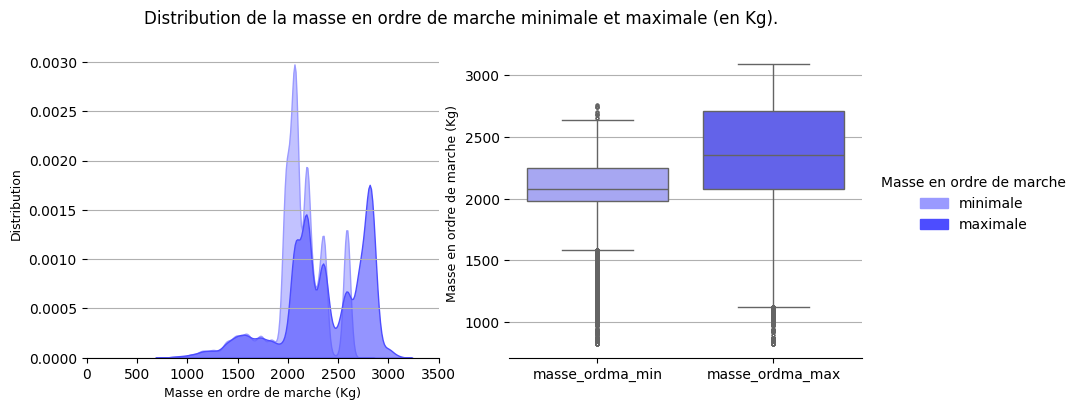

In [49]:
#######################################################################################################
## Création de 2 plots pour les 2 variables "masse_ordma_min" et "masse_ordma_max"":
##  * un density plot
##  * un boxplot
#######################################################################################################

# Définition de la liste des variables à représenter cols_masse ainsi que des couleurs associées
cols_masse = ["masse_ordma_min","masse_ordma_max"]
colors = ["#9a9aff","#4d4dff"]
palette = list() # initialisation de la palette utilisée pour le boxplot
legend_ =list()  #initialisation de la légende utilisée pour le boxplot

# 0. Création de la figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Itération sur les 2 variables "masse_ordma_min","masse_ordma_max"
for i,v in enumerate(cols_masse) :

    # 1. Création d'un density plot
    sns.kdeplot(ax=axes[0], data = df, x=v,  color=colors[i], alpha=0.6, fill=True,  legend=False, label = "lala")
    palette.append(colors[i])
    legend_.append(Patch(color=colors[i], label=str(v.split("_")[2].casefold()) + 'imale'))

# 1.A. Définition des axis
axes[0].tick_params(axis='both', which='major', labelsize=10)
axes[0].set_xlim([0, 3500])
axes[0].set_xlabel('Masse en ordre de marche (Kg)', fontsize=9)
axes[0].set_ylabel('Distribution', fontsize=9)

# 1.B. Ajout des lignes horizontales pour faciliter la lecture
axes[0].grid(visible=True, which='major', axis='y')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['bottom'].set_visible(True)
axes[0].spines['left'].set_visible(False)

# 2. Création du boxplot
sns.boxplot(ax=axes[1], x="variable", y="value" , data=pd.melt(df[cols_masse]),palette = palette, flierprops={"marker": ".","markersize" : "4"})

# 2.A. Gestion des axis et labels du boxplot
axes[1].set_xlabel('')
axes[1].set_ylabel('Masse en ordre de marche (Kg)', fontsize=9)


# 2.B. Ajout des lignes horizontales
axes[1].grid(visible=True, which='major', axis='y')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['bottom'].set_visible(True)
axes[1].spines['left'].set_visible(False)

#3. Ajout de la légende et du titre principal
axes[1].legend( handles = legend_, loc='center left', bbox_to_anchor= (1.04, 0.5), ncol=1,  borderaxespad=0, frameon=False, title = "Masse en ordre de marche")
fig.suptitle(f'Distribution de la masse en ordre de marche minimale et maximale (en Kg).')

fig.show()

Les indicateurs statistiques de ces deux variables nous indiquent que :
* La différence entre '`masse_ordma_max`' et '`masse_ordma_min`' est toujours >= 0, il n'y a donc pas d'incohérence au sein de la base.
* La valeur médiane de la masse minimale est supérieure à 2 tonnes ce qui vient corroborer le fait que notre base est présentée par une forte proportion de véhicules type "MINIBUS" (cf section 1.5.2.4)
* La distribution de `masse_ordma_min` est caractérisée par un pic principal aux alentours de 2050 Kg suivi par 3 pics secondaires de plus faibles amplitudes.
* Ces caractéristiques se retrouvent pour la variable `masse_ordma_max`, mais de plus faible amplitude avec une redistribution de la masse vers un pic aux alentours de 2800 Kg, explicable également par une prédominance dans notre base de minibus pouvant avoir une charge supplémentaire importante.
* Les 2 variables ne présentent pas de valeur aberrante.

### 1.6.2 Variables définissant la consommation de carburant

In [50]:
# Regardons les principaux indicateurs statistiques de trois variables "conso_urb", "conso_exurb", "conso_mixte" :
print(df_train_c[["conso_urb", "conso_exurb", "conso_mixte"]].describe())

          conso_urb   conso_exurb   conso_mixte
count  41246.000000  41246.000000  41252.000000
mean       9.578570      6.734294      7.768729
std        2.076046      1.037070      1.378294
min        0.000000      2.800000      0.600000
25%        8.800000      6.500000      7.300000
50%        9.400000      6.900000      7.900000
75%       10.200000      7.200000      8.300000
max       41.099998     14.900000     24.500000


In [51]:
# Affichons les observations pour lesquelles la consommation est minimale :
df_train_c[df_train_c["conso_mixte"]<3]

,lib_mrq,lib_mod_doss,lib_mod,dscom,cnit,tvv,cod_cbr,hybride,puiss_admin_98,puiss_max,typ_boite_nb_rapp,conso_urb,conso_exurb,conso_mixte,co2,co_typ_1,hc,nox,hcnox,ptcl,masse_ordma_min,masse_ordma_max,champ_v9,date_maj,Carrosserie,gamme,Carburant,Type_Boite_Vitesse,Nb_rapports,norme_euro,puiss_admin_form
55014,VOLVO,V60 HYBRID,V60,V60 PLUG-IN HYBRID D6 Geartronic 6 AWD,M10VLVVP909G813,GWAA50,GL,oui,10,158.0,A 6,0.0,5.5,1.8,48.0,0.020,NaN,0.036,0.038,0.0,1949,1949,715/2007*459/2012EURO5,mars-14,BREAK,SUPERIEURE,GAZOIL,A,6.0,5,10
39928,OPEL,AMPERA,AMPERA,AMPERA,M10PELVP212J867,D1JOIAAAAAAAAAAAAA,EE,oui,2,63.0,V 0,NaN,NaN,1.2,27.0,0.178,0.016,0.001,NaN,NaN,1732,1735,"""715/2007*459/2012EURO5",NaN,BERLINE,MOY-INFER,ESSENCE,V,0.0,5,3
1075,BMW,SERIE I,I3,i3 avec Prolongateur d'autonomie,M10BM2VP0000008,BMWi-11Z416A040000,EE,oui,3,28.0,V 0,NaN,NaN,0.6,13.0,0.053,0.004,0.002,NaN,NaN,1390,1390,715/2007*195/2013EURO6,mars-14,BERLINE,INFERIEURE,ESSENCE,V,0.0,6,1
1212,CHEVROLET,VOLT,VOLT,VOLT,M10CHEVP001Z810,D1JCIAAAAAAAAAAAAA,EE,oui,3,63.0,V 0,NaN,NaN,1.2,27.0,0.178,0.016,0.001,NaN,NaN,1732,1735,715/2007*459/2012EURO5,mars-14,BERLINE,MOY-INFER,ESSENCE,V,0.0,5,3


Les indicateurs statistiques des variables de consommation révèlent la présence d'un minimum en consommation urbaine et mixte de 0 et 0.6 L/100 km respectivement. Ces observations font référence à des véhicules hybrides électriques rechargeables, ces minima sont donc tout à fait plausibles.

Regardons plus en détail les distributions de ces 3 grandeurs au moyen de density plots et boxplots afin d'identifier les éventuelles valeurs aberrantes.

/tmp/ipykernel_3067/1622130332.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[1], x="variable", y="value" , data=pd.melt(df_train_c[variables_]),palette = palette, flierprops={"marker": ".","markersize" : "4"})
/tmp/ipykernel_3067/1622130332.py:57: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


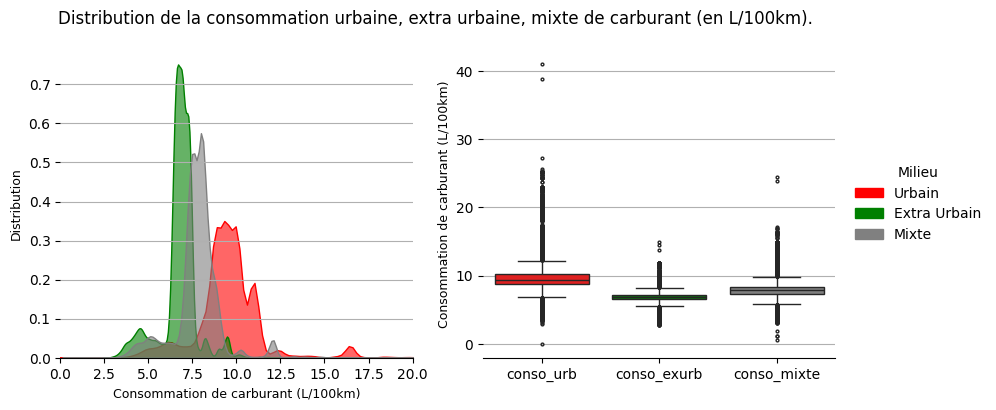

In [52]:
#######################################################################################################
## Création de 2 plots pour les 3 variables "conso_urb", " conso_exurb" et "conso_mixte"":
##  * un density plot
##  * un boxplot
#######################################################################################################

# Création d'un json json_conso contenant les 3 variables à représenter ainsi que leur couleur et leur label :
json_conso = '{ "variables" : [{"variable":"conso_urb",  "color" : "red", "label" : "Urbain"},{"variable":"conso_exurb",  "color" : "green", "label" : "Extra Urbain"},{"variable":"conso_mixte",  "color" : "grey", "label" : "Mixte"}]}'
json_ = json.loads(json_conso)

palette = list() # initialisation de la palette utilisée pour le boxplot
legend_ =list() # initialisation de la légende utilisée pour le boxplot
variables_ =list() # initialisation de la liste de variables utilisées pour le boxplot

# 0. Création de la figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# 1. Création du density plot
for var in json_['variables']:
    sns.kdeplot(ax=axes[0], data = df_train_c, x=var["variable"],  color=var["color"], alpha=0.6, fill=True,  legend=False, label = "lala")
    palette.append(var["color"])
    legend_.append(Patch(color=var["color"], label=var["label"]))
    variables_.append(var["variable"])

#1.A Définition des axis
axes[0].tick_params(axis='both', which='major', labelsize=10)
axes[0].set_xlim([0, 20])
axes[0].set_xlabel('Consommation de carburant (L/100km)', fontsize=9) # pour éviter la redondance, les xlabels ne sont définis que pour les axes 1 et 5
axes[0].set_ylabel('Distribution', fontsize=9) # pour éviter la redondance, les ylabels ne sont définis que pour les axes 4 et 8

#1.B Ajout des lignes horizontales pour faciliter la lecture
axes[0].grid(visible=True, which='major', axis='y')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['bottom'].set_visible(True)
axes[0].spines['left'].set_visible(False)

#2. Création du boxplot
sns.boxplot(ax=axes[1], x="variable", y="value" , data=pd.melt(df_train_c[variables_]),palette = palette, flierprops={"marker": ".","markersize" : "4"})

#2.A Gestion des axis et labels
axes[1].set_xlabel('')
axes[1].set_ylabel('Consommation de carburant (L/100km)', fontsize=9)
#axes[1].set_yticks(range(0,101,25))

#2.B Ajout des lignes horizontales
axes[1].grid(visible=True, which='major', axis='y')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['bottom'].set_visible(True)
axes[1].spines['left'].set_visible(False)

#3. Ajout de la légende et du titre principal
axes[1].legend( handles = legend_, loc='center left', bbox_to_anchor= (1.04, 0.5), ncol=1,  borderaxespad=0, frameon=False, title = "Milieu")
fig.suptitle(f'Distribution de la consommation urbaine, extra urbaine, mixte de carburant (en L/100km).')

fig.show()

In [53]:
# Affichages des outliers
df_train_c[df_train_c["conso_mixte"]>20]

,lib_mrq,lib_mod_doss,lib_mod,dscom,cnit,tvv,cod_cbr,hybride,puiss_admin_98,puiss_max,typ_boite_nb_rapp,conso_urb,conso_exurb,conso_mixte,co2,co_typ_1,hc,nox,hcnox,ptcl,masse_ordma_min,masse_ordma_max,champ_v9,date_maj,Carrosserie,gamme,Carburant,Type_Boite_Vitesse,Nb_rapports,norme_euro,puiss_admin_form
196,ASTON MARTIN,ONE-77,ONE-77,ONE-77,M10SCFVP000S088,VHYA2LONE77,ES,non,80,559.299988,A 6,38.900002,14.5,23.9,555.0,0.903,0.075,0.056,NaN,NaN,1815,1815,715/2007*692/2008EURO5,mars-13,COUPE,LUXE,ESSENCE,A,6.0,5,80
197,ASTON MARTIN,ONE-77,ONE-77,ONE-77,M10SCFVP000Y155,VHYA1RONE77,ES,non,81,559.299988,A 6,41.099998,14.9,24.5,572.0,0.782,0.067,0.049,NaN,NaN,1815,1815,715/2007*692/2008EURO5,mars-13,COUPE,LUXE,ESSENCE,A,6.0,5,81


Les mesures statistiques révèlent une bonne distribution des 3 variables de consommation en carburant avec pour chacune d'elles une valeur médiane relativement proche de leur valeur moyenne.
* La consommation extra urbaine enregistre une médiane de 6.9 L /100 km avec une faible dispersion de 1.037 L/100 km
* La consommation urbaine est caractérisée par une médiane de 9.4 L /100 km avec une dispersion légèrement plus élevée de 2.076 L/100 km
* La consommation mixte naturellement reprend les caractéristiques des 2 variables précédentes avec une médiane 7.9 L/100 km et une distribution 1.378 L/100 km

Les boxplots indiquent la présence de 2 outliers caractérisés par des consommations excédant 30, 12 et 20 L/100 km en milieu urbain, extra urbain et mixte respectivement. Ces outliers sont inclus dans la liste des outliers possédant une puissance maximale > 500 kW.
3 outliers sont caractérisés par des consommations mixtes inférieures à 3 L/100 km dont 1 faisant partie des outliers ayant une puissance maximale < 30 kW.

### 1.6.3 Variables définissant les émissions de gaz à effet de serre (GES) et polluants réglementés

Pour rappel le monoxyde de carbone (CO), les hydrocarbures imbrûlés, les oxydes d'azote (NOx), le dioxyde de carbone (CO2) et les particules en suspension (PM) - sont tous des produits de la combustion du carburant dans les moteurs des véhicules.


Le CO2 est un produit inévitable de la combustion complète du carburant, tandis que le CO et les HC sont directement issus de la combustion incomplète (*ie* manque de dioxygène).


Les NOx se forment lorsque l'azote de l'air réagit avec l'oxygène à haute température et à haute pression dans le moteur.


Les PM sont des particules en suspension pouvant provenir de diverses sources, y compris la combustion de carburant.

In [54]:
# Regardons les principaux indicateurs statistiques des variables "co2", "hc","nox","hcnox", "co_typ_1","ptcl" :
df_train_c[["co2", "hc","nox","hcnox", "co_typ_1","ptcl"]].describe()

,co2,hc,nox,hcnox,co_typ_1,ptcl
count,41252.000000,7255.000000,41157.000000,33935.000000,41157.000000,39295.000000
mean,201.834408,0.026387,0.300083,0.233736,0.180456,0.000893
std,33.868862,0.019446,0.417644,0.037416,0.144866,0.000994
min,13.000000,0.000000,0.000000,0.000000,0.005000,0.000000
25%,193.000000,0.008000,0.197000,0.216000,0.061000,0.000000
50%,205.000000,0.029000,0.214000,0.239000,0.137000,0.001000
75%,216.000000,0.041000,0.228000,0.253000,0.295000,0.001000
max,572.000000,0.510000,1.846000,0.570000,0.968000,0.023000


Regardons plus en détails la distribution de ces 6 variables.

/tmp/ipykernel_3067/1154643768.py:53: UserWarning: 
The palette list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(ax=axes[i,1], x="variable", y="value" , data=pd.melt(df_train_c[polluants_list]),palette = palette,hue ="variable", legend =False, flierprops={"marker": ".",
/tmp/ipykernel_3067/1154643768.py:53: UserWarning: 
The palette list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(ax=axes[i,1], x="variable", y="value" , data=pd.melt(df_train_c[polluants_list]),palette = palette,hue ="variable", legend =False, flierprops={"marker": ".",
/tmp/ipykernel_3067/1154643768.py:53: UserWarning: 
The palette list has fewer values (3) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(ax=axes[i,1], x="variable", y="value" , data=pd.melt(df_train_c[polluants_list]),palette = palette,hue ="variable", legend =False, flierprops={"mar

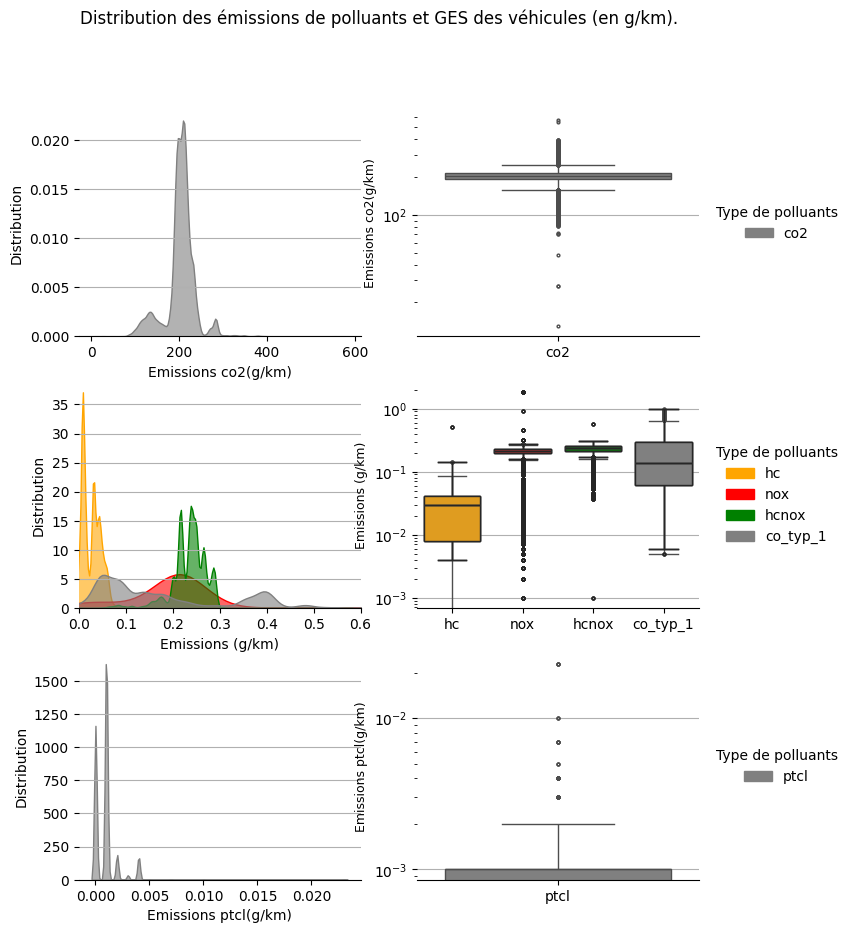

In [55]:
#######################################################################################################
## Création de 2 plots pour chaque variable "co2", "hc","nox","hcnox", "co_typ_1","ptcl":
##  * un density plot
##  * un boxplot
##  Les variables "hc","nox","hcnox", "co_typ_1" sont représentées sur les mêmes graphiques
#######################################################################################################

# Définition de la listes de variables à representer
cols_polluants = [["co2"], ["hc","nox","hcnox", "co_typ_1"],["ptcl"]]

# Définition des couleurs pour les variables "hc","nox","hcnox", "co_typ_1"
colors = ["orange", "red","green", "grey"]

# 0. Création sde la figure et des axes
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 10))

# Itération pour chaque liste de cols_polluants :
for i,polluants_list in enumerate(cols_polluants) :
    color = ["grey"] # couleur par défaut
    palette = list()
    legend_ =list()
    # Dans le cas des variables "hc","nox","hcnox", "co_typ_1" on utilise les couleurs définies par la liste colors
    if len(polluants_list) > 1:
        color = colors

    # Itération sur chaque élément de polluants_list
    for j, var in enumerate(polluants_list) :
        # 1. Création du density plot
        sns.kdeplot(ax=axes[i,0], data = df_train_c, x=var,  color=color[j], alpha=0.6, fill=True,  legend=False)
        palette.append(color[j])
        legend_.append(Patch(color=color[j], label=var))

        #1.A Définition des axis
        axes[i,0].tick_params(axis='both', which='major', labelsize=10)
        xlabel = "Emissions (g/km)"
        if len(polluants_list) > 1:
            axes[i,0].set_xlim([0, .6])
        else :
            xlabel = f"Emissions {var}(g/km)"
        axes[i,0].set_xlabel(xlabel)
        axes[i,0].set_ylabel('Distribution')

        #1.B Ajout des lignes horizontales pour faciliter la lecture
        axes[i,0].grid(visible=True, which='major', axis='y')
        axes[i,0].spines['top'].set_visible(False)
        axes[i,0].spines['right'].set_visible(False)
        axes[i,0].spines['bottom'].set_visible(True)
        axes[i,0].spines['left'].set_visible(False)


        # 2. Création du boxplot
        if len(v) > 1:
            sns.boxplot(ax=axes[i,1], x="variable", y="value" , data=pd.melt(df_train_c[polluants_list]),palette = palette,hue ="variable", legend =False, flierprops={"marker": ".",
                          "markersize" : "4"})
            axes[i,1].set_yscale('log')
        else :
            sns.boxplot(ax=axes[i,1], y=var , data=df_train_c,palette = palette,  flierprops={"marker": ".",
                    "markersize" : "4"}) #la liste palette qui a été défini dans le plot prcédent est reprise ici { hue="variable", palette=palette,}

        # 2.A Gestion des axis et labels
        axes[i,1].set_xlabel('')
        axes[i,1].set_ylabel(xlabel, fontsize=9)

        # 2.B Ajout des lignes horizontales
        axes[i,1].grid(visible=True, which='major', axis='y')
        axes[i,1].spines['top'].set_visible(False)
        axes[i,1].spines['right'].set_visible(False)
        axes[i,1].spines['bottom'].set_visible(True)
        axes[i,1].spines['left'].set_visible(False)

        # 2.C Ajout de la légende
        if len(v) > 1:
            axes[i,1].legend( handles = legend_, loc='center left', bbox_to_anchor= (1.04, 0.5), ncol=1,  borderaxespad=0, frameon=False, title = "Type de polluants")

# Définition du titre principal
fig.suptitle(f'Distribution des émissions de polluants et GES des véhicules (en g/km).')

fig.show()

In [56]:
# Affichage des observations caractérisées par des émissions de co2 >500 g/km
df_train_c[df_train_c["co2"]> 500]

,lib_mrq,lib_mod_doss,lib_mod,dscom,cnit,tvv,cod_cbr,hybride,puiss_admin_98,puiss_max,typ_boite_nb_rapp,conso_urb,conso_exurb,conso_mixte,co2,co_typ_1,hc,nox,hcnox,ptcl,masse_ordma_min,masse_ordma_max,champ_v9,date_maj,Carrosserie,gamme,Carburant,Type_Boite_Vitesse,Nb_rapports,norme_euro,puiss_admin_form
196,ASTON MARTIN,ONE-77,ONE-77,ONE-77,M10SCFVP000S088,VHYA2LONE77,ES,non,80,559.299988,A 6,38.900002,14.5,23.9,555.0,0.903,0.075,0.056,NaN,NaN,1815,1815,715/2007*692/2008EURO5,mars-13,COUPE,LUXE,ESSENCE,A,6.0,5,80
197,ASTON MARTIN,ONE-77,ONE-77,ONE-77,M10SCFVP000Y155,VHYA1RONE77,ES,non,81,559.299988,A 6,41.099998,14.9,24.5,572.0,0.782,0.067,0.049,NaN,NaN,1815,1815,715/2007*692/2008EURO5,mars-13,COUPE,LUXE,ESSENCE,A,6.0,5,81


In [57]:
# Affichage des observations caractérisées par des émissions de co2 < 80 g/km
df_train_c[df_train_c["co2"]<80]

,lib_mrq,lib_mod_doss,lib_mod,dscom,cnit,tvv,cod_cbr,hybride,puiss_admin_98,puiss_max,typ_boite_nb_rapp,conso_urb,conso_exurb,conso_mixte,co2,co_typ_1,hc,nox,hcnox,ptcl,masse_ordma_min,masse_ordma_max,champ_v9,date_maj,Carrosserie,gamme,Carburant,Type_Boite_Vitesse,Nb_rapports,norme_euro,puiss_admin_form
55014,VOLVO,V60 HYBRID,V60,V60 PLUG-IN HYBRID D6 Geartronic 6 AWD,M10VLVVP909G813,GWAA50,GL,oui,10,158.0,A 6,0.0,5.5,1.8,48.0,0.020,NaN,0.036,0.038,0.000,1949,1949,715/2007*459/2012EURO5,mars-14,BREAK,SUPERIEURE,GAZOIL,A,6.0,5,10
40533,PORSCHE,918 SPYDER,918,918 SPYDER,M10PSCVP000H710,918ZZ2201,EE,oui,49,447.0,A 7,NaN,NaN,3.1,72.0,0.112,0.021,0.008,NaN,0.001,1750,1750,715/2007*195/2013EURO5,mars-14,COUPE,LUXE,ESSENCE,A,7.0,5,49
40587,PORSCHE,PANAMERA S E-HYBRID,PANAMERA,PANAMERA S E-HYBRID,M10PSCVP000R659,970GT1204,EE,oui,20,245.0,A 8,NaN,NaN,3.1,71.0,0.179,0.011,0.012,NaN,0.001,2170,2170,715/2007*195/2013EURO6,mars-14,BERLINE,LUXE,ESSENCE,A,8.0,6,20
39928,OPEL,AMPERA,AMPERA,AMPERA,M10PELVP212J867,D1JOIAAAAAAAAAAAAA,EE,oui,2,63.0,V 0,NaN,NaN,1.2,27.0,0.178,0.016,0.001,NaN,NaN,1732,1735,"""715/2007*459/2012EURO5",NaN,BERLINE,MOY-INFER,ESSENCE,V,0.0,5,3
40586,PORSCHE,PANAMERA S E-HYBRID,PANAMERA,PANAMERA S E-HYBRID,M10PSCVP000R658,970GT1203,EE,oui,20,245.0,A 8,NaN,NaN,3.1,71.0,0.179,0.011,0.012,NaN,0.001,2170,2170,715/2007*195/2013EURO5,mars-14,BERLINE,LUXE,ESSENCE,A,8.0,5,20
1075,BMW,SERIE I,I3,i3 avec Prolongateur d'autonomie,M10BM2VP0000008,BMWi-11Z416A040000,EE,oui,3,28.0,V 0,NaN,NaN,0.6,13.0,0.053,0.004,0.002,NaN,NaN,1390,1390,715/2007*195/2013EURO6,mars-14,BERLINE,INFERIEURE,ESSENCE,V,0.0,6,1
1212,CHEVROLET,VOLT,VOLT,VOLT,M10CHEVP001Z810,D1JCIAAAAAAAAAAAAA,EE,oui,3,63.0,V 0,NaN,NaN,1.2,27.0,0.178,0.016,0.001,NaN,NaN,1732,1735,715/2007*459/2012EURO5,mars-14,BERLINE,MOY-INFER,ESSENCE,V,0.0,5,3


Nous pouvons remarquer que la distribution des émissions de CO2 est caractérisée par 3 pics et un forte concentration des observations entre 180 et 260 g/km. Les valeurs médianes et moyennes de notre target sont relativement proches (ie. 205 et 202 g/km respectivement) et sa dispersion est de 34 g/km.

La variable CO2 présente 2 outliers caractérisés par des émissions dépassant 500 g/km et 3 outliers émettant moins de 40g /km de C02. Ces 5 outliers sont les mêmes que pour la variable '`conso_mixte.`'

Concernant les variables relatives aux autres polluants, globalement elles sont caractérisées par une dispersion relativement importante, du même ordre de grandeur que leur valeur médiane à l’exception de la variable '`hcnox`'. Les variables '`hc`', '`nox`', '`hcnox`' et '`pctl`' présentent également quelques outliers.

### 1.6.4 Valeurs manquantes

Examinons les valeurs manquantes pour chaque variable quantitative :

In [58]:
counter  = 0 # Initialisation d'un compteur des colonnes ayant des valeurs manquantes

# Nous itérons sur toutes les variables quantitatives :
for v in df_train_c.select_dtypes(exclude='object').columns :
    # Si une colonne présente des valeurs manquantes:
    #  - on affiche son nom et le nombre de valeurs manquantes
    #  - on incrémente le compteur

    if (df_train_c[v].isna().sum() > 0) :
        print(f"{v} : {df_train_c[v].isna().sum()} manquantes.")
        counter += 1

print(f"{counter} variables quantitatives présentent des valeurs manquantes.")

conso_urb : 6 manquantes.
conso_exurb : 6 manquantes.
co_typ_1 : 95 manquantes.
hc : 33997 manquantes.
nox : 95 manquantes.
hcnox : 7317 manquantes.
ptcl : 1957 manquantes.
7 variables quantitatives présentent des valeurs manquantes.


In [59]:
# Affichage des observations concernées par des valeurs manquantes pour les champs conso_urb et conso_exurb
df_train_c[df_train_c["conso_urb"].isna() | df_train_c["conso_exurb"].isna()]

,lib_mrq,lib_mod_doss,lib_mod,dscom,cnit,tvv,cod_cbr,hybride,puiss_admin_98,puiss_max,typ_boite_nb_rapp,conso_urb,conso_exurb,conso_mixte,co2,co_typ_1,hc,nox,hcnox,ptcl,masse_ordma_min,masse_ordma_max,champ_v9,date_maj,Carrosserie,gamme,Carburant,Type_Boite_Vitesse,Nb_rapports,norme_euro,puiss_admin_form
40533,PORSCHE,918 SPYDER,918,918 SPYDER,M10PSCVP000H710,918ZZ2201,EE,oui,49,447.0,A 7,NaN,NaN,3.1,72.0,0.112,0.021,0.008,NaN,0.001,1750,1750,715/2007*195/2013EURO5,mars-14,COUPE,LUXE,ESSENCE,A,7.0,5,49
40587,PORSCHE,PANAMERA S E-HYBRID,PANAMERA,PANAMERA S E-HYBRID,M10PSCVP000R659,970GT1204,EE,oui,20,245.0,A 8,NaN,NaN,3.1,71.0,0.179,0.011,0.012,NaN,0.001,2170,2170,715/2007*195/2013EURO6,mars-14,BERLINE,LUXE,ESSENCE,A,8.0,6,20
39928,OPEL,AMPERA,AMPERA,AMPERA,M10PELVP212J867,D1JOIAAAAAAAAAAAAA,EE,oui,2,63.0,V 0,NaN,NaN,1.2,27.0,0.178,0.016,0.001,NaN,NaN,1732,1735,"""715/2007*459/2012EURO5",NaN,BERLINE,MOY-INFER,ESSENCE,V,0.0,5,3
40586,PORSCHE,PANAMERA S E-HYBRID,PANAMERA,PANAMERA S E-HYBRID,M10PSCVP000R658,970GT1203,EE,oui,20,245.0,A 8,NaN,NaN,3.1,71.0,0.179,0.011,0.012,NaN,0.001,2170,2170,715/2007*195/2013EURO5,mars-14,BERLINE,LUXE,ESSENCE,A,8.0,5,20
1075,BMW,SERIE I,I3,i3 avec Prolongateur d'autonomie,M10BM2VP0000008,BMWi-11Z416A040000,EE,oui,3,28.0,V 0,NaN,NaN,0.6,13.0,0.053,0.004,0.002,NaN,NaN,1390,1390,715/2007*195/2013EURO6,mars-14,BERLINE,INFERIEURE,ESSENCE,V,0.0,6,1
1212,CHEVROLET,VOLT,VOLT,VOLT,M10CHEVP001Z810,D1JCIAAAAAAAAAAAAA,EE,oui,3,63.0,V 0,NaN,NaN,1.2,27.0,0.178,0.016,0.001,NaN,NaN,1732,1735,715/2007*459/2012EURO5,mars-14,BERLINE,MOY-INFER,ESSENCE,V,0.0,5,3


7 variables quantitatives sur 13 présentent des valeurs manquantes.

**Note :** Les valeurs manquantes des variables '`conso_urb`' et '`conso_exurb`' ne concernent que des véhicules électriques rechargeables. Seule la consommation mixte a été relevée.

## 1.7 Analyses multivariées

### 1.7.1 Mesures statistiques des émission de CO2 en fonction des variables catégorielles

Dans cette section, nous examinons la distribution de notre target en fonction des modalités des variables qualititatives initiales ('`hybride`', '`Carrosserie`' et '`gamme`') et créées ('`Carburant`', '`Type_Boite_Vitesse`' , '`Nb_rapports`' et '`norme_euro`').

In [60]:
# Définition de la liste cols_cat contenant les variables quantitatives d'intérêt : (rappel 'Carburant', 'Type_Boite_Vitesse', 'norme_euro' et 'nb-rapports' sont ds variables que nous avons déduites de celles existantes initialement.)
cols_cat = ['Carburant', 'hybride', 'Type_Boite_Vitesse', 'norme_euro','Nb_rapports','gamme','Carrosserie']

# Nous convertissons tout d'abord les modalités de la variable Type_Boite_Vitesse :
# puisque que les 3 modalité V, S et D de cette variable sont très peut représentées nous les regroupons en une classe 'AUTRE' :
df_train_c["Type_Boite_Vitesse"] = df_train_c["Type_Boite_Vitesse"].map({"A" : "AUTOMATIQUE", "M" : "MANUELLE", "V" : "AUTRE", "S" : "AUTRE", "D" : "AUTRE"})

# Nous créons un dictionnaire contenant les variables dont nous voulons ordonner les catégories pour les représentations graphiques en barplots :
ordered_cat = {"Carrosserie" :  sorted(dict_order_carrosserie, key=dict_order_carrosserie.get),
              "gamme" : sorted(dict_order_gamme, key=dict_order_gamme.get),
               "Type_Boite_Vitesse" :  ["MANUELLE", "AUTOMATIQUE", "AUTRE"]}


Représentons graphiquement la distribution de la variable '`co2`' en fonction des modalités des variables catégorielles sous la forme de boxplots.

/tmp/ipykernel_3067/2136117521.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=30, ha='right', fontsize=9)
/tmp/ipykernel_3067/2136117521.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=30, ha='right', fontsize=9)
/tmp/ipykernel_3067/2136117521.py:43: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


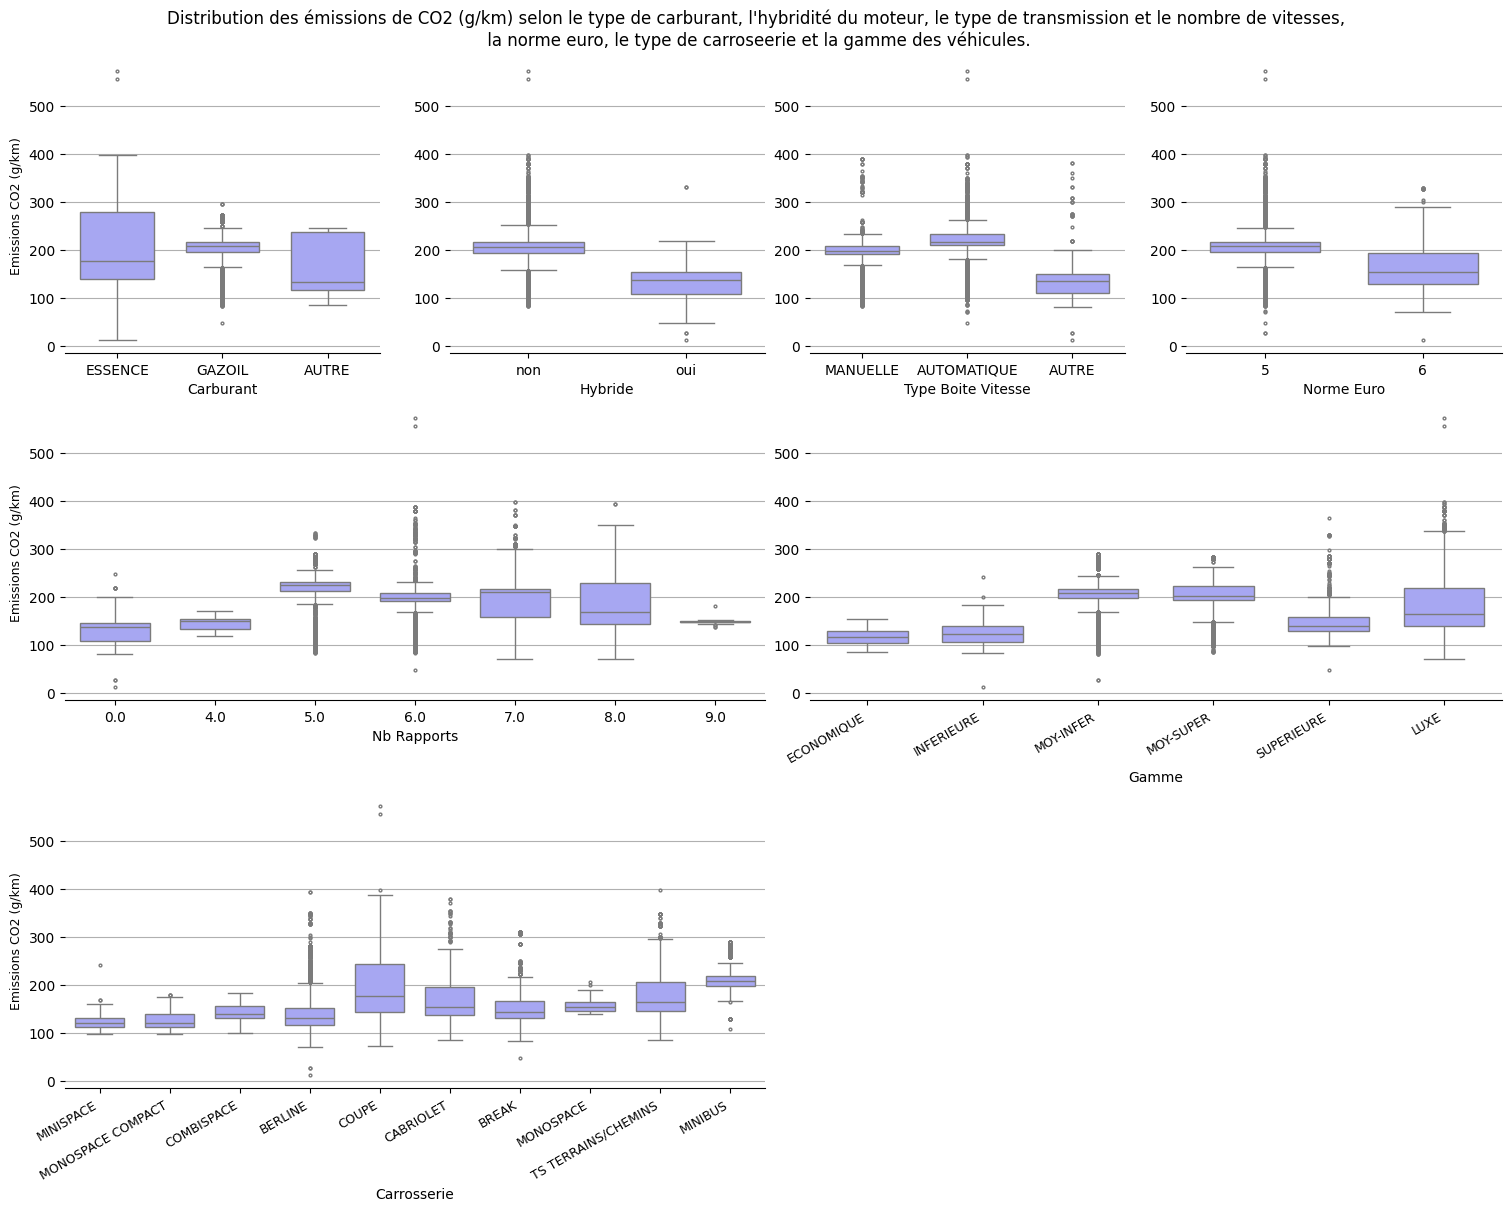

In [61]:
# Nous créons une figure composée de 7 graphiques répartis sur 3 lignes et 4 colonnes :

# 0. Définition de la figure et des 7 axes :
fig = plt.figure(constrained_layout=True, figsize = (15,12))
gs = fig.add_gridspec(3, 4)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[0, 3])
ax5 = fig.add_subplot(gs[1, :2])
ax6 = fig.add_subplot(gs[1, 2:])
ax7 = fig.add_subplot(gs[2, :2])
ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]

# On itère sur chaque variable catégorielle à représenter en abscisse
for i,v in enumerate(cols_cat) :
    # Gestion de l'ordre des modalités si besoin
    order = None
    if v in ordered_cat.keys() :
        order= ordered_cat[v]

    # 1. Création d'un boxplot
    sns.boxplot(ax=ax[i], y="co2" ,x = v, data=df_train_c, color = "#9a9aff", flierprops={"marker": ".", "markersize" : "4"}, width= 0.7, order = order)

    # 1.A Gestion des axis et labels
    ax[i].set_xlabel(v.replace("_"," ").title())
    ax[i].set_ylabel("")
    if (i == 0) | (i == 4) | (i == 6) :
        ax[i].set_ylabel("Emissions CO2 (g/km)", fontsize=9) # Le label des ordonnées n'est indiqué qu'en tête de ligne

    # 1.B. Ajout des lignes horizontales
    ax[i].grid(visible=True, which='major', axis='y')
    # Pour plus de lisibilité pour les variables présentant des modalités caractérisées par de longues chaines de caractères nous pivotons les labels :
    if (v == "Carrosserie")  | (v == "gamme"):
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=30, ha='right', fontsize=9)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['bottom'].set_visible(True)
    ax[i].spines['left'].set_visible(False)

# 1.C Ajout du titre principal
fig.suptitle(f'Distribution des émissions de CO2 (g/km) selon le type de carburant, l\'hybridité du moteur, le type de transmission et le nombre de vitesses,\n la norme euro, le type de carroseerie et la gamme des véhicules.')
fig.show()
fig.savefig("test.png")


Ces résultats nous montrent clairement concernant les véhicules de nos données d'entraînement que:
* les hybrides émettent moins de C02 que les non hybrides ( 137 contre 206 g/km en valeur médiane)
* Les véhicules à transmission manuelle sont moins émissifs que ceux à transmission automatiques (198 contre 216 g/km en valeur médiane)
* les moteurs Diesel sont plus émissifs que les moteurs Essence (207 contre 177 g/km en valeur médiane), avec néanmoins une dispersion des émissions en co2 des moteurs essence est beaucoup plus importante que pour les diesel (environ 70 contre 26 g/km).
* la montée en carrosserie se traduit globalement par plus d'émission de C02, avec néanmoins une exception pour les coupés qui émettent davantage que les véhicules tous terrains.
* Les véhicules de gamme moyenne inférieure et moyenne supérieure émettent plus que les autre types de gamme.
* Les véhicules présentant la norme EURO 6 rejettent moins de CO2 que ceux auxquels a été attribuée la norme EURO 5.  

Notons de plus que les outliers caractérisés par des émissions en CO2 > 500 g/km sont identificables comme des véhicules à moteur essence, non hybride, coupés de luxe tandis que les outliers ayant des émissions en CO2 <40 g/km sont identificables comme des berlines à moteur essence, hybride et de gamme inférieurs à moyenne inférieure.

### 1.7.2 Analyse des émissions de CO2 en fonction des variables quantitatives

Dans cette section, nous examinons les corrélations entre des variables quantitatives et notre variable expliquée.

Il est fréquent de considérer le rapport puissance_max/masse_min lorsque l'on parle de consommation des véhicules, nous créons cette variable afin de l'intégrer à l'étude qui suit.

In [62]:
# Création de la variable 'puiss_max/masse'
df_train_c["puiss_max/masse"] = df_train_c["puiss_max"]/ df_train_c["masse_ordma_min"]

/tmp/ipykernel_3067/1273840854.py:57: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


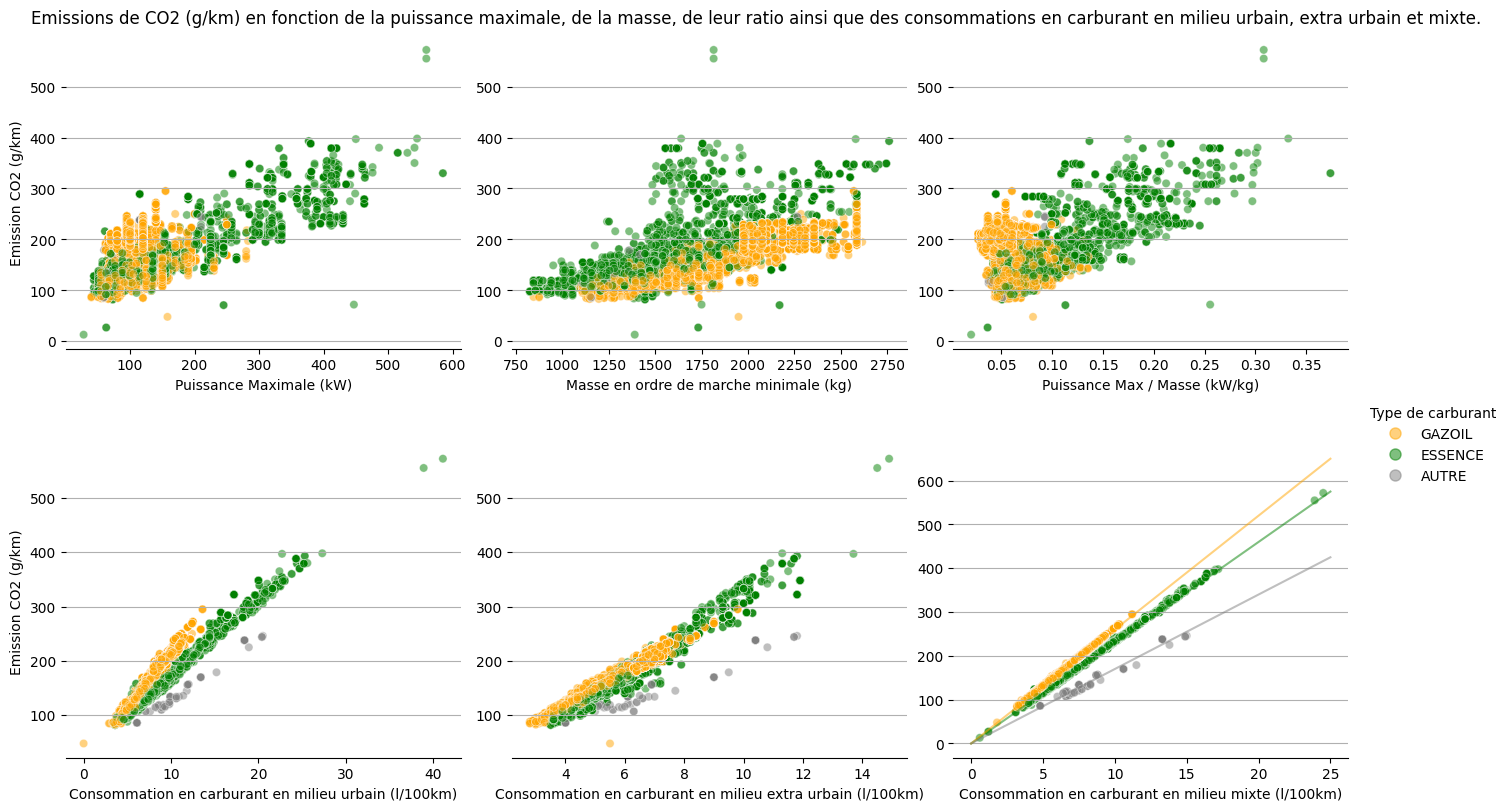

In [63]:
################################################################################################
## 6 scatterplots : co2 en fonction des 6 variables quantitatives :
## "puiss_max"  ,"masse_ordma_min" , "puiss_max/masse" , "conso_urb" ,"conso_exurb" ,"conso_mixte"
## les observations sont déclinées selon le type de carburant
################################################################################################

# Création d'un dictionnaire incluant les variables et leur label utlisé dans la légende
selected_vars_label = {"puiss_max" : "Puissance Maximale (kW)","masse_ordma_min": "Masse en ordre de marche minimale (kg)",
                "puiss_max/masse" : "Puissance Max / Masse (kW/kg)",
                "conso_urb" : "Consommation en carburant en milieu urbain (l/100km)",
                "conso_exurb" : "Consommation en carburant en milieu extra urbain (l/100km)",
                "conso_mixte" : "Consommation en carburant en milieu mixte (l/100km)"}

# Définition de la palette et de la légende pour le type de carburant
palette = {"GAZOIL" : "orange", "ESSENCE" : "green", "AUTRE" : "grey"}
handle_ = [plt.Line2D([], [], color=col, marker='o', linestyle='', markersize=8, alpha=0.5) for col in palette.values()]
legend_  = [carburant for carburant in palette.keys()]

#0. Création de la figure
fig, axe = plt.subplots(nrows = 2, ncols = 3, figsize=(15, 8), constrained_layout=True)

i, j = 0, 0
# Itération sur les 6 variables
for key, leg in selected_vars_label.items() :
    if j == 3 :
        j = 0
        i +=1
    #1. Création du scatterplot
    sns.scatterplot(ax=axe[i,j], data=df_train_c, x = key, y="co2",alpha=0.5, hue = "Carburant", palette = palette, legend = False)
    # sur le scatterplot coé = f(conso_mixte) on rajoute les 3 droites suivantes :
    if (i,j) == (1,2):
        sns.lineplot(ax=axe[i,j],  x = [0, 10, 25], y=[x*23 for x in [0, 10, 25] ],alpha=0.5, color=palette["ESSENCE"])
        sns.lineplot(ax=axe[i,j],  x = [0, 10, 25], y=[x*26 for x in [0, 10, 25] ],alpha=0.5, color=palette["GAZOIL"])
        sns.lineplot(ax=axe[i,j],  x = [0, 10, 25], y=[x*17 for x in [0, 10, 25] ],alpha=0.5, color=palette["AUTRE"])

    #2. Gestion des axis et labels
    axe[i,j].set_xlabel(str(leg))
    axe[i,j].set_ylabel('')
    if j == 0 :
        axe[i,j].set_ylabel('Emission CO2 (g/km)')

    #3. Ajout des lignes horizontales
    axe[i,j].grid(visible=True, which='major', axis='y')
    axe[i,j].spines['top'].set_visible(False)
    axe[i,j].spines['right'].set_visible(False)
    axe[i,j].spines['bottom'].set_visible(True)
    axe[i,j].spines['left'].set_visible(False)
    j+= 1

#3. Ajout de la légende
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handle_, legend_, title = "Type de carburant", loc='center left', bbox_to_anchor= (1.04, 1), borderaxespad=0, frameon=False, fontsize = 10)

#4. Ajout du titre principal
fig.suptitle(f'Emissions de CO2 (g/km) en fonction de la puissance maximale, de la masse, de leur ratio ainsi que des consommations en carburant en milieu urbain, extra urbain et mixte.')

fig.show()

Les conclusions que nous pouvons tirer de l'interprétation de ces graphiques sont que:
* Les émissions sont corrélées à la masse du véhicule. Notons par ailleurs qu'à masse égale les véhicules essence semblent émettre plus de CO2 en moyenne que les véhicules diesel.

* Les émissions de CO2 semblent proportionnelles à la puissance maximale des véhicules essence. Dans notre base, les véhicules dont la puissance dépassent 200 KW sont essentiellement des voitures Essence. En revanche il est plus difficile de distinguer une corrélation entre émissions et puissance maximale pour les véhicules Diesel.

* Des 2 points précédents découle naturellement le fait que les émissions et le ratio Puissance_Max/masse_min ont une bonne corrélation pour les véhicules Essence et vraissemblablement une faible corrélation pour les véhicules Diesel.

* Les 3 courbes concernant la consommation en carburant indiquent une excellente corrélation entre la consommation de carburant et les émissions de CO2 selon les différents carburants utilisés. Ceci est logique, les émissions de CO2 découlant de la combustion de carburant et donc de la consommation en carburant.
Ces 3 derniers graphiques nous montrent que les véhicules diesel de la base consomment globalement significativement moins que les véhicules essence. À consommation équivalente (en milieu urbain et mixte), les véhicules à moteurs Gazoil ont tendance à émettre légèrement plus de CO2. Cette distinction n’est pas valide pour la consommation en milieu extra urbain.

* Cette distinction de la consommation en carburant et des émissions de CO2 selon le type de carburant rejoint l'idée que si l'on considère une combustion parfaite alors les émissions de CO2 sont calculables selon la relation (cf [source](https://www.econologie.com/emissions-co2-litre-carburant-essence-diesel-ou-gpl/) ):
* * CO2 émis (en g/km) = 2.3* consommation (pour l'Essence)
* * CO2 émis (en g/km) = 2.6* consommation (pour le Diesel)
* * CO2 émis (en g/km) = 1.7* consommation (pour le GPL)

Ces trois courbes sont représentées sur le dernier graphique (en bas à droite), elles approchent de très près les observations.


Les 2 premiers graphiques révèlent la présence de 2 groupes d’outliers:
* Ceux dont les émissions de CO2 excèdent 500 g/km, nous les avons déjà identifiés précédemment,
* 8 outliers dont les émissions de CO2 sont inférieures à 80 g/km, parmi lesquelles 3 (< 30 g/km) ont déjà identifiés précédemment. Remarquons que ces observations correspondent à des véhicules hybrides (cf section 1.6.3)


**Note importante** : Il est important de considérer toutes les interprétations ci-dessus en prenant en compte le fait que les données sont fortement déséquilibrées au sein des classes des variables ‘`hybride`’, ‘`Carrosserie`’ et ‘`Carburant`’. A titre d'exemple, comme l’illustre le tableau ci-dessous, plus de 90% des véhicules diesels sont des minibus, alors que leur part n'est que de 21% parmi véhicules essence.

In [64]:
# A titre d'exemple, calculons la proportion des différents types de carrosserie selon le mode de carburant
df_train_c.groupby(by = [ "Carburant"])["Carrosserie"].value_counts(normalize =True)

Carburant  Carrosserie        
AUTRE      BERLINE                0.314286
           COMBISPACE             0.228571
           MINIBUS                0.228571
           TS TERRAINS/CHEMINS    0.114286
           MONOSPACE COMPACT      0.085714
           BREAK                  0.014286
           MINISPACE              0.014286
ESSENCE    BERLINE                0.398968
           MINIBUS                0.209440
           COUPE                  0.124631
           BREAK                  0.081613
           TS TERRAINS/CHEMINS    0.077434
           CABRIOLET              0.070305
           MONOSPACE COMPACT      0.016716
           MINISPACE              0.012537
           COMBISPACE             0.006883
           MONOSPACE              0.001475
GAZOIL     MINIBUS                0.910438
           BERLINE                0.044215
           BREAK                  0.014765
           TS TERRAINS/CHEMINS    0.013364
           MONOSPACE COMPACT      0.004580
           COUPE       

### 1.7.3 Pairs plot des variables '`puiss_max`', '`masse_ordma_min`',  '`conso_mixte`'

Regardons à présent s'il existe des corrélations entre  les variables '`puiss_max`', '`masse_ordma_min`', '`conso_mixte`' par le biais d'un pairs plot :

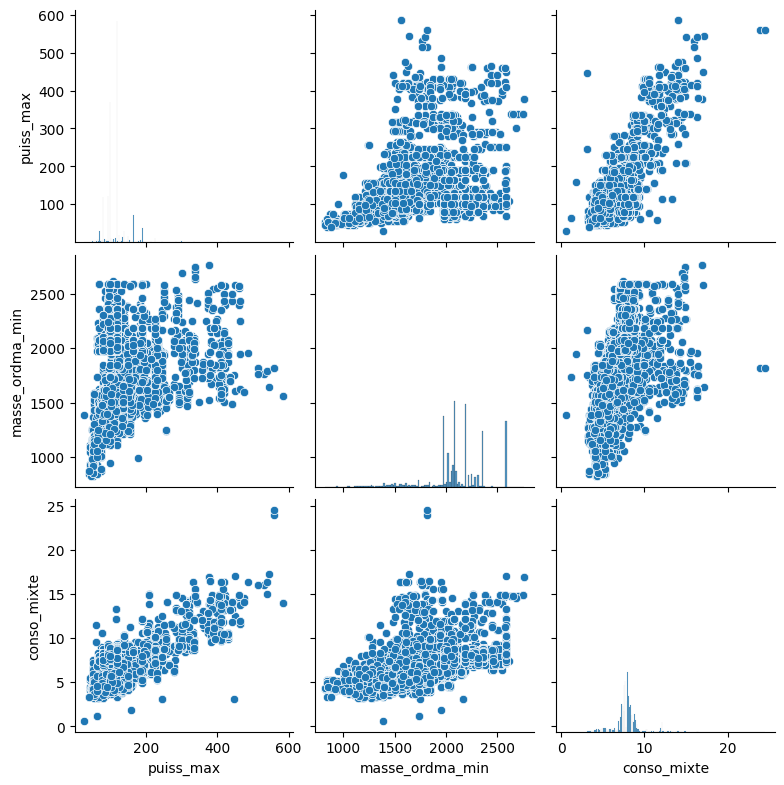

In [65]:
# Création et affichage du pairs plot
pairplot_figure = sns.pairplot(df_train_c[["puiss_max", "masse_ordma_min",  "conso_mixte"]])
pairplot_figure.fig.set_size_inches(8, 8)

Les conclusions que nous pouvons tirer de ce graphe sont que :
* la puissance maximale et la masse minimale semblent peu corrélées, ce qui en soit est cohérent : un moteur de forte puissance pouvant être installé sur n'importe quel véhicule indépendamment de sa masse.
* En revanche ces deux variables semblent davantage corrélées à la consommation en carburant, ce qui fait également sens.

### 1.7.4 Matrice de corrélation

Afin d'inclure les variables qualitatives '`Carrosserie`' et '`gamme`' dans le calcul de la matrice de corrélation, procédons à leur encodage selon ordre définition dans l'analyse univariée (cf section 1.5.2.4) :

In [66]:
# Encodage de la variable Carrosserie
df_train_c["Carrosserie"] = df_train_c["Carrosserie"].map(dict_order_carrosserie)

# Affichage des 5 1ères lignes en guise de vérification
df_train_c.head()

,lib_mrq,lib_mod_doss,lib_mod,dscom,cnit,tvv,cod_cbr,hybride,puiss_admin_98,puiss_max,typ_boite_nb_rapp,conso_urb,conso_exurb,conso_mixte,co2,co_typ_1,hc,nox,hcnox,ptcl,masse_ordma_min,masse_ordma_max,champ_v9,date_maj,Carrosserie,gamme,Carburant,Type_Boite_Vitesse,Nb_rapports,norme_euro,puiss_admin_form,puiss_max/masse
29505,MERCEDES,VIANO,VIANO,VIANO 3.5 E,M10MCDVP6093177,639/2LBC91305N2A4K7U37,ES,non,18,190.0,A 5,16.5,9.5,12.1,284.0,0.227,0.031,0.030,NaN,NaN,2186,2355,"""715/2007*692/2008EURO5",NaN,9,MOY-SUPER,ESSENCE,AUTOMATIQUE,5.0,5,18,0.086917
49548,VOLKSWAGEN,CRAFTER,CRAFTER,CRAFTER COMBI 35 L2H3 TDI (136ch),M10VWGVPE03M724,2EC2KH4C1350EMED24WD9,GO,non,9,100.0,M 6,9.9,7.4,8.3,218.0,0.137,NaN,0.214,0.239,0.001,2100,2815,"""715/2007*195/2013EURO5",NaN,9,MOY-INFER,GAZOIL,MANUELLE,6.0,5,9,0.047619
5293,MERCEDES,CLASSE E,E 200,E 200 CDI BERLINE BVM6 FAP,M10MCDVPGW7J532,212J0S1M0KLCCA4E2,GO,non,7,100.0,M 6,6.0,4.5,5.1,134.0,0.291,NaN,0.147,0.177,0.000,1735,1735,"""715/2007*195/2013EURO5",NaN,3,LUXE,GAZOIL,MANUELLE,6.0,5,7,0.057637
49588,VOLKSWAGEN,CRAFTER,CRAFTER,CRAFTER COMBI 35 L2H3 TDI (136ch) BlueMotion,M10VWGVPC45H945,2EC2KH4C1320EMEC25UA7,GO,non,9,100.0,M 6,8.8,6.7,7.5,197.0,0.137,NaN,0.214,0.238,0.001,2100,2709,"""715/2007*195/2013EURO5",NaN,9,MOY-INFER,GAZOIL,MANUELLE,6.0,5,9,0.047619
52372,VOLKSWAGEN,CRAFTER,CRAFTER,CRAFTER COMBI 35 L3H3 TDI (163ch) BlueMotion,M10VWGVPC461540,2EC2KH4D1320NLEC25UA7,GO,non,10,120.0,M 6,8.7,7.2,7.7,203.0,0.388,NaN,0.222,0.266,0.001,2246,2709,"""715/2007*195/2013EURO5",NaN,9,MOY-INFER,GAZOIL,MANUELLE,6.0,5,10,0.053428


In [67]:
# Encodage de la variable gamme
df_train_c["gamme"] = df_train_c["gamme"].map(dict_order_gamme)

# Affichage des 5 lignes random en guise de vérification
df_train_c.sample(n=5, random_state =42)

,lib_mrq,lib_mod_doss,lib_mod,dscom,cnit,tvv,cod_cbr,hybride,puiss_admin_98,puiss_max,typ_boite_nb_rapp,conso_urb,conso_exurb,conso_mixte,co2,co_typ_1,hc,nox,hcnox,ptcl,masse_ordma_min,masse_ordma_max,champ_v9,date_maj,Carrosserie,gamme,Carburant,Type_Boite_Vitesse,Nb_rapports,norme_euro,puiss_admin_form,puiss_max/masse
4780,MERCEDES,CLASSE CLS,CLS 350,CLS 350 CDI COUPE BVA7 FAP,M10MCDVPGY5Z221,218G32EM0NZAAB401,GO,non,16,195.0,A 7,7.8,5.1,6.1,160.0,0.304,NaN,0.147,0.190,0.002,1815,1815,"""715/2007*195/2013EURO5",NaN,4,5,GAZOIL,AUTOMATIQUE,7.0,5,16,0.107438
26249,MERCEDES,VIANO,VIANO,VIANO 2.2 CDI 4x4,M10MCDVP0238829,639/2LAA33280N1A2B2T28,GO,non,11,120.0,A 5,11.1,7.4,8.8,232.0,0.061,NaN,0.228,0.241,0.001,2105,2185,"""715/2007*692/2008EURO5",NaN,9,3,GAZOIL,AUTOMATIQUE,5.0,5,11,0.057007
13564,MERCEDES,SPRINTER,SPRINTER,SPRINTER COMBI 316 CDI - 43,M10MCDVPF14W350,906AC35KHMD1349ESCB2KWB9,GO,non,11,120.0,A 5,10.3,8.2,9.0,238.0,0.093,0.008,1.843,NaN,0.004,2586,2849,"""2005/55*2008/74EEV",NaN,9,2,GAZOIL,AUTOMATIQUE,5.0,NaN,11,0.046404
51186,VOLKSWAGEN,CRAFTER,CRAFTER,CRAFTER COMBI 35 L3H2 TDI (163ch),M10VWGVPE06X696,2EC2KM4D1320NLEC2LXB7,GO,non,10,120.0,M 6,10.1,6.6,7.9,207.0,0.185,0.000,0.106,NaN,0.000,2356,2709,"""595/2009*64/2012EURO6",NaN,9,2,GAZOIL,MANUELLE,6.0,6,10,0.050934
53317,VOLKSWAGEN,CRAFTER,CRAFTER,CRAFTER COMBI 35 L4H2 TDI (163ch),M10VWGVPE071480,2EC2KM4D1350ESEB2LXB9,GO,non,10,120.0,M 6,9.6,6.7,7.7,202.0,0.185,0.000,0.106,NaN,0.000,2356,2859,"""595/2009*64/2012EURO6",NaN,9,2,GAZOIL,MANUELLE,6.0,6,10,0.050934


/tmp/ipykernel_3067/2436231797.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


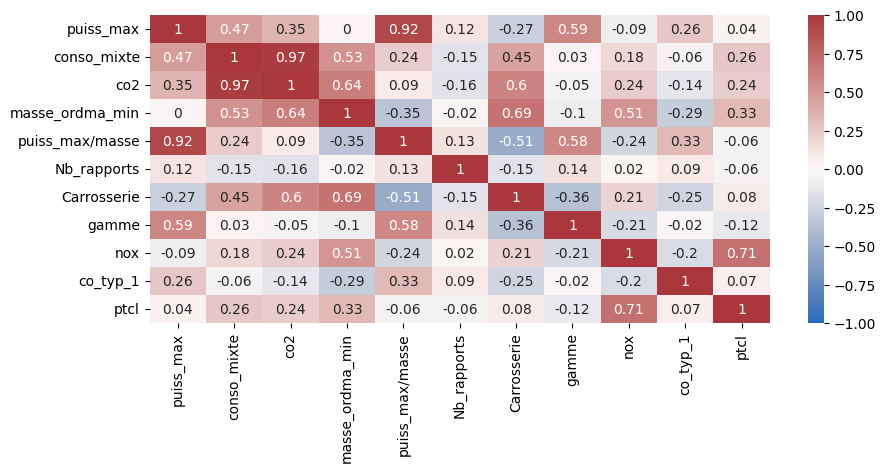

In [68]:
# liste des variables à utiliser pour générer la matrice de corrélation
col_for_corr = ['puiss_max', 'conso_mixte', 'co2','masse_ordma_min',  'puiss_max/masse', 'Nb_rapports',
       'Carrosserie', "gamme", "nox","co_typ_1", "ptcl"]

# Création de la matrice de corrélation
matrix = df_train_c[col_for_corr].corr().round(2)

# Plot sous la forme d'un heatmap de la matrice de corrélation
fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(ax = ax, data= matrix, vmax=1, annot = True, vmin=-1, center=0, cmap='vlag')
fig.show()

Cette matrice vient plussoyer les constats faits précédemment, à savoir :
* Les émissions de CO2 sont très fortement corrélées à la consommation mixte (avec un coefficient de 0.97), suivi par la masse, le type de carrosserie, et plus faiblement à la puissance maximale.
* On observe de fortes corrélations entre variables explicatives, par exemple entre la consommation, la masse, la puissance et la carrosserie.

Notons par ailleurs que le rapport '`puiss_max/masse`' possède une corrélation proche de 0 avec la target. Nous ne la prendrons pas en compte dans la suite de notre étude.

# 2. Modélisation prédictive des émissions de CO2

**Choix du modèle :**
Notre base d'entraînement étant composée d'un nombre d'observations < à 50000 et d'un nombre de features restreint (< 20), nous avons choisi d’utiliser l’algorithme LogisticRegression de scikit-learn afin d'entraîner notre régression linéaire.

## 2.1 Préparation des données

### 2.1.1 Sélection des variables pertinentes

#### 2.1.1.1 Suppression des variables environnementales

Conceptuellement il apparaît que les émissions de CO2 et de GES d'un véhicule sont des 'conséquences' directement reliées à ses caractéristiques techniques.
Ainsi intuitivement il paraît évident de décorréler la prédiction des émissions de C02 des émissions des autres GES.

A titre informatif : en théorie, en disposant des valeurs des émissions de C0, HC et NOx, du type de carburant et de l'efficacité de sa combustion selon le type de moteur, il pourrait être possible d'estimer via les rapports stoechimotériques les émissions de CO2 relatives. Ainsi l'ajout de ces variables (notammant CO et HC) pourrait avoir un sens pour expliquer notre target. Néanmoins plusieurs facteurs sont importants à prendre en compte :
 * les véhicules sont de plus en plus dotés de technologies visant directement à diminuer directement les émissions en HC, CO et NOx et nous n'avons pas de données relatives à cela.
 * Le « Dieselgate »,  scandale qui a éclaté en septembre 2015 impliquant entre autre  le fabricant automobile Volkswagen et révélant que celui-ci avait truqué les émissions de ses véhicules diesel lors des tests d'homologation pour se conformer aux normes environnementales, notamment les normes sur les émissions de dioxyde d'azote (NOx) aux États-Unis et en Europe. Or comme nous l'avons vu en section 1.5.1 notre base est constituée à 25 % de véhicules provenant de cette marque et la mise à jour de notre base date de 2015...

Pour ces raisons, nous avons donc choisi de ne pas intégrer les variables relatives aux émissions de GES dans notre modèle prédictif.

De même, la norme EURO dépendant entièrement de ces variables selon le type de carburant des véhicules, nous avons choisi de la supprimer de notre modèle.



#### 2.1.1.2 La question de la consommation mixte !

Comme nous l'avons vu dans l'analyse multivariée, la consommation en carburant et plus spécifiquement la consommation mixte est significativement corrélée à notre target avec un coefficient de corrélation de 0.97.

En pratique, ceci est évident puisque les émissions de CO2 sont directement liées à la quantité de carburant consommé via l'équation de combustion complète de carburant.

Néanmoins une question peut se poser dans notre jeu de données, à savoir si l’une des 2 mesures a été déduite de l’autre ou si elles ont été mesurées spécifiquement.

Concrètement, ces valeurs constructeurs sont généralement mesurées à l’aide  d'un protocole de test normalisé.

Si c’est le cas, on peut très bien imaginer qu'un modèle de régression linéaire pourrait avoir de très bonnes performances en donnant un fort poids aux variables  '`conso_mixte`' et '`cod_cbr`', la contribution des autres paramètres ne serait que mineure.

Dans le cas contraire, il faut éliminer la variable '`conso_mixte`' de notre étude et bâtir un modèle d’apprentissage basé sur les autres variables.

La consommation de carburant d'un véhicule s’explique par les facteurs combinés suivants :
- La masse du véhicule
- La puissance
- Son aérodynamique, partiellement décrite par la variable carrosserie
- La cylindrée du moteur dont nous n’avons pas d’indicateur
- le type de carburant
- l'hybridité du moteur
- la nature de la transmission (type de boîte de vitesses & nombre de rapports)
- et, à la marge, les équipements optionnels (reliés à la gamme)

Nous pouvons donc imaginer que la contribution accordée par les variables explicatives au modèle de régression linéaire sera plus significative en éliminant la variable '`conso_mixte`' de la liste des régresseurs.


#### 2.1.1.3 Variables sélectionnées

Nous avons choisi de construire 2 modèles basés sur un algorithme de régression linéaire est prenant en entrée les variables explicatives suivantes :
* **Modèle 1 :**
'`conso_mixte`','`puiss_max`','`masse_ordma_min`', '`cod_cbr`','`typ_boite_nb_rapp`', '`hybride`', '`gamme`', '`Carrosserie`' -> *(8 variables)*
* **Modèle 2 :**
'`puiss_max`','`masse_ordma_min`', '`cod_cbr`','`typ_boite_nb_rapp`', '`hybride`', '`gamme`', '`Carrosserie`' -> *(7 variables)*


In [69]:
# Définition de la liste de variables sélectionnées (8 explicatives + 1 target)
selected_variables = ["conso_mixte","puiss_max","masse_ordma_min", "cod_cbr","typ_boite_nb_rapp", "hybride", "gamme", "Carrosserie", "co2"]
df_train_val = df_train_val[selected_variables]

# Affichage des 5 premières lignes de notre échantillon
df_train_val.head()

,conso_mixte,puiss_max,masse_ordma_min,cod_cbr,typ_boite_nb_rapp,hybride,gamme,Carrosserie,co2
29505,12.1,190.0,2186,ES,A 5,non,MOY-SUPER,MINIBUS,284.0
49548,8.3,100.0,2100,GO,M 6,non,MOY-INFER,MINIBUS,218.0
5293,5.1,100.0,1735,GO,M 6,non,LUXE,BERLINE,134.0
49588,7.5,100.0,2100,GO,M 6,non,MOY-INFER,MINIBUS,197.0
52372,7.7,120.0,2246,GO,M 6,non,MOY-INFER,MINIBUS,203.0


### 2.1.2 Traitement des variables catégorielles

Notre base présente désormais de 5 variables catégorielles, nous avons vu précédemment que :
* Il est pertinent de classer les modalités de la variables '`Carrosserie`' par masse médiane croissante, nous utiliserons donc un encodage ordinal suivant l'ordre défini par le dictionnaire dict_order_carrosserie défini (section 1.5.2.4)
* De même, l'ordre des modalités de la variable '`gamme`' peut avoir un sens. Nous encoderons ces modalités par des entiers selon l'ordre par le dictionnaire dict_order_gamme défini (section 1.5.2.4)
* Nous avons également choisi de regrouper les modalités de la variable '`cod_cbr`' en 3 classes principales :  "GAZOIL", "ESSENCE", "AUTRES". Nous ne perdons pas l'information sur la double énergie   électrique / Carburant car elle est inclue dans la variable "hybride".
* Concernant la variable '`typ_boite_nb_rapp`', nous en extrayons deux variables '`Type_Boite_Vitesse`' et '`Nb_rapports`' (cf section 1.5.2.3). La variable '`Type_Boite_Vitesse`' sera définie par 3 modalités : "AUTOMATIQUE", "MANUELLE", "AUTRE".
* Pour les 3 variables '`Type_Boite_Vitesse`, '`cod_cbr`' et '`hybride`' : une analyse de l'apport des encodages neutres et d’étiquettes sur les performances des modèles sera menée dans la section 2.2.2.1.



In [70]:
# Définition d'une fonction traitant les variables catégorielles
def transform_variables(df) :
    df_new = df.copy()

    # Transformation des modalités de la variable 'cod_cbr' :
    df_new["cod_cbr"] = df["cod_cbr"].apply(lambda x : str(x).split("/")[0])
    df_new["cod_cbr"] = df["cod_cbr"].apply(lambda x : convert_carburant(x)).to_list()

    # Split de 'typ_boite_nb_rapp' en 2 variables 'Type_Boite_Vitesse' et 'Nb_rapports' :
    df_new[["Type_Boite_Vitesse", "Nb_rapports"]] =  df["typ_boite_nb_rapp"].str.split(expand = True)
    df_new.loc[df_new['Nb_rapports'] == ".", 'Nb_rapports'] = "0"
    df_new['Nb_rapports'] = df_new['Nb_rapports'].astype(int)
    df_new["Type_Boite_Vitesse"]= df_new["Type_Boite_Vitesse"].map({"A" : "AUTOMATIQUE", "M" : "MANUELLE", "V" : "AUTRE", "S" : "AUTRE", "D" : "AUTRE"})
    df_new.drop(columns = "typ_boite_nb_rapp", inplace = True)

    # Transformation et encodage des modalités de la variable 'gamme' :
    df_new.loc[df_new["gamme"] == "MOY-INFERIEURE","gamme"] = "MOY-INFER"
    df_new["gamme"] = df_new["gamme"].map(dict_order_gamme)

    # Transformation et encodage des modalités de la variable 'Carrosserie' :
    df_new.loc[df_new["Carrosserie"] == "COMBISPCACE","Carrosserie"] = "COMBISPACE"
    df_new["Carrosserie"] = df_new["Carrosserie"].map(dict_order_carrosserie)

    return df_new


## Appliquons la fonction transform_variables à df_train_val
df_train_val = transform_variables(df_train_val)

## Affichage des 1ères lignes
display(df_train_val.head())

print(f"Remarque : Dû au split de 'typ_boite_nb_rapp' en 2 variables, nous obtenons {df_train_val.shape[1]} colonnes : {df_train_val.shape[1]-1} variables explicatives + 1 target.")

,conso_mixte,puiss_max,masse_ordma_min,cod_cbr,hybride,gamme,Carrosserie,co2,Type_Boite_Vitesse,Nb_rapports
29505,12.1,190.0,2186,ESSENCE,non,3,9,284.0,AUTOMATIQUE,5
49548,8.3,100.0,2100,GAZOIL,non,2,9,218.0,MANUELLE,6
5293,5.1,100.0,1735,GAZOIL,non,5,3,134.0,MANUELLE,6
49588,7.5,100.0,2100,GAZOIL,non,2,9,197.0,MANUELLE,6
52372,7.7,120.0,2246,GAZOIL,non,2,9,203.0,MANUELLE,6


Remarque : Dû au split de 'typ_boite_nb_rapp' en 2 variables, nous obtenons 10 colonnes : 9 variables explicatives + 1 target.


### 2.1.3 Traitement des variables numériques

Puisque nous utilisons le modèle LinearRegression de scikit-Learn, il n'est pas requis de standardiser les variables numériques dans une même échelle.


Les variables que nous avons sélectionnées ne présentent pas de valeurs manquantes.


**Outliers** :

***Puissance maximale :***
Les analyses précédentes (cf section 1.6.1.1) ont révélé 11 observations dont la puissance maximale est supérieure à 500 KW, et 1 dont la puissance maximale est inférieure à 40 KW. Nous choisissons de leur imputer les seuils de 500 kW et 40 KW respectivement.

***Emission de CO2 et consommation mixte :***
* 2 observations ont des émissions de CO2 excèdent 500 g/km et une consommation mixte > 20 l/100km. Nous imputerons à leur consommation la valeur plafond de 20 l/100km  et calculerons les émissions de CO2 correspondante selon la formule définie section 1.7.2
* 4 observations ont une consommation mixte < 3 l/100km, parmi celles-ci 3 ont des émissions de co2 < 30 g/km. Nous imputerons à leur consommation la valeur plafond de 3 l/100km et calculerons les émissions de CO2 correspondantes.


In [71]:
#####################################################################################
#### Traitement des outliers / puiss_max :
#####################################################################################

# Création d'une variable booléenne 'outlier_puiss_max' spécifiant si l'observation est un outlier :
df_train_val["outlier_puiss_max"] = False
df_train_val.loc[(df_train_val["puiss_max"]> 500) | (df_train_val["puiss_max"] < 40), "outlier_puiss_max"] = True

# Vérification :
print(f"{df_train_val['outlier_puiss_max'].sum()} observations sont classées outliers dans la colonne 'outlier_puiss_max'.")

12 observations sont classées outliers dans la colonne 'outlier_puiss_max'.


In [72]:

# Imputation des seuils pour la puissance max :
df_train_val.loc[(df_train_val["puiss_max"]> 500) & (df_train_val["outlier_puiss_max"] == True), "puiss_max"] = 500
df_train_val.loc[(df_train_val["puiss_max"]< 40) & (df_train_val["outlier_puiss_max"] == True), "puiss_max"] = 40

# Affichage des outliers
df_train_val.loc[df_train_val["outlier_puiss_max"] == True, ["puiss_max","outlier_puiss_max"]]

,puiss_max,outlier_puiss_max
196,500.0,True
1483,500.0,True
2609,500.0,True
1484,500.0,True
1480,500.0,True
2611,500.0,True
2612,500.0,True
2606,500.0,True
1481,500.0,True
1075,40.0,True


In [73]:
#####################################################################################
#### Traitement des outliers / conso_mixte et co2 :
#####################################################################################

# Création d'une variable booléenne 'outlier_conso_mixte' spécifiant si l'observation est un outlier :
df_train_val["outlier_conso_mixte"] = False
df_train_val.loc[(df_train_val["conso_mixte"]> 20) | (df_train_val["conso_mixte"] < 3), "outlier_conso_mixte"] = True

# Vérification :
print(f"{df_train_val['outlier_conso_mixte'].sum()} observations sont classées outliers dans la colonne 'outlier_conso_mixte'.")
# Affichage des outliers
df_train_val.loc[df_train_val["outlier_conso_mixte"] == True, ["conso_mixte","outlier_conso_mixte","co2","cod_cbr"]]


6 observations sont classées outliers dans la colonne 'outlier_conso_mixte'.


,conso_mixte,outlier_conso_mixte,co2,cod_cbr
196,23.9,True,555.0,ESSENCE
55014,1.8,True,48.0,GAZOIL
39928,1.2,True,27.0,ESSENCE
1075,0.6,True,13.0,ESSENCE
1212,1.2,True,27.0,ESSENCE
197,24.5,True,572.0,ESSENCE


In [74]:
# Imputation des seuils pour la conso_mixte :
df_train_val.loc[(df_train_val["conso_mixte"]> 20), "conso_mixte"] = 20
df_train_val.loc[(df_train_val["conso_mixte"]< 3), "conso_mixte"] = 3

# Imputation des seuils pour la conso_mixte :
df_train_val.loc[(df_train_val["conso_mixte"] == 3) & (df_train_val["cod_cbr"] == "GAZOIL"), "co2"] =  3*(2.6*10)
df_train_val.loc[(df_train_val["conso_mixte"] == 3) & (df_train_val["cod_cbr"] == "ESSENCE"), "co2"] =  3*(2.3*10)
df_train_val.loc[(df_train_val["conso_mixte"] == 20) & (df_train_val["cod_cbr"] == "ESSENCE"), "co2"] =  20*(2.3*10)

# Affichage des outliers
df_train_val.loc[df_train_val["outlier_conso_mixte"] == True, ["conso_mixte","outlier_conso_mixte","co2","cod_cbr"]]

,conso_mixte,outlier_conso_mixte,co2,cod_cbr
196,20.0,True,460.0,ESSENCE
55014,3.0,True,78.0,GAZOIL
39928,3.0,True,69.0,ESSENCE
1075,3.0,True,69.0,ESSENCE
1212,3.0,True,69.0,ESSENCE
197,20.0,True,460.0,ESSENCE


### 2.1.4 Séparation en set de train et set de validation

Nous séparons notre jeu df_train_val en un jeu d'entraînement et un jeu de validation en conservant 30% de nos observations pour la validation.

In [75]:
# Split train / val
df_train, df_val = train_test_split(df_train_val, test_size = 0.3, random_state = SEED)

## 2.2 Définition des métriques

Les métriques que nous allons utiliser pour évaluer les performances d'apprentissage de nos modèles sont la MAE, RMSE, R2, et R2 ajusté.

Le coefficient de détermination (R2) est un bon indicateur dans le cas d'une régression linéaire afin d'estimer dans quelle mesure les fluctuations de la target peuvent être expliquées par les variations des variables explicative.

Le R2 ajusté est défini par la relation suivante afin de contrebalancer le fait que le R2 augmente avec le nombre de features :

$R2ajusté = 1 – \frac{(1-R2)*(n-1)}{(n-k-1)}$ où n est le nombre d'observations et k le nombre de features


In [76]:
# Définition de la fonction R2_adjusted
# n = le nombre d'observation
# k = le nombre de features
# r2 = R-carré
def calcul_R2_adjusted (n, r2, k) :
    return 1-(1-r2)*(n-1)/(n-k-1)


## 2.3 Modèle analytique sans apprentissage

Comme nous l’avons vu précédemment, les émissions des CO2 peuvent être directement reliées à la consommation en carburant en fonction du carburant selon les équations ci-dessous:
* CO2 (g/km) = conso_mixte (l/100km) x 2.6 x 10 pour le gazoil
* CO2 (g/km) = conso_mixte (l/100km) x 2.3 x 10 pour l'essence
* CO2 (g/km) = conso_mixte (l/100km) x 1.7 x 10 pour le GPL

Dans cette section, nous nous proposons en guise de référence de calculer la MAE, la RMSE et le R-carré en nous basant sur cette solution analytique.


In [77]:
# Définition de la fonction calcul_co2 permettant de calculer directement les émissions de CO2 à partir de la consommation et du carburant utilisé :
def calcul_co2(row) :
    co2 = 0
    if row.iloc[0] == "GAZOIL" :
        co2 =row.iloc[1]*2.6*10
    elif row.iloc[0] == "ESSENCE" :
        co2 =row.iloc[1]*2.3*10
    else :
        co2=row.iloc[1]*1.7*10
    return co2


In [78]:
# Calculons les émissions en CO2 des observations de notre set d'entraînement en appliquant la fonction calcul_co2
y_train_mod0_pred = df_train[["cod_cbr", "conso_mixte"]].apply(lambda x : calcul_co2(x), axis =1)

# Calcul des MAE, RMSE, R2 des résultats obtenus :
MAE = round(mean_absolute_error(df_train["co2"].values, y_train_mod0_pred),2)
RMSE = round(root_mean_squared_error(df_train["co2"].values, y_train_mod0_pred),2)
R2 = round(r2_score(df_train["co2"].values, y_train_mod0_pred),4)

# Affichons les performances de ce modèle :
print(f"Résultats de performances du modèle analytique :\nMAE :  {MAE}\nRMSE : {RMSE}\nR2 : {R2}\n")

Résultats de performances du modèle analytique :
MAE :  2.63
RMSE : 3.67
R2 : 0.9883



Cette solution évaluée sur notre set d'entraînement donne de très bons résultats caractérisés par une faible MAE de 2.63g/km ainsi qu'une RMSE de 3.67g/km (pour rappel : la valeur médiane des émissions réelles de CO2 est d'environ 200g/km).

## 2.4 Machine learning - régression linéaire

In [79]:
# Définition de la fonction get_perf_stat qui calcule la MAE, RMSE, R2 et R2 ajusté à partir des vecteurs y (target observée) , y_pred (target prédite) et de nb_var (le nombre de features)
def get_perf_stat(y, y_pred, nb_var) :
    MAE = round(mean_absolute_error(y, y_pred),2)
    RMSE = round(root_mean_squared_error(y, y_pred),2)
    R2 = round(r2_score(y, y_pred),4)
    R2_adjusted = round(calcul_R2_adjusted (len(y_pred), R2, nb_var),4)
    return MAE, RMSE, R2, R2_adjusted

### 2.4.1 Modèle 1


Rappelons dans ce premier modèle que nous testons la capacité prédictive d'une régression linéaire avec 9 features.
Dans un premier temps les variables catégorielles ‘`hybride`’, ‘`Type_Boite_Vitesse`’ et ‘`cod_cbr`’sont encodées par étiquettes. Nous testerons ensuite l’impact du one-hot encodage.

In [80]:
# Création des matrices X_train et X_val des variables explicatives
X_train = df_train.drop(columns  = ["co2","outlier_puiss_max","outlier_conso_mixte"])
X_val = df_val.drop(columns  = ["co2","outlier_puiss_max","outlier_conso_mixte"])

# Création des vecteurs y_train et y_val (notre target)
y_train = df_train["co2"]
y_val = df_val["co2"]

# Initialisation des encoders
ordinal_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
one_hot_encoder = OneHotEncoder()

# Définition de la liste de variables catégorielles pour lesquelles nous testerons 2 types d'encodage
variables_for_encoding = ["hybride", "cod_cbr", "Type_Boite_Vitesse"]



In [81]:
var_list = list() # Liste de variables explicatives en entrée du modèle

# Nous itérons sur chacune des variables explicatives afin de déterminer l'apport
# de l'ajout de chacune d'elles aux performances du modèle :
for var in X_train.columns :
    var_list.append(var)

    # On récupère parmi la liste var_list, les variables catégorielles à encoder & les autres variables
    cat_encoding = [v for v in var_list if v in variables_for_encoding]
    other_variables = [v for v in var_list if v not in cat_encoding]

    # Définition du préprocesseur
    preprocessor = ColumnTransformer(
        transformers=[
            ("cat_text", ordinal_encoder, cat_encoding),
            ("keep_columns", "passthrough", other_variables)
        ]
    )

    # Définition du pipeline de transformation pipe_mod1_ord_enc
    pipe_mod1_ord_enc = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())])

    # Entrainement du modèle à l'aide de (X_train, y_train), et prédiction de y_train_pred
    y_train_pred = pipe_mod1_ord_enc.fit(X_train, y_train).predict(X_train)

    # Evaluation des performances du modèle sur l'échantillon d'entraînement
    MAE_train, RMSE_train, R2_train, R2_adjusted_train = get_perf_stat(y_train, y_train_pred, X_train.shape[1])

    # Affichage des performances :
    print(f"Avec les {len(var_list)} variables suivantes : {var_list}\nLes performances sur le set de train sont :")
    print(f"MAE :  {MAE_train}, RMSE : {RMSE_train}, R2 : {R2_train}, R2 ajusté : {R2_adjusted_train}")

    # Prédiction des émissions de co2 - set de validation
    y_val_pred = pipe_mod1_ord_enc.predict(X_val)

    # Evaluation des performances du modèle sur l'échantillon de validation
    MAE_val, RMSE_val, R2_val, R2_adjusted_val = get_perf_stat(y_val, y_val_pred, X_train.shape[1])

    # Affichage des performances sur l'échantillon de validation :
    print(f"Les performances sur le set de validation sont :")
    print(f"MAE :  {MAE_val}, RMSE : {RMSE_val}, R2 : {R2_val}, R2 ajusté : {R2_adjusted_val}")
    print(f"\n")



Avec les 1 variables suivantes : ['conso_mixte']
Les performances sur le set de train sont :
MAE :  5.1, RMSE : 8.11, R2 : 0.9428, R2 ajusté : 0.9428
Les performances sur le set de validation sont :
MAE :  5.1, RMSE : 8.16, R2 : 0.9409, R2 ajusté : 0.9409


Avec les 2 variables suivantes : ['conso_mixte', 'puiss_max']
Les performances sur le set de train sont :
MAE :  3.99, RMSE : 7.0, R2 : 0.9574, R2 ajusté : 0.9574
Les performances sur le set de validation sont :
MAE :  4.0, RMSE : 7.08, R2 : 0.9555, R2 ajusté : 0.9555


Avec les 3 variables suivantes : ['conso_mixte', 'puiss_max', 'masse_ordma_min']
Les performances sur le set de train sont :
MAE :  3.71, RMSE : 5.71, R2 : 0.9716, R2 ajusté : 0.9716
Les performances sur le set de validation sont :
MAE :  3.76, RMSE : 5.82, R2 : 0.97, R2 ajusté : 0.97


Avec les 4 variables suivantes : ['conso_mixte', 'puiss_max', 'masse_ordma_min', 'cod_cbr']
Les performances sur le set de train sont :
MAE :  1.51, RMSE : 3.36, R2 : 0.9902, R2 ajust

In [82]:
display(pipe_mod1_ord_enc)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat_text',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['cod_cbr', 'hybride',
                                                   'Type_Boite_Vitesse']),
                                                 ('keep_columns', 'passthrough',
                                                  ['conso_mixte', 'puiss_max',
                                                   'masse_ordma_min', 'gamme',
                                                   'Carrosserie',
                                                   'Nb_rapports'])])),
                ('regressor', LinearRegression())])

In [83]:
# Détermination de l'équation issue de cette régression linéaire incluant les 9 variables:
equation = f"{round(pipe_mod1_ord_enc.named_steps['regressor'].intercept_,4)}"
for k, var in enumerate(cat_encoding + other_variables) :
    equation +=  f" + {round(pipe_mod1_ord_enc.named_steps['regressor'].coef_[k],4)} * {var}"
print(f"L'équation de cette régression est : {equation}\n\n")


L'équation de cette régression est : -28.3849 + 19.7336 * cod_cbr + -0.7387 * hybride + -0.7829 * Type_Boite_Vitesse + 23.6876 * conso_mixte + -0.0 * puiss_max + 0.0031 * masse_ordma_min + -0.4403 * gamme + 0.7711 * Carrosserie + -0.3539 * Nb_rapports





Ces résultats de prédiction des émissions de CO2 indiquent de très bonnes métriques sur nos jeux d'entraînement et de validation en considérant les 9 variables explicatives : '`conso_mixte`', '`puiss_max`', '`masse_ordma_min`', '`cod_cbr`', '`hybride`', '`gamme`', '`Carrosserie`', '`Type_Boite_Vitesse`', '`Nb_rapports`'.

99 % des variations observées peuvent être expliquées par le modèle. La MAE s’élève à environ 1.4g/km  ce qui est relativement faible en sachant que la valeur moyenne des émissions de CO2 sur notre jeu est d’environ 200g/km. La RMSE est également relativement faible (3.4 g/km).

Il est intéressant de noter également que les 3 variables '`conso_mixte`',  '`masse_ordma_min`', '`cod_cbr`' sont les 3 plus importants régresseurs. En effet les émissions de CO2 prédites en ne considérant que ces variables permettent d’atteindre une MAE et une RMSE d’environ 1.5 et 3.4g/km sur le jeu d'entraînement ainsi qu’un coefficient de détermination de 0.99. Ces métriques sont légèrement meilleures par rapport à celles obtenues avec le modèle analytique.

**L'équation de cette régression est :**

CO2 = -28.3849 + 19.7336 * cod_cbr + -0.7387 * hybride + -0.7829 * Type_Boite_Vitesse + 23.6876 * conso_mixte + -0.0 * puiss_max + 0.0031 * masse_ordma_min + -0.4403 * gamme + 0.7711 * Carrosserie + -0.3539 * Nb_rapports


**Remarque :** Le ratio entre le nombre de features et le nombre d'observations étant très faible, le R2 ajusté est égal au R2.

#### 2.4.1.1 Influence du type d'encodage des variables catégorielles '`hybride`', '`cod_cbr`' et '`Type_Boite_Vitesse`'

In [84]:
# Nous itérons sur chacune des variables catégorielles 'hybride', 'cod_cbr' et 'Type_Boite_Vitesse'
# afin de tester le gain du one-hot-encoder
for var in variables_for_encoding :
        # On crée la liste des 2 variables à encoder avec l'ordinal encoder
        ord_encoding = variables_for_encoding.copy()
        ord_encoding.remove(var)

        # Définition du préprocesseur
        preprocessor = ColumnTransformer(
        transformers=[
                ("cat_oh", one_hot_encoder, [var]),
                ("cat_ord", ordinal_encoder, ord_encoding),
                ("keep_columns", "passthrough", other_variables)
                                ]
        )

        # Définition du pipeline de transformation
        pipe_mod1_oh_enc = Pipeline([
                ('preprocessor', preprocessor),
                ('regressor', LinearRegression())])

        # Affichage du pipeline de transformation
        display(pipe_mod1_oh_enc)

        # entraînement du modèle à l'aide de (X_train, y_train), et prédiction de y_train_pred
        y_train_pred = pipe_mod1_oh_enc.fit(X_train, y_train).predict(X_train)

        # Evaluation des performances du modèle sur l'échantillon d'entrainement
        MAE_train, RMSE_train, R2_train, R2_adjusted_train = get_perf_stat(y_train, y_train_pred, X_train.shape[1])

        # Affichage des performances :
        print(f"l'encodage neutre de {var} produit les performances suivantes  sur le set de train :")
        print(f"MAE :  {MAE_train}, RMSE : {RMSE_train}, R2 : {R2_train}, R2 ajusté : {R2_adjusted_train}")


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat_oh', OneHotEncoder(),
                                                  ['hybride']),
                                                 ('cat_ord',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['cod_cbr',
                                                   'Type_Boite_Vitesse']),
                                                 ('keep_columns', 'passthrough',
                                                  ['conso_mixte', 'puiss_max',
                                                   'masse_ordma_min', 'gamme',
                                                   'Carrosserie',
                                                   'Nb_rapports'])])),
                ('regressor', LinearRegression())])

l'encodage neutre de hybride produit les performances suivantes  sur le set de train :
MAE :  1.34, RMSE : 3.2, R2 : 0.9911, R2 ajusté : 0.9911


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat_oh', OneHotEncoder(),
                                                  ['cod_cbr']),
                                                 ('cat_ord',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['hybride',
                                                   'Type_Boite_Vitesse']),
                                                 ('keep_columns', 'passthrough',
                                                  ['conso_mixte', 'puiss_max',
                                                   'masse_ordma_min', 'gamme',
                                                   'Carrosserie',
                                                   'Nb_rapports'])])),
                ('regressor', LinearRegression())])

l'encodage neutre de cod_cbr produit les performances suivantes  sur le set de train :
MAE :  1.33, RMSE : 2.98, R2 : 0.9923, R2 ajusté : 0.9923


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat_oh', OneHotEncoder(),
                                                  ['Type_Boite_Vitesse']),
                                                 ('cat_ord',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['hybride', 'cod_cbr']),
                                                 ('keep_columns', 'passthrough',
                                                  ['conso_mixte', 'puiss_max',
                                                   'masse_ordma_min', 'gamme',
                                                   'Carrosserie',
                                                   'Nb_rapports'])])),
                ('regressor', LinearRegression())])

l'encodage neutre de Type_Boite_Vitesse produit les performances suivantes  sur le set de train :
MAE :  1.34, RMSE : 3.2, R2 : 0.9911, R2 ajusté : 0.9911


Conclusion : L'encodage des variables '`hybride`', '`Type_Boite_Vitesse`' via le oneHotEncoder n'apporte aucun gain à notre modèle. Pour la variable '`cod_cbr`' le gain est mineur.

### 2.4.2 Modèle 2

Pour le modèle 2 nous supprimons la variable '`conso_mixte`' de la liste des régresseurs.

In [85]:
# Supprimons la variable 'conso_mixte' de X_train
X_train.drop(columns='conso_mixte', inplace= True)

# Affichage des 5 1ères lignes
X_train.head(n=5)

,puiss_max,masse_ordma_min,cod_cbr,hybride,gamme,Carrosserie,Type_Boite_Vitesse,Nb_rapports
40677,110.0,1610,GAZOIL,non,4,3,MANUELLE,6
33052,100.0,1976,GAZOIL,non,2,9,MANUELLE,6
20702,120.0,2356,GAZOIL,non,3,9,AUTOMATIQUE,5
16403,100.0,2050,GAZOIL,non,3,9,AUTOMATIQUE,5
6561,150.0,2160,GAZOIL,non,5,8,AUTOMATIQUE,7


In [86]:
# Supprimons la variable conso_mixte de X_val
X_val.drop(columns='conso_mixte', inplace= True)

# Affichage des 5 1ères lignes
X_val.head(n=5)

,puiss_max,masse_ordma_min,cod_cbr,hybride,gamme,Carrosserie,Type_Boite_Vitesse,Nb_rapports
4780,195.0,1815,GAZOIL,non,5,4,AUTOMATIQUE,7
26249,120.0,2105,GAZOIL,non,3,9,AUTOMATIQUE,5
13564,120.0,2586,GAZOIL,non,2,9,AUTOMATIQUE,5
51186,120.0,2356,GAZOIL,non,2,9,MANUELLE,6
53317,120.0,2356,GAZOIL,non,2,9,MANUELLE,6


Nous procédons à l'encodage ordinal des variables '`hybride`', '`cod_cbr`', '`Type_Boite_Vitesse`' :

In [87]:
# Encodage ordinal des variables 'hybride', 'cod_cbr', 'Type_Boite_Vitesse' sur le set de train
X_train["cod_cbr"] = X_train["cod_cbr"].map({"AUTRE" : 0, "ESSENCE" : 1, "GAZOIL": 2})
X_train["Type_Boite_Vitesse"] = X_train["Type_Boite_Vitesse"].map({"AUTOMATIQUE" : 0, "AUTRE" : 1, "MANUELLE": 2})
X_train["hybride"] = X_train["hybride"].map({"non" : 0, "oui" : 1})

# Encodage ordinal des variables 'hybride', 'cod_cbr', 'Type_Boite_Vitesse' sur le set de validation
X_val["cod_cbr"] = X_val["cod_cbr"].map({"AUTRE" : 0, "ESSENCE" : 1, "GAZOIL": 2})
X_val["Type_Boite_Vitesse"] = X_val["Type_Boite_Vitesse"].map({"AUTOMATIQUE" : 0, "AUTRE" : 1, "MANUELLE": 2})
X_val["hybride"] = X_val["hybride"].map({"non" : 0, "oui" : 1})

In [88]:
# Définition du modèle de régression linéaire
reg_mod2 = LinearRegression()

# entraînement du modèle à l'aide de (X_train, y_train)
reg_mod2.fit(X_train, y_train)

# Prédiction de la target pour l'échantillon d'entraînement
y_train_pred = reg_mod2.predict(X_train)

# Evaluation des performances du modèle sur l'échantillon d'entraînement
MAE_train, RMSE_train, R2_train, R2_adjusted_train = get_perf_stat(y_train, y_train_pred, X_train.shape[1])

# Affichage des performances :
print(f"Avec les {len(X_train.columns)} variables explicatives suivantes : \n{X_train.columns}\n")
print(f"Les performances sur le set de train sont : \nMAE :  {MAE_train}, RMSE : {RMSE_train}, R2 : {R2_train}, R2 ajusté : {R2_adjusted_train}")

 # Prédiction des émissions de co2 - set de validation
y_val_pred = reg_mod2.predict(X_val)

# Evaluation des performances du modèle sur l'échantillon de validation
MAE_val, RMSE_val, R2_val, R2_adjusted_val = get_perf_stat(y_val, y_val_pred, X_train.shape[1])

# Affichage des performances sur l'échantillon de validation :
print(f"Les performances sur le set de validation sont :")
print(f"MAE :  {MAE_val}, RMSE : {RMSE_val}, R2 : {R2_val}, R2 ajusté : {R2_adjusted_val}")


Avec les 8 variables explicatives suivantes : 
Index(['puiss_max', 'masse_ordma_min', 'cod_cbr', 'hybride', 'gamme',
       'Carrosserie', 'Type_Boite_Vitesse', 'Nb_rapports'],
      dtype='object')

Les performances sur le set de train sont : 
MAE :  11.89, RMSE : 16.05, R2 : 0.776, R2 ajusté : 0.7759
Les performances sur le set de validation sont :
MAE :  11.8, RMSE : 16.04, R2 : 0.7716, R2 ajusté : 0.7715


In [89]:
# Détermination de l'équation issue de cette régression linéaire :
equation = f"{round(reg_mod2.intercept_,4)}"
for k, var in enumerate(X_train.columns) :
       equation +=  f" + {round(reg_mod2.coef_[k],4)} * {var}"
print(f"L'équation de cette régression est : {equation}\n\n")

L'équation de cette régression est : 106.0194 + 0.3333 * puiss_max + 0.0384 * masse_ordma_min + -23.4311 * cod_cbr + -65.7299 * hybride + -6.1383 * gamme + 8.9496 * Carrosserie + -5.6717 * Type_Boite_Vitesse + -5.3024 * Nb_rapports




En excluant la variable explicative '`conso_mixte`', nous observons que nous atteignons tout de même des performances raisonnables avec une MAE et une RMSE d'environ 12 et 16g/km. le R-carré indique que plus de 77 % des variations observées peuvent être expliquées par le modèle.

Il est intéressant que noter que la RSME reste du même ordre de grandeur que la MAE indiquant finalement que les plus forts écarts de prédiction restent à la marge.

Les métriques de performance sont quasi identiques sur les jeux d'entraînement et de validation indiquant que nous ne sommes pas en situation de surapprentissage.

L'équation de prédiction des émissions de CO2 obtenue est définie par:

CO2 = 106.0194 + 0.3333 * puiss_max + 0.0384 * masse_ordma_min + -23.4311 * cod_cbr + -65.7299 * hybride + -6.1383 * gamme + 8.9496 * Carrosserie + -5.6717 * Type_Boite_Vitesse + -5.3024 * Nb_rapports


En considérant que les variables '`puiss_max`' et '`masse_ordma_min`' sont de l'ordre de 120 kW et 1500 kg, nous pouvons remarquer que les contributions les plus importantes sont celles des variables '`hybride`','`puiss_max`', '`masse_ordma_min` et '`cod_cbr`'.
Les contributions des autres paramètres sont plus faibles mais néanmoins plus significatives que dans le modèle 1.

Afin d'illustrer les prédictions sur les données d'entraînement et de validation nous définissons deux fonctions :
*  pred_vs_reel_scatterplot qui génère des scatterplots des résultats prédits versus ceux observés en fonction du type de carburant et de l'hybridité des véhicules.

* residual_boxplot qui créé des boxplots représentant les indicateurs statistiques des erreurs relatives des prédictions pour les 6 variables catégorielles.


In [90]:
# Création de 2*2 scatterplots des y predits versus les y réels en fonction du carburant et de la nature hybride des véhicules
# Les 2 figures du haut sont les comparaisons sur le jeu d'entraînement
# Les 2 figures du bas sont les comparaisons sur le jeu de validation

def pred_vs_reel_scatterplot(y_train_pred, y_train,y_val_pred, y_val, df_train, df_val) :
    # 0.  Création de la figure et des axes
    fig, axe = plt.subplots(nrows = 2, ncols = 2, figsize=(14, 10))
    palette_cod_cbr ={"ESSENCE": "green", "GAZOIL": "orange", "AUTRE":"grey"}
    palette_hybride ={"oui": "#CC2D35", "non": "blue"}

    y_reel = y_train
    y_pred = y_train_pred
    df = df_train
    # itération sur les 2 lignes
    for i in [0,1] :
        # on itère sur les 2 variables "cod_cbr", "hybride"

        palette = palette_cod_cbr
        for j, var in enumerate(["cod_cbr", "hybride"]) :
            #1. Création du scatterplot
            sns.scatterplot(ax=axe[i,j], data=df, x = y_reel, y=y_pred, alpha=0.5, hue = var, palette = palette)
            #2. On ajoute la ligne y_pred = y_reel
            sns.lineplot(ax=axe[i,j],  x = y_reel, y=y_reel,alpha=0.5, color="black")

            #3 Définitions des labels sur les axes
            axe[i,j].set_xlabel("Emissions de co2 (g/km) - Observations")
            axe[i,j].set_ylabel('Emissions de co2 (g/km) - Prédictions')

            #4. Ajout des lignes horizontales
            axe[i,j].grid(visible=True, which='major', axis='y')
            axe[i,j].spines['top'].set_visible(False)
            axe[i,j].spines['right'].set_visible(False)
            axe[i,j].spines['bottom'].set_visible(True)
            axe[i,j].spines['left'].set_visible(False)

            #5. Ajout de la légende
            legend = axe[i,j].legend()
            legend.set_title(var)
            if var == "cod_cbr" :
                legend.set_title("Carburant")
            palette = palette_hybride
        y_reel = y_val
        y_pred = y_val_pred
        df = df_val
        palette = palette_cod_cbr


    #3. Ajout des titres
    axe[0,0].set_title("Prédiction des émissions de CO2 vs les émissions réelles - Jeu de données d'entrainement", loc='left' ,fontsize=13)
    axe[1,0].set_title("Prédiction des émissions de CO2 vs les émissions réelles - Jeu de données de validation",  loc='left' , fontsize=13)
    return fig


In [91]:
# Création de 6 boxplots représentant la distribution des erreurs résiduelles relatives
# (y_pred - y_reel)/y_reel pour les 6 variables catégorielles.

def residual_boxplot(y_pred, y, df_, dict_carrosserie, dict_gamme) :
    df = df_.copy()

    # On calcule les erreurs résiduelles relatives
    y_diff_rel = abs(y_pred - y)/y

    # On génère les dictionnaires inverses pour variables carrosseries et gamme
    dict_carrosserie_inverse = {v: k for k, v in dict_carrosserie.items()}
    dict_gamme_inverse = {v: k for k, v in dict_gamme.items()}

    # On inverse l'encodage ordinal des variables 'Carrosserie' et 'gamme'
    df["Carrosserie"] = df["Carrosserie"].apply(lambda x : dict_carrosserie_inverse[int(x)])
    df["gamme"] = df["gamme"].map(lambda x : dict_gamme_inverse[int(x)])

    # 0. Définition de la figure et des 6 axes :
    fig = plt.figure(constrained_layout=True, figsize = (15,6))
    gs = fig.add_gridspec(2, 4)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2])
    ax4 = fig.add_subplot(gs[0, 3])
    ax5 = fig.add_subplot(gs[1, :2])
    ax6 = fig.add_subplot(gs[1, 2:])
    ax = [ax1, ax2, ax3, ax4, ax5, ax6]

    # On itère sur chaque variable catégorielle à représenter en abscisse
    for i,v in enumerate(["cod_cbr", "hybride", "Type_Boite_Vitesse", "Nb_rapports","Carrosserie", "gamme"]) :

        # Gestion de l'ordre des catégories
        order = None
        if (v == "Carrosserie") :
            order =dict_carrosserie
        if (v == "gamme"):
            order =dict_gamme

        # 1. Création d'un boxplot
        sns.boxplot(ax=ax[i], y=y_diff_rel ,x = v, data=df, color = "#9a9aff",
                    flierprops={"marker": ".", "markersize" : "4"}, width= 0.7 , order = order)

        # 2. Gestion des axis et labels
        ax[i].set_xlabel(v)
        ax[i].set_ylabel("")
        if (i == 0) | (i == 4)  :
            ax[i].set_ylabel("Erreur résiduelle relative  (-)", fontsize=9) # Le label des ordonnées n'est indiqué qu'en tête de ligne

        # 3. Ajout des lignes horizontales
        ax[i].grid(visible=True, which='major', axis='y')

        # Pour plus de lisibilité pour les variables présentant des modalités caractérisées par de longues chaines de caractères nous pivotons les labels :
        if (v == "Carrosserie")  | (v == "gamme"):
            ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=30, ha='right', fontsize=9)
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['bottom'].set_visible(True)
        ax[i].spines['left'].set_visible(False)
        ax[i].set_ylim(0, 0.8)

    # 4. Ajout du titre principal
    fig.suptitle('Distribution de l\'erreur résiduelle prédite pour les variables catégorielles.')
    return fig


/tmp/ipykernel_3067/1976672480.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


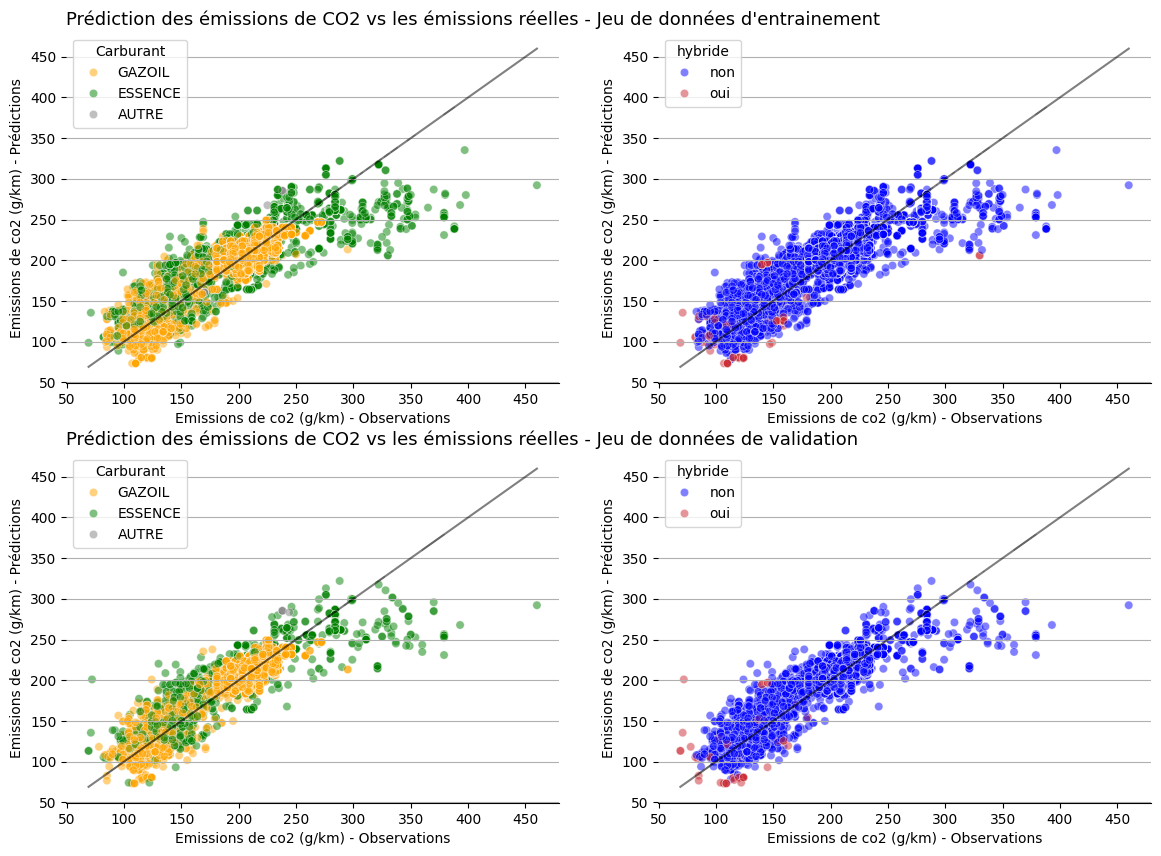

In [92]:

fig = pred_vs_reel_scatterplot(y_train_pred,y_train,y_val_pred,y_val, df_train, df_val)
fig.show()

/tmp/ipykernel_3067/3701242798.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=30, ha='right', fontsize=9)
/tmp/ipykernel_3067/3701242798.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=30, ha='right', fontsize=9)
/tmp/ipykernel_3067/2400342592.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


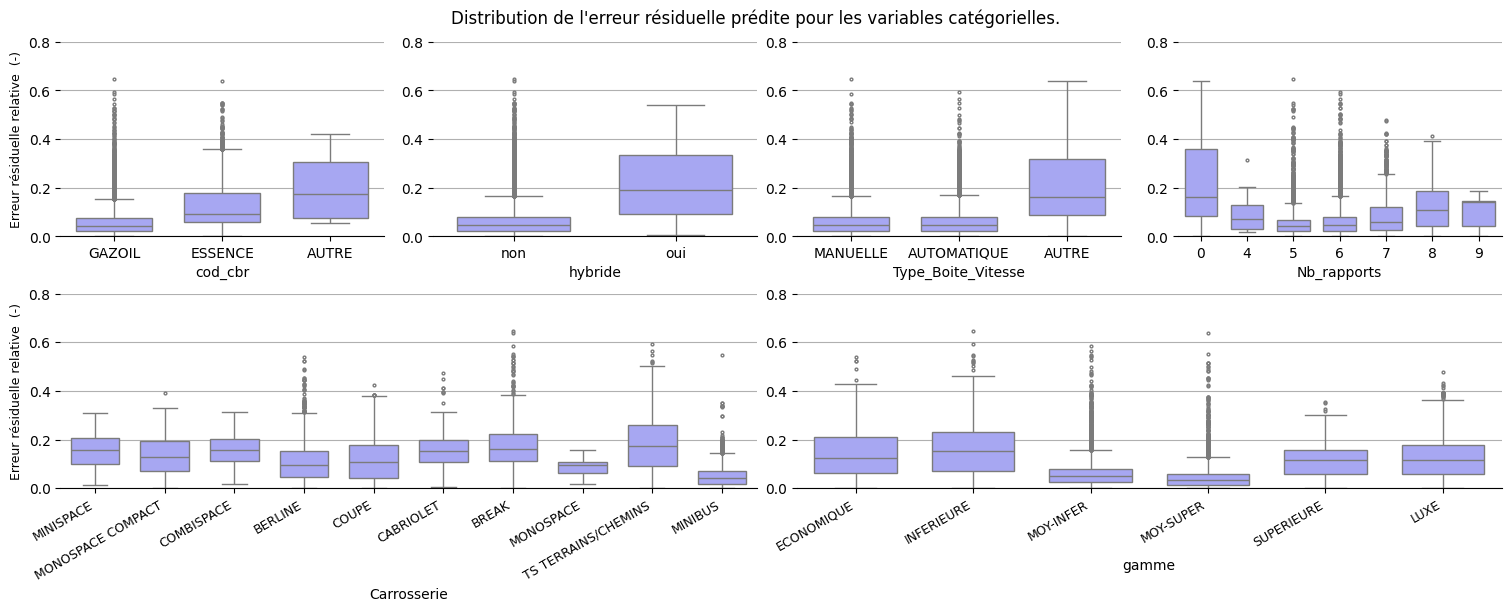

In [93]:
fig = residual_boxplot(y_train_pred, y_train, df_train, dict_order_carrosserie, dict_order_gamme)
fig.show()


Les scatterplots indiquent de manière globale que pour les véhicules concernés par des émissions de CO2 inférieure à 250 g/km, le modèle va voir tendance à légèrement surestimer les émissions de CO2. A contrario pour les émissions > 250g/km qui sont plus sporadiques, le modèle les sous estime significativement.

Ces scatterplots nous indiquent également que le modèle a tendance à moins bien capturer les émissions de CO2 pour véhicules essence ainsi que les véhicules hybrides. Ce point peut s'expliquer directement par le fait que les véhicules hybrides sont sous représentés dans notre base de données et les véhicules à moteur essence ne constituent que 10% des observations.

Les boxplots viennent plussoyer ce point au regard des différences relative des prédictions par rapport aux observations par type de carroserie et de gamme. Les valeurs médianes de ces différences relatives sont significativement plus faibles pour les modalités les plus représentées à savoir les 'minibus' et les gammes "moyenne inférieure" et "moyenne supérieuré.

#### 2.4.2.1 Apport de features polynômiales

Regardons si les capacités de prédiction de notre modèle 2 peuvent être améliorées en ajoutant des features polynômiales.

**Second Ordre :**

In [94]:
# Définition de Features polynômiales d'ordre 2
poly_features_2 = PolynomialFeatures(degree=2)

# Transformation des variables explicatives
X_train_poly = poly_features_2.fit_transform(X_train)

# Affichage de la première ligne de X_train_poly
X_train_poly[:1]


array([[1.0000e+00, 1.1000e+02, 1.6100e+03, 2.0000e+00, 0.0000e+00,
        4.0000e+00, 3.0000e+00, 2.0000e+00, 6.0000e+00, 1.2100e+04,
        1.7710e+05, 2.2000e+02, 0.0000e+00, 4.4000e+02, 3.3000e+02,
        2.2000e+02, 6.6000e+02, 2.5921e+06, 3.2200e+03, 0.0000e+00,
        6.4400e+03, 4.8300e+03, 3.2200e+03, 9.6600e+03, 4.0000e+00,
        0.0000e+00, 8.0000e+00, 6.0000e+00, 4.0000e+00, 1.2000e+01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.6000e+01, 1.2000e+01, 8.0000e+00, 2.4000e+01, 9.0000e+00,
        6.0000e+00, 1.8000e+01, 4.0000e+00, 1.2000e+01, 3.6000e+01]])

In [95]:
# Affichage des variables résultantes
poly_features_2.get_feature_names_out()

array(['1', 'puiss_max', 'masse_ordma_min', 'cod_cbr', 'hybride', 'gamme',
       'Carrosserie', 'Type_Boite_Vitesse', 'Nb_rapports', 'puiss_max^2',
       'puiss_max masse_ordma_min', 'puiss_max cod_cbr',
       'puiss_max hybride', 'puiss_max gamme', 'puiss_max Carrosserie',
       'puiss_max Type_Boite_Vitesse', 'puiss_max Nb_rapports',
       'masse_ordma_min^2', 'masse_ordma_min cod_cbr',
       'masse_ordma_min hybride', 'masse_ordma_min gamme',
       'masse_ordma_min Carrosserie',
       'masse_ordma_min Type_Boite_Vitesse',
       'masse_ordma_min Nb_rapports', 'cod_cbr^2', 'cod_cbr hybride',
       'cod_cbr gamme', 'cod_cbr Carrosserie',
       'cod_cbr Type_Boite_Vitesse', 'cod_cbr Nb_rapports', 'hybride^2',
       'hybride gamme', 'hybride Carrosserie',
       'hybride Type_Boite_Vitesse', 'hybride Nb_rapports', 'gamme^2',
       'gamme Carrosserie', 'gamme Type_Boite_Vitesse',
       'gamme Nb_rapports', 'Carrosserie^2',
       'Carrosserie Type_Boite_Vitesse', 'Carrosseri

In [96]:
# Affichage du nombre de variables résultantes
print(f"Le nombre de variables totales incluant les combinaisons polynômiales d'ordre 2 max est de : {poly_features_2.get_feature_names_out().shape[0]}.")

Le nombre de variables totales incluant les combinaisons polynômiales d'ordre 2 max est de : 45.


In [97]:
# Définition du modèle de régression linéaire
reg_poly_2 = LinearRegression()

# entraînement du modèle à l'aide de (X_train_poly, y_train), et prédiction de y_train_pred
y_train_pred = reg_poly_2.fit(X_train_poly, y_train).predict(X_train_poly)

# Evaluation des performances du modèle sur l'échantillon d'entraînement
MAE_train, RMSE_train, R2_train, R2_adjusted_train = get_perf_stat(y_train, y_train_pred, poly_features_2.get_feature_names_out().shape[0])

# Affichage des performances :
print(f"Les performances sur le set de train sont : \nMAE :  {MAE_train}, RMSE : {RMSE_train}, R2 : {R2_train}, R2 ajusté : {R2_adjusted_train}")

# Evaluation sur le set de validation
y_val_pred = reg_poly_2.predict(poly_features_2.transform(X_val))

# Evaluation des performances du modèle sur l'échantillon de validation
MAE_val, RMSE_val, R2_val, R2_adjusted_val = get_perf_stat(y_val, y_val_pred, poly_features_2.get_feature_names_out().shape[0])

# Affichage des performances sur l'échantillon de validation :
print(f"Les performances sur le set de validation sont :\nMAE :  {MAE_val}, RMSE : {RMSE_val}, R2 : {R2_val}, R2 ajusté : {R2_adjusted_val}")


Les performances sur le set de train sont : 
MAE :  9.26, RMSE : 12.96, R2 : 0.8538, R2 ajusté : 0.8536
Les performances sur le set de validation sont :
MAE :  9.17, RMSE : 13.07, R2 : 0.8485, R2 ajusté : 0.8479


In [98]:
# Détermination de l'équation issue de cette régression linéaire :
equation = f"{round(reg_poly_2.intercept_,4)}"
for k, var in enumerate(poly_features_2.get_feature_names_out()) :
       equation +=  f" + {round(reg_poly_2.coef_[k],4)} * {var}"
       if (k % 3) == 2 :
              equation+= "\n"
print(f"L'équation de cette régression est : {equation}\n !!!")

L'équation de cette régression est : -39.204 + 0.0 * 1 + 0.7109 * puiss_max + 0.1784 * masse_ordma_min
 + 54.6313 * cod_cbr + -76.4032 * hybride + -16.9511 * gamme
 + -7.7484 * Carrosserie + -30.7357 * Type_Boite_Vitesse + -3.497 * Nb_rapports
 + -0.0001 * puiss_max^2 + -0.0 * puiss_max masse_ordma_min + -0.3122 * puiss_max cod_cbr
 + -0.3457 * puiss_max hybride + 0.0862 * puiss_max gamme + 0.006 * puiss_max Carrosserie
 + 0.0436 * puiss_max Type_Boite_Vitesse + -0.0486 * puiss_max Nb_rapports + -0.0 * masse_ordma_min^2
 + -0.0093 * masse_ordma_min cod_cbr + -0.0199 * masse_ordma_min hybride + -0.0002 * masse_ordma_min gamme
 + -0.0003 * masse_ordma_min Carrosserie + -0.0072 * masse_ordma_min Type_Boite_Vitesse + -0.0004 * masse_ordma_min Nb_rapports
 + -26.1732 * cod_cbr^2 + -7.7974 * cod_cbr hybride + 6.3973 * cod_cbr gamme
 + 0.5363 * cod_cbr Carrosserie + -2.7728 * cod_cbr Type_Boite_Vitesse + 5.4062 * cod_cbr Nb_rapports
 + -76.4032 * hybride^2 + 5.651 * hybride gamme + -2.8876 * 

Nous remarquons que les performances sont significativement améliorées :
* Le biais de notre modèle 2 initial a largement diminué ce traduisant par une MAE et une RMSE plus basses de 9 et 13 g/km(contre 12 et 16 g/km précédemment)
* La variabilité au sein du jeu de données est également mieux prise en compte ce qui se traduit par un R2 de 0.85 (contre 0.77 initialement).
* Les paramètres calculés dans cette régression indiquent une plus forte contribution des variables d'ordre 1 à la solution, ainsi qu'une forte contribution des différentes combinaisons de variables impliquant la feature '`hybride`' (notamment '`puiss_max`' * '`hybride`', '`hybride`' * '`Type_Boite_Vitesse`' et '`hybride`^2)

Illustrons les prédictions sur le jeu de train par le biais de :
* scatterplots des resultats prédits versus ceux observés en fonction du type de carburant et de l'hybridité des véhicules.
* de boxplots représentant les indicateurs statistiques de écarts (en %) entre les prédictions et les observations selon les classes de nos 5 variables catégorielles.

/tmp/ipykernel_3067/1522865934.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


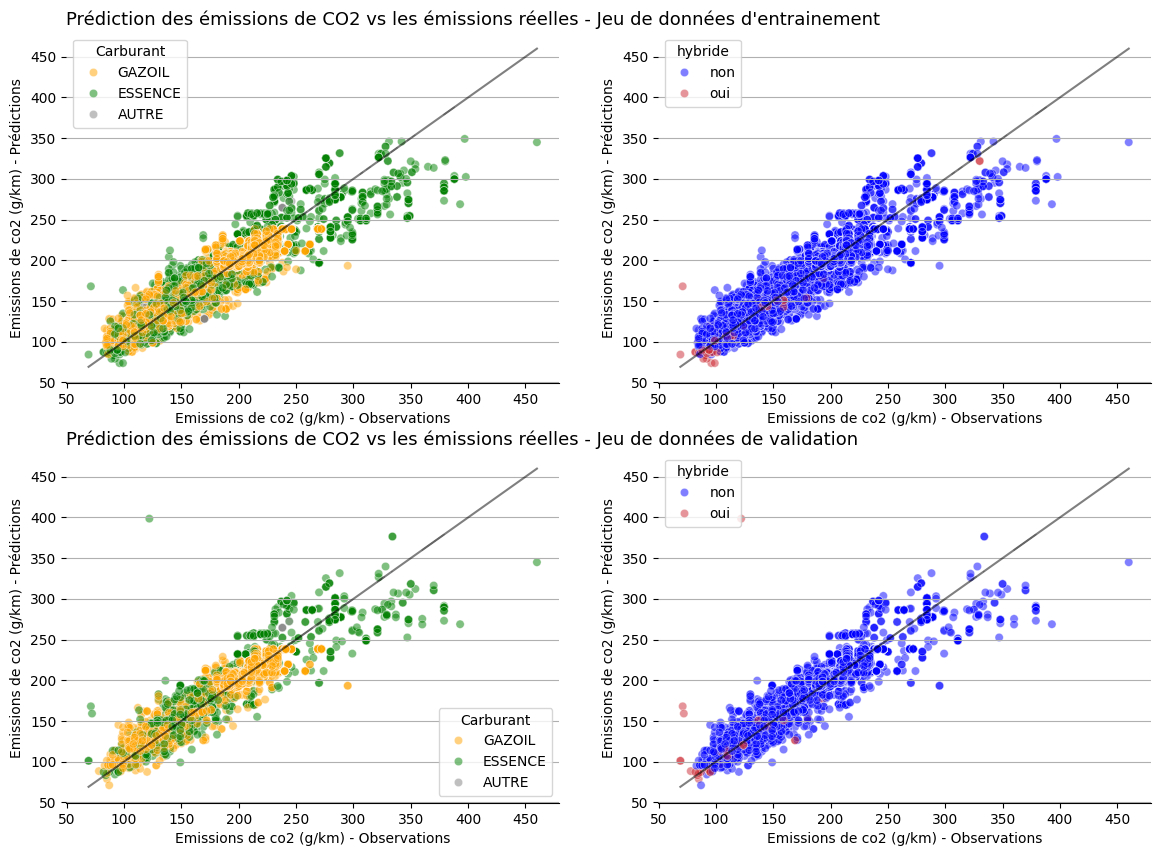

In [99]:
fig = pred_vs_reel_scatterplot(y_train_pred,y_train,y_val_pred,y_val, df_train, df_val)
fig.show()

/tmp/ipykernel_3067/3701242798.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=30, ha='right', fontsize=9)
/tmp/ipykernel_3067/3701242798.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=30, ha='right', fontsize=9)
/tmp/ipykernel_3067/2983858566.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


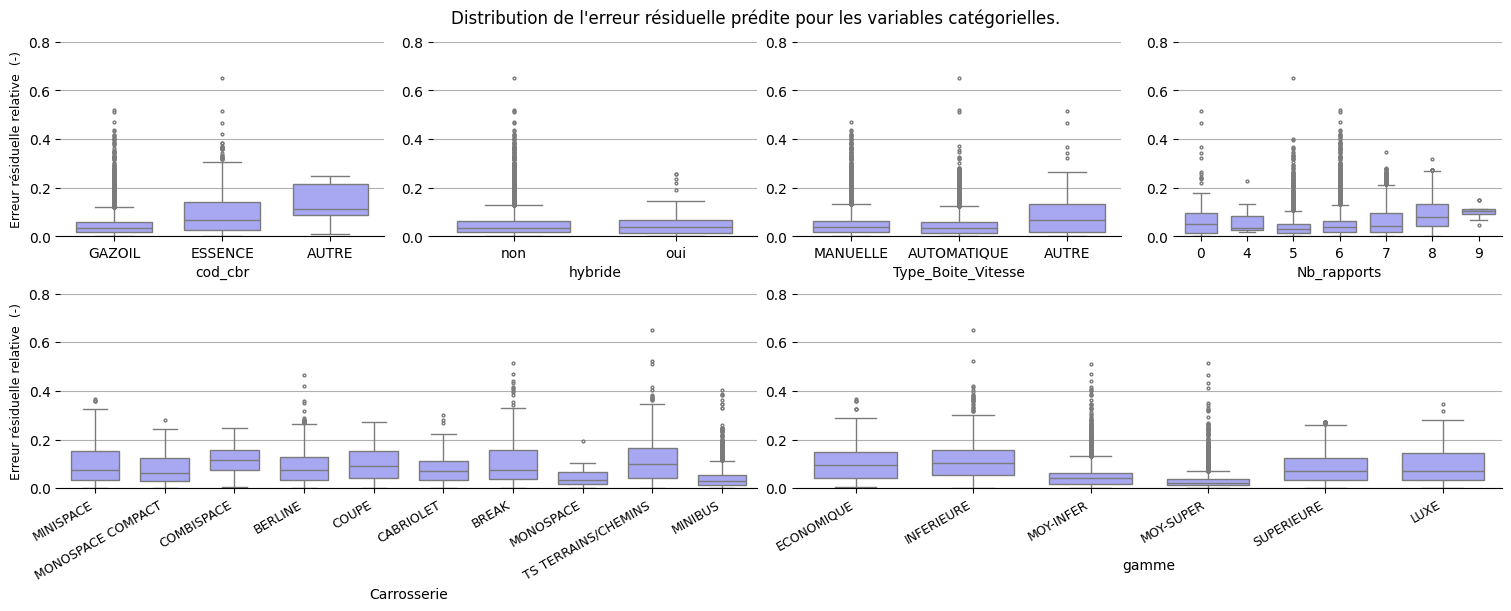

In [100]:
fig = residual_boxplot(y_train_pred, y_train, df_train, dict_order_carrosserie, dict_order_gamme)
fig.show()

Ces graphiques indiquent que l'ajout de combinaisons polynômiales d'ordre 2 maximum permet clairement de corriger les 2 points que nous avions relevés initialement, à savoir:
* les surestimations des émissions de CO2 pour les observations dont la target réelle est < à 250 g/km
* les sous-estimations des émissions de CO2 pour les observations sont la target réelle est > à 250 g/km

Les mesures statistiques de la différence relative des prédictions par rapport aux observations indiquent au global des indicateurs médians et des maxima plus bas, notammant pour les véhicules hybrides et à moteur essence.

**Ordre 3:**

Vérifions si le fait d'augmenter le degré maximum des features polynômiales peut contribuer à améliorer davantage le modèle 2.

In [101]:
reg_poly_3 = LinearRegression()

# Définition de Features polynomiales d'ordre 2
poly_features_3 = PolynomialFeatures(degree=3)

# Transformation des variables explicatives
X_train_poly_3 = poly_features_3.fit_transform(X_train)

# entraînement du modèle à l'aide de (X_train_poly_3, y_train), et prédiction de y_train_pred
y_train_pred = reg_poly_3.fit(X_train_poly_3, y_train).predict(X_train_poly_3)

# Evaluation des performances du modèle sur l'échantillon d'entraînement
MAE_train, RMSE_train, R2_train, R2_adjusted_train = get_perf_stat(y_train, y_train_pred, poly_features_3.get_feature_names_out().shape[0])

# Affichage des performances :
print(f"Les performances sur le set de train sont : \nMAE :  {MAE_train}, RMSE : {RMSE_train}, R2 : {R2_train}, R2 ajusté : {R2_adjusted_train}")

# Evaluation sur le set de validation
y_val_pred = reg_poly_3.predict(poly_features_3.transform(X_val))

# Evaluation des performances du modèle sur l'échantillon de validation
MAE_val, RMSE_val, R2_val, R2_adjusted_val = get_perf_stat(y_val, y_val_pred, poly_features_3.get_feature_names_out().shape[0])

# Affichage des performances sur l'échantillon de validation :
print(f"Les performances sur le set de validation sont :\nMAE :  {MAE_val}, RMSE : {RMSE_val}, R2 : {R2_val}, R2 ajusté : {R2_adjusted_val}")

Les performances sur le set de train sont : 
MAE :  8.2, RMSE : 10.82, R2 : 0.8982, R2 ajusté : 0.8976
Les performances sur le set de validation sont :
MAE :  8.95, RMSE : 47.64, R2 : -1.014, R2 ajusté : -1.0412


Les résultats des métriques calculées pour les prédictions du jeu d'entraînement sont améliorés, néanmoins les résultats sur le jeu de validation indiquent que nous sommes très clairement dans une situation de sur-apprentissage avec une RMSE qui augmente significativement un coefficient de détermination R2 qui est négatif.

## 2.5 Evaluation des performances de généralisation des 2 modèles sur le jeu de test

### 2.5.1 Préparation du set de test

Appliquons les mêmes transformations des variables du set de test que dans la section 2.1.

In [102]:
# Affichage des 1ères lignes des données test
df_test.head()

# Sélection des variables (8 variables + 1 target)
df_test = df_test[selected_variables]

# Affichage des 5 premières lignes de notre échantillon de test
df_test.head()

,conso_mixte,puiss_max,masse_ordma_min,cod_cbr,typ_boite_nb_rapp,hybride,gamme,Carrosserie,co2
46793,7.2,120.0,2356,GO,M 6,non,MOY-INFER,MINIBUS,189.0
45763,8.0,80.0,2028,GO,M 6,non,MOY-INFER,MINIBUS,209.0
38778,8.4,165.0,1976,GO,A 5,non,MOY-INFER,MINIBUS,221.0
35248,8.0,120.0,2076,GO,A 5,non,MOY-INFER,MINIBUS,211.0
12432,8.4,120.0,2186,GO,M 6,non,MOY-INFER,MINIBUS,222.0


In [103]:
## Appliquons la fonction transform_variables à nos données test (nous obtiendrons une variable de plus)
df_test = transform_variables(df_test)

## Affichage des 1ère lignes
df_test.head()

,conso_mixte,puiss_max,masse_ordma_min,cod_cbr,hybride,gamme,Carrosserie,co2,Type_Boite_Vitesse,Nb_rapports
46793,7.2,120.0,2356,GAZOIL,non,2,9,189.0,MANUELLE,6
45763,8.0,80.0,2028,GAZOIL,non,2,9,209.0,MANUELLE,6
38778,8.4,165.0,1976,GAZOIL,non,2,9,221.0,AUTOMATIQUE,5
35248,8.0,120.0,2076,GAZOIL,non,2,9,211.0,AUTOMATIQUE,5
12432,8.4,120.0,2186,GAZOIL,non,2,9,222.0,MANUELLE,6


In [104]:
# Séparation des variables explicatives (X_test) de notre target (y_test)
X_test = df_test.drop(columns=  "co2")
y_test = df_test["co2"]

 ### 2.5.2 Généralisation du modèle 1
 Dans cette section nous reprenons la pipeline de transformation générée en considérant l'encodage ordinale des variables '`hybride`', '`type_Boite_Vitesse`' et '`cod_cbr`' :


In [105]:
pipe_mod1_ord_enc

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat_text',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['cod_cbr', 'hybride',
                                                   'Type_Boite_Vitesse']),
                                                 ('keep_columns', 'passthrough',
                                                  ['conso_mixte', 'puiss_max',
                                                   'masse_ordma_min', 'gamme',
                                                   'Carrosserie',
                                                   'Nb_rapports'])])),
                ('regressor', LinearRegression())])

In [106]:
# Prédictions sur l'échantillon de test
y_test_pred_1 = pipe_mod1_ord_enc.predict(X_test)

# Evaluation des performances du modèle sur l'échantillon de test
MAE_test, RMSE_test, R2_test, R2_adjusted_test = get_perf_stat(y_test, y_test_pred_1, X_test.shape[1])

# Affichage des performances :
print(f"Avec les {len(X_test.columns)} variables suivantes \n: {X_test.columns}\nLes performances sur le set de test sont :\n")
print(f"MAE : {MAE_test}, RMSE : {RMSE_test}, R2 : {R2_test}, R2 ajusté : {R2_adjusted_test}")



Avec les 9 variables suivantes 
: Index(['conso_mixte', 'puiss_max', 'masse_ordma_min', 'cod_cbr', 'hybride',
       'gamme', 'Carrosserie', 'Type_Boite_Vitesse', 'Nb_rapports'],
      dtype='object')
Les performances sur le set de test sont :

MAE : 1.32, RMSE : 2.81, R2 : 0.9932, R2 ajusté : 0.9932


Ces résultats indiquent que le modèle 1 possède une excellente capacité de généralisation avec des métriques relativement similaires que celles obtenues pour le jeu d'entraînement :
* MAE :  1.32 vs 1.34 pour le set d'entraînement,
* RMSE 2.81 vs 3.2 pour le set d'entraînement,
* R2 : 0.9932 vs 0.991 pour le set d'entraînement.

 ### 2.5.3 Généralisation du modèle 2
 Dans cette section nous reprenons la régression linéaire avec ajout de features polynômiales d'ordre 2.

In [107]:
#Encodage ordinal des variables 'hybride', 'cod_cbr', 'Type_Boite_Vitesse' des données test
X_test["cod_cbr"] = X_test["cod_cbr"].map({"AUTRE" : 0, "ESSENCE" : 1, "GAZOIL": 2})
X_test["Type_Boite_Vitesse"] = X_test["Type_Boite_Vitesse"].map({"AUTOMATIQUE" : 0, "AUTRE" : 1, "MANUELLE": 2})
X_test["hybride"] = X_test["hybride"].map({"non" : 0, "oui" : 1})

#Affichage des 1ère lignes
X_test.head()

,conso_mixte,puiss_max,masse_ordma_min,cod_cbr,hybride,gamme,Carrosserie,Type_Boite_Vitesse,Nb_rapports
46793,7.2,120.0,2356,2,0,2,9,2,6
45763,8.0,80.0,2028,2,0,2,9,2,6
38778,8.4,165.0,1976,2,0,2,9,0,5
35248,8.0,120.0,2076,2,0,2,9,0,5
12432,8.4,120.0,2186,2,0,2,9,2,6


In [108]:
# Suppression de la variable 'conso_mixte' :
print(f"Avant suppression de la colonne 'conso-mixte'  X_test possède : {X_test.shape[1]} colonnes.")
X_test.drop(columns = "conso_mixte", inplace = True)
print(f"Après suppression de la colonne 'conso-mixte' X_train possède : {X_train.shape[1]} colonnes.")

Avant suppression de la colonne 'conso-mixte'  X_test possède : 9 colonnes.
Après suppression de la colonne 'conso-mixte' X_train possède : 8 colonnes.


In [109]:
# Transformation des features initiales en combinaisons polynômiales d'ordre max de 2.
X_test_poly = poly_features_2.transform(X_test)

# Affichage de la première ligne de X_test_poly
X_test_poly[:1]

array([[1.000000e+00, 1.200000e+02, 2.356000e+03, 2.000000e+00,
        0.000000e+00, 2.000000e+00, 9.000000e+00, 2.000000e+00,
        6.000000e+00, 1.440000e+04, 2.827200e+05, 2.400000e+02,
        0.000000e+00, 2.400000e+02, 1.080000e+03, 2.400000e+02,
        7.200000e+02, 5.550736e+06, 4.712000e+03, 0.000000e+00,
        4.712000e+03, 2.120400e+04, 4.712000e+03, 1.413600e+04,
        4.000000e+00, 0.000000e+00, 4.000000e+00, 1.800000e+01,
        4.000000e+00, 1.200000e+01, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 4.000000e+00,
        1.800000e+01, 4.000000e+00, 1.200000e+01, 8.100000e+01,
        1.800000e+01, 5.400000e+01, 4.000000e+00, 1.200000e+01,
        3.600000e+01]])

In [110]:
# Calculs des prédictions sur les données
y_test_pred = reg_poly_2.predict(X_test_poly)

# Estimation des performances du modèle sur l'échantillon de test
MAE_test, RMSE_test, R2_test, R2_adjusted_test = get_perf_stat(y_test, y_test_pred, poly_features_2.get_feature_names_out().shape[0])

# Affichage des performances sur l'échantillon de test
print(f"Les performances sur le set de test sont :\nMAE : {MAE_test}, RMSE : {RMSE_test}, R2 : {R2_test}, R2 ajusté : {R2_adjusted_test}")

Les performances sur le set de test sont :
MAE : 9.32, RMSE : 13.19, R2 : 0.8517, R2 ajusté : 0.8512


Le modèle 2 possède également une bonne capacité de généralisation à d'autres données avec des métriques très similaires à celles du test d'entraînement et de validation :
* MAE :  9.32 vs 9.26 pour le set d'entraînement,
* RMSE 13.2 vs 12.96 pour le set d'entrainement,
* R2 : 0.8515 vs 0.8535 pour le set d'entraînement.


# Conclusion

L’analyse exploratoire de la base de données provenant de l’ADEME a révélé de forts déséquilibres au sein des classes de ses différentes variables catégorielles. Parmi ceux-ci nous avons relevé que : 
* 90.0% des véhicules enregistrés en base fonctionnent au gazoil en régime moteur, contre 9.9 % pour essence.
* Plus de 99% de nos observations sont constituées de véhicules non hybrides
* L’essentiel des véhicules sont des minibus (84%).

Les analyses multivariées ont permis de mettre en évidence les points suivants:
* Les émissions de CO2 sont très fortement corrélées à la consommation de carburant en conduite mixte (avec un coefficient de 0.97), suivi par la masse (corrélation de 0.64) , le type de carrosserie, et plus faiblement à la puissance maximale (coefficient de corrélation de 0.35).
* Il existe de fortes corrélations entre les variables explicatives, par exemple entre la consommation, la masse, la puissance et la carrosserie.

Bien que conceptuellement il soit aisé d’établir que la consommation de carburant puisse expliquer en grande partie les émissions de CO2, la trop forte corrélation entre la consommation et la target nous a amené à étudier la prise en compte de cette variable comme un hyperparamètre pour l’apprentissage de notre modèle de régression linéaire.
Les autres régresseurs que nous avons sélectionnés sont les variables relatives à la puissance maximale, la masse minimale, au type de carburant et de transmission ainsi que le nombre de vitesses, la nature hybride, la gamme et la carrosserie des véhicules.

Les résultats indiquent que la prise en compte de la consommation en carburant en plus des autres variables dans la régression linéaire produit d'excellentes prédictions d'émission de CO2 caractérisées par une MAE de 1.3 g/km, une RMSE 3.2 g/km (en considérant à une valeur médiane des émissions réelles de CO2 de 200g/km).Le coefficient de détermination obtenu est égal à 0.99. Ces résultats sont confirmés par une très bonne généralisation aux données de test avec une MAE de 1.3 g/km, une RMSE de 2.8 g/km et un coefficient de détermination de 0.99.

Le fait d'exclure la consommation de la régression linéaire se traduit naturellement par une augmentation des poids des régresseurs restants et une perte en précision du modèle. Néanmoins l'ajout de combinaisons polynômiales des features d'ordre 2 maximum permet de diminuer le biais du modèle traduit par une MAE et une RMSE très correctes de 9 et 13 g/km et un coefficient de détermination de 0.85. L’application de ce modèle aux données test produit des résultats comparables à ceux d’entraînement et de validation avec une MAE de 9.3 g/km, une RMSE de 13.2g/km et un R2 de 0.85.